In [12]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def q10(x):
    return x.quantile(0.1)


def q20(x):
    return x.quantile(0.2)


def q25(x):
    return x.quantile(0.25)


def q30(x):
    return x.quantile(0.3)


def q40(x):
    return x.quantile(0.4)


def q60(x):
    return x.quantile(0.6)


def q70(x):
    return x.quantile(0.7)


def q75(x):
    return x.quantile(0.75)


def q80(x):
    return x.quantile(0.8)


def q90(x):
    return x.quantile(0.9)

def feature_test_with_cv(X, y, params=None, cate_feas='auto', nfold=3):
    """
    [For LightGBM ONLY]
    Use cross validation to test if the feature distribution is the same in both train and test sets.
    y: 'istest' column with valus of 0-1
    Example:
        df_fea_auc = get_feature_report(df, features=gcn_feas, all_cate_feas=[], params=None,nfold=3)
    """
    if params is None:
        params = {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'early_stopping_rounds': 25,
            'metric': 'auc',
            'n_jobs': -1,
            'num_leaves': 31,
            'seed': 2020
        }
    sfold = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2020)
    models = []
    val_auc = 0
    train_auc = 0
    oof = np.zeros(len(X))
    for _, (train_idx, val_idx) in enumerate(sfold.split(X, y)):
        train_set = lgb.Dataset(X.iloc[train_idx],
                                y.iloc[train_idx],
                                categorical_feature=cate_feas)
        val_set = lgb.Dataset(X.iloc[val_idx],
                              y.iloc[val_idx],
                              categorical_feature=cate_feas)
        model = lgb.train(params,
                          train_set,
                          valid_sets=[train_set, val_set],
                          verbose_eval=20)
        val_auc += model.best_score['valid_1']['auc'] / 3
        train_auc += model.best_score['training']['auc'] / 3
        oof[val_idx] = model.predict(X.iloc[val_idx])
        models.append(model)
    return train_auc, val_auc, models, oof

def get_feature_report_by_covariate_shift_test(df_raw,
                                               features=None,
                                               all_cate_feas=[],
                                               params=None,
                                               nfold=3,
                                               y2test='istrain',
                                               train_all_feas=False):
    """
    Use cross validation to test if the feature distribution is the same in both train and test sets.
    Args:
        y2test: target to test, 'istrain' or 'istest'
        train_all_feas: if True, the model will be trained with all features together
    Return:
        result_dict: dict
    """
    df = df_raw.copy()
    del df_raw
    gc.collect()
    if features is None:
#         logger.info(
#             "features is none, all cols will be used except 'istrain' or 'istest'!"
#         )
        features = [
            col for col in df.columns if col not in ['istrain', 'istest']
        ]
    if train_all_feas:
        train_auc, val_auc, models, oof = feature_test_with_cv(
            X=df[features],
            y=df[y2test],
            params=params,
            cate_feas=[col for col in all_cate_feas if col in features],
            nfold=nfold)
        df['pred'] = oof
        if y2test == 'istrain':
            weights = df[df['istrain'] == 1]['pred'].values
            weights = (1. / weights) - 1.
            weights /= np.mean(weights)
        elif y2test == 'istest':
            weights = df[df['istest'] == 0]['pred'].values
            weights = (1. / (1 - weights)) - 1.
            weights /= np.mean(weights)
        else:
            raise NotImplementedError(
                "y2test should be in ['istrain','istest'] !")
        result_dict = {
            'train_auc': train_auc,
            'val_auc': val_auc,
            'models': models,
            'weights': weights
        }
    else:
        score_lst = []
        fea_lst = []
        for fea in features:
            if fea in all_cate_feas:
                cate_feas = [fea]
            else:
                cate_feas = 'auto'
#             logger.info("=" * 30)
#             logger.info(f"Testing: <{fea}> ...")
#             logger.info("=" * 30)
            train_auc, val_auc, _, _ = feature_test_with_cv(
                X=df[[fea]],
                y=df[y2test],
                params=params,
                cate_feas=cate_feas,
                nfold=nfold)
            fea_lst.append(fea)
            score_lst.append((train_auc, val_auc))
        df_fea_auc = pd.DataFrame(score_lst, columns=['train_auc', 'val_auc'])
        df_fea_auc['feat'] = fea_lst
        df_fea_auc = df_fea_auc.sort_values(by='val_auc', ascending=False)
        result_dict = {'df_fea_auc': df_fea_auc}
    return result_dict

def train_lgb(used_feat_,train_x,train_y,test_x,seed_num=3):
    scores = []
    imp = pd.DataFrame()
    imp['feat'] = used_feat_
    print(len(used_feat_)," : ",used_feat_)
    train_x = train_x[used_feat_]
    test_x = test_x[used_feat_]

    params = {
        'learning_rate': 0.1,
        'metric': 'multi_error',
        'objective': 'multiclass',
        'num_class': 19,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.75,
        'bagging_freq': 2,
        'n_jobs': 4,
        'seed': 2020,
        'max_depth': 10,
        'num_leaves': 64,
        'lambda_l1': 0.5,
        'lambda_l2': 0.5,
    }

    oof_train = np.zeros((len(train_x), pd.Series(train_y).nunique()))
    preds = np.zeros((len(test_x), pd.Series(train_y).nunique()))
    folds = 5
    seeds = [44, 2020, 527, 1527]
    for seed in seeds[:seed_num]:
        print("seed:",seed)
        kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
        for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
            print("seed:",seed,"fold:",fold)
            x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
            
            train_set = lgb.Dataset(x_trn, y_trn)
            val_set = lgb.Dataset(x_val, y_val)
            model = lgb.train(params, train_set, num_boost_round=5000,
                              valid_sets=(train_set,val_set), early_stopping_rounds=50,
                              verbose_eval=100)
            oof_train[val_idx] += model.predict(x_val) / seed_num
            preds += model.predict(test_x) / folds / seed_num
           
#             print(model.best_score)
            scores.append(model.best_score['valid_1']['multi_error'])
            imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
            imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
            
            
            del x_trn, y_trn, x_val, y_val, model, train_set, val_set
            gc.collect()
    imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1)/folds
    imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
    imp = imp.sort_values(by=['gain'], ascending=False)
    imp[['feat', 'gain', 'split']]
    imp = imp.sort_values(by=['split'], ascending=False)
    print(imp[['feat', 'gain', 'split']])
    print("--------------------finished-------------------")
    return oof_train,preds

    
from scipy.stats import entropy    
def entropy_values(x):
    x = pd.Series(x)
    return entropy(x.value_counts() / x.shape[0])
    

def kurt(x):
    return pd.Series(x).kurt()


def mode(x):
    '''
    return the mode of x, if the mode is not unique, return the first one in the sequence.
    sample：
        a = [1,1,2,2,3]# 1
        b = [1,2,2,3]  # 2
        mode(a)
        mode(b)

    '''
    return pd.Series(x).mode()[0]


from scipy.stats import moment
def fourth_moment(x):
    '''sample:
        fourth_moment([1,2,3])#2.3907061857313376
    '''
    return moment(x,4)


def fifth_moment(x):
    '''sample:
        fifth_moment([1,2,3])#2.4703447490385586
    '''
    return moment(x,5)


def range_value(x):
    '''
    range(极差) of x,
    '''
    return x.max() - x.min()


def root_mean_square(x):
    '''
    root_mean_square
    sample:
        root_mean_square([1,2,3])#2.160246899469287
    '''
    return np.sqrt(np.mean(np.array(x) ** 2))
import matplotlib.mlab as mlab
def getIntegrationOfPSD(x_):
    '''
    
    :param x_: list data
    :return: 
    '''
    x = np.array(x_)
    avg = np.sum(x) / len(x)
    fs = 5 * len(x)# 加窗5倍
    xn = x - avg * np.ones((len(x),))
    xn = (xn - np.sum(xn) / len(xn) * np.ones((len(xn),)))
    nfft = np.ceil(np.log(fs) / np.log(2))
    pxx, f = plt.psd(xn, NFFT=nfft, Fs=fs, window=mlab.window_none, pad_to=512,
                     scale_by_freq=True)
    integration = pxx[1:len(pxx)] * (f[1:len(f)] - f[0:(len(f) - 1)])
    pow = np.sum(integration)
    return pow

In [2]:
7 * 400 * 5 / 60 / 60

3.888888888888889

In [3]:
# from tensorflow_addons.optimizers import AdamW
# import tensorflow


In [15]:
root_path  = '../data/final_data/'
data_train = pd.read_csv(root_path+'sensor_train_final.csv')
data_test = pd.read_csv(root_path+'sensor_test_final.csv')
sub = pd.read_csv(root_path+'submit_example.csv')
y = data_train.groupby('fragment_id')['behavior_id'].min()
data_test['fragment_id'] += 100000
label = 'behavior_id'
data = pd.concat([data_train, data_test], sort=False,ignore_index=True)
df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]

def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
    df['thetax']=np.arctan(df.acc_xg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetay']=np.arctan(df.acc_yg/
                           np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetaz']=np.arctan(df.acc_zg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi

    df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
    df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5    
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df
data = add_features(data)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'accg', 'thetax', 'thetay',
       'thetaz', 'xy', 'xy_g', 'g'],
      dtype='object')


In [16]:
df["istrain"] = 0
df.loc[:15000,"istrain"] = 1
print(df.shape)
df.tail()

(31000, 249)


,fragment_id,behavior_id,count,acc_x_min_x,acc_x_max_x,acc_x_mean_x,acc_x_sum_x,acc_x_median_x,acc_x_skew_x,acc_x_kurt_x,acc_x_mad_x,acc_x_std_x,acc_x_var_x,acc_x_mode_x,acc_x_min_y,acc_x_max_y,acc_x_mean_y,acc_x_sum_y,acc_x_median_y,acc_x_skew_y,acc_x_kurt_y,acc_x_mad_y,acc_x_std_y,acc_x_var_y,acc_x_mode_y,acc_x_q10,acc_x_q20,acc_x_q25,acc_x_q30,acc_x_q40,acc_x_q60,acc_x_q70,acc_x_q75,acc_x_q80,acc_x_q90,acc_x_entropy_values,acc_x_fourth_moment,acc_x_fifth_moment,acc_x_range_value,acc_x_root_mean_square,acc_y_min,acc_y_max,acc_y_mean,acc_y_sum,acc_y_median,acc_y_skew,acc_y_kurt,acc_y_mad,acc_y_std,acc_y_var,acc_y_mode,acc_y_q10,acc_y_q20,acc_y_q25,acc_y_q30,acc_y_q40,acc_y_q60,acc_y_q70,acc_y_q75,acc_y_q80,acc_y_q90,acc_y_entropy_values,acc_y_fourth_moment,acc_y_fifth_moment,acc_y_range_value,acc_y_root_mean_square,acc_z_min,acc_z_max,acc_z_mean,acc_z_sum,acc_z_median,acc_z_skew,acc_z_kurt,acc_z_mad,acc_z_std,acc_z_var,acc_z_mode,acc_z_q10,acc_z_q20,acc_z_q25,acc_z_q30,acc_z_q40,acc_z_q60,acc_z_q70,acc_z_q75,acc_z_q80,acc_z_q90,acc_z_entropy_values,acc_z_fourth_moment,acc_z_fifth_moment,acc_z_range_value,acc_z_root_mean_square,acc_xg_min,acc_xg_max,acc_xg_mean,acc_xg_sum,acc_xg_median,acc_xg_skew,acc_xg_kurt,acc_xg_mad,acc_xg_std,acc_xg_var,acc_xg_mode,acc_xg_q10,acc_xg_q20,acc_xg_q25,acc_xg_q30,acc_xg_q40,acc_xg_q60,acc_xg_q70,acc_xg_q75,acc_xg_q80,acc_xg_q90,acc_xg_entropy_values,acc_xg_fourth_moment,acc_xg_fifth_moment,acc_xg_range_value,acc_xg_root_mean_square,acc_yg_min,acc_yg_max,acc_yg_mean,acc_yg_sum,acc_yg_median,acc_yg_skew,acc_yg_kurt,acc_yg_mad,acc_yg_std,acc_yg_var,acc_yg_mode,acc_yg_q10,acc_yg_q20,acc_yg_q25,acc_yg_q30,acc_yg_q40,acc_yg_q60,acc_yg_q70,acc_yg_q75,acc_yg_q80,acc_yg_q90,acc_yg_entropy_values,acc_yg_fourth_moment,acc_yg_fifth_moment,acc_yg_range_value,acc_yg_root_mean_square,acc_zg_min,acc_zg_max,acc_zg_mean,acc_zg_sum,acc_zg_median,acc_zg_skew,acc_zg_kurt,acc_zg_mad,acc_zg_std,acc_zg_var,acc_zg_mode,acc_zg_q10,acc_zg_q20,acc_zg_q25,acc_zg_q30,acc_zg_q40,acc_zg_q60,acc_zg_q70,acc_zg_q75,acc_zg_q80,acc_zg_q90,acc_zg_entropy_values,acc_zg_fourth_moment,acc_zg_fifth_moment,acc_zg_range_value,acc_zg_root_mean_square,acc_min,acc_max,acc_mean,acc_sum,acc_median,acc_skew,acc_kurt,acc_mad,acc_std,acc_var,acc_mode,acc_q10,acc_q20,acc_q25,acc_q30,acc_q40,acc_q60,acc_q70,acc_q75,acc_q80,acc_q90,acc_entropy_values,acc_fourth_moment,acc_fifth_moment,acc_range_value,acc_root_mean_square,accg_min,accg_max,accg_mean,accg_sum,accg_median,accg_skew,accg_kurt,accg_mad,accg_std,accg_var,accg_mode,accg_q10,accg_q20,accg_q25,accg_q30,accg_q40,accg_q60,accg_q70,accg_q75,accg_q80,accg_q90,accg_entropy_values,accg_fourth_moment,accg_fifth_moment,accg_range_value,accg_root_mean_square,acc_time_diff_min,acc_time_diff_max,acc_time_diff_mean,acc_time_diff_sum,acc_time_diff_median,acc_time_diff_skew,acc_time_diff_kurt,acc_time_diff_mad,acc_time_diff_std,acc_time_diff_var,acc_time_diff_mode,acc_time_diff_q10,acc_time_diff_q20,acc_time_diff_q25,acc_time_diff_q30,acc_time_diff_q40,acc_time_diff_q60,acc_time_diff_q70,acc_time_diff_q75,acc_time_diff_q80,acc_time_diff_q90,acc_time_diff_entropy_values,acc_time_diff_fourth_moment,acc_time_diff_fifth_moment,acc_time_diff_range_value,acc_time_diff_root_mean_square,istrain
30995,115995,0.0,0.0,-0.42,0.26,0.030000,1.26,0.040,-1.155347,4.060239,0.082381,0.120568,0.014537,-0.02,-0.42,0.26,0.030000,1.26,0.040,-1.155347,4.060239,0.082381,0.120568,0.014537,-0.02,-0.068,-0.020,-0.020,-0.017,0.014,0.056,0.080,0.0875,0.110,0.129,3.079604,0.001299,-0.000429,0.68,0.122843,-2.70,-0.03,-1.273333,-53.48,-1.140,-0.157372,-1.447890,0.803810,0.927464,0.860189,-0.78,-2.509,-2.390,-2.295,-2.081,-1.350,-0.962,-0.780,-0.2950,-0.240,-0.113,3.473614,1.113574,-2.787120e-01,2.67,1.568785,-2.94,2.93,-0.027143,-1.14,-0.725,0.081919,-1.745561,2.102653,2.247834,5.052757,-2.94,-2.796,-2.096,-2.0500,-1.904,-1.236,1.548,1.667,2.4775,2.618,2.756,3.737670,32.014559,8.060256,5.87,2.221079,-0.34,0.25,0.039524,1.66,0.030,-0.7

In [17]:

data = data.sort_values(['fragment_id','time_point'],ascending=False)
# data = data.set_index(['fragment_id','time_point'])
data['acc_time_diff'] = data.groupby(["fragment_id"])["time_point"].diff(1)
# data['acc_time_diff2'] = data.groupby(["fragment_id"])["time_point"].diff(2)
# data['acc_time_diff3'] = data.groupby(["fragment_id"])["time_point"].diff(3)

# data['acc_xg_diff1'] = data.groupby(["fragment_id"])["acc_xg"].diff(1)
# data['acc_yg_diff1'] = data.groupby(["fragment_id"])["acc_yg"].diff(1)

# data = data.reset_index()

all_stat_funtion = ['min', 'max', 'mean','sum', 'median',"skew",kurt, 'mad','std','var',\
                    q10, q20, q25, q30, q40, q60, q70, q75, q80, q90,\
                    entropy_values,range_value,root_mean_square]
all_stat_name = ['min', 'max', 'mean','sum','median',"skew",'kurt', 'mad','std','var',\
                 'q10', 'q20', 'q25', 'q30', 'q40', 'q60', 'q70', 'q75', 'q80', 'q90',\
                 'entropy_values',"range_value","root_mean_square"]

oral_item = ["acc_x","acc_y","acc_z","acc_xg","acc_yg","acc_zg","acc","accg","acc_time_diff"]
second_item = ["thetax","thetay","thetaz","xy","xy_g","g"]
# stat_cols =["acc","accg","xy","xy_g",\
#             "x/xy","y/xy","x/xy__g","y/xy__g",\
#             "acc_x","acc_y","acc_z","acc_xg","acc_yg","acc_zg",\
#             "g_x","g_y","g_z",\
#             'acc_xy/acc',"acc_xyg/g",\
#             "acc_xg/g",'acc_yg/g','acc_zg/g','acc_x/acc','acc_y/acc','acc_z/acc'\
#            ]

for item in tqdm(second_item+oral_item):
    for name,i in zip(all_stat_name,all_stat_funtion):
        print(item+"_"+name)
        df = df.merge(data.groupby(["fragment_id"])[item].agg(i).reset_index().rename(columns={item:item+"_"+name}),on='fragment_id',how='left')
df.head()
# df["time_count"] = df.merge(d/"ata.groupby("fragment_id")["acc"].count(),on='fragment_id',how='left')

  0%|          | 0/6 [00:00<?, ?it/s]

thetax_min
thetax_max
thetax_mean
thetax_sum
thetax_median
thetax_skew
thetax_kurt
thetax_mad
thetax_std
thetax_var
thetax_q10
thetax_q20
thetax_q25
thetax_q30
thetax_q40
thetax_q60
thetax_q70
thetax_q75
thetax_q80
thetax_q90
thetax_entropy_values
thetax_range_value
thetax_root_mean_square


 17%|█▋        | 1/6 [03:17<16:27, 197.46s/it]

thetay_min
thetay_max
thetay_mean
thetay_sum
thetay_median
thetay_skew
thetay_kurt
thetay_mad
thetay_std
thetay_var
thetay_q10
thetay_q20
thetay_q25
thetay_q30
thetay_q40
thetay_q60
thetay_q70
thetay_q75
thetay_q80
thetay_q90
thetay_entropy_values
thetay_range_value
thetay_root_mean_square


 33%|███▎      | 2/6 [06:34<13:09, 197.36s/it]

thetaz_min
thetaz_max
thetaz_mean
thetaz_sum
thetaz_median
thetaz_skew
thetaz_kurt
thetaz_mad
thetaz_std
thetaz_var
thetaz_q10
thetaz_q20
thetaz_q25
thetaz_q30
thetaz_q40
thetaz_q60
thetaz_q70
thetaz_q75
thetaz_q80
thetaz_q90
thetaz_entropy_values
thetaz_range_value
thetaz_root_mean_square


 50%|█████     | 3/6 [09:49<09:49, 196.64s/it]

xy_min
xy_max
xy_mean
xy_sum
xy_median
xy_skew
xy_kurt
xy_mad
xy_std
xy_var
xy_q10
xy_q20
xy_q25
xy_q30
xy_q40
xy_q60
xy_q70
xy_q75
xy_q80
xy_q90
xy_entropy_values
xy_range_value
xy_root_mean_square


 67%|██████▋   | 4/6 [13:06<06:33, 196.67s/it]

xy_g_min
xy_g_max
xy_g_mean
xy_g_sum
xy_g_median
xy_g_skew
xy_g_kurt
xy_g_mad
xy_g_std
xy_g_var
xy_g_q10
xy_g_q20
xy_g_q25
xy_g_q30
xy_g_q40
xy_g_q60
xy_g_q70
xy_g_q75
xy_g_q80
xy_g_q90
xy_g_entropy_values
xy_g_range_value
xy_g_root_mean_square


 83%|████████▎ | 5/6 [16:20<03:16, 196.02s/it]

g_min
g_max
g_mean
g_sum
g_median
g_skew
g_kurt
g_mad
g_std
g_var
g_q10
g_q20
g_q25
g_q30
g_q40
g_q60
g_q70
g_q75
g_q80
g_q90
g_entropy_values
g_range_value
g_root_mean_square


100%|██████████| 6/6 [19:37<00:00, 196.25s/it]


,fragment_id,behavior_id,count,acc_x_min_x,acc_x_max_x,acc_x_mean_x,acc_x_sum_x,acc_x_median_x,acc_x_skew_x,acc_x_kurt_x,acc_x_mad_x,acc_x_std_x,acc_x_var_x,acc_x_mode_x,acc_x_min_y,acc_x_max_y,acc_x_mean_y,acc_x_sum_y,acc_x_median_y,acc_x_skew_y,acc_x_kurt_y,acc_x_mad_y,acc_x_std_y,acc_x_var_y,acc_x_mode_y,acc_x_q10,acc_x_q20,acc_x_q25,acc_x_q30,acc_x_q40,acc_x_q60,acc_x_q70,acc_x_q75,acc_x_q80,acc_x_q90,acc_x_entropy_values,acc_x_fourth_moment,acc_x_fifth_moment,acc_x_range_value,acc_x_root_mean_square,acc_y_min,acc_y_max,acc_y_mean,acc_y_sum,acc_y_median,acc_y_skew,acc_y_kurt,acc_y_mad,acc_y_std,acc_y_var,acc_y_mode,acc_y_q10,acc_y_q20,acc_y_q25,acc_y_q30,acc_y_q40,acc_y_q60,acc_y_q70,acc_y_q75,acc_y_q80,acc_y_q90,acc_y_entropy_values,acc_y_fourth_moment,acc_y_fifth_moment,acc_y_range_value,acc_y_root_mean_square,acc_z_min,acc_z_max,acc_z_mean,acc_z_sum,acc_z_median,acc_z_skew,acc_z_kurt,acc_z_mad,acc_z_std,acc_z_var,acc_z_mode,acc_z_q10,acc_z_q20,acc_z_q25,acc_z_q30,acc_z_q40,acc_z_q60,acc_z_q70,acc_z_q75,acc_z_q80,acc_z_q90,acc_z_entropy_values,acc_z_fourth_moment,acc_z_fifth_moment,acc_z_range_value,acc_z_root_mean_square,acc_xg_min,acc_xg_max,acc_xg_mean,acc_xg_sum,acc_xg_median,acc_xg_skew,acc_xg_kurt,acc_xg_mad,acc_xg_std,acc_xg_var,acc_xg_mode,acc_xg_q10,acc_xg_q20,acc_xg_q25,acc_xg_q30,acc_xg_q40,acc_xg_q60,acc_xg_q70,acc_xg_q75,acc_xg_q80,acc_xg_q90,acc_xg_entropy_values,acc_xg_fourth_moment,acc_xg_fifth_moment,acc_xg_range_value,acc_xg_root_mean_square,acc_yg_min,acc_yg_max,acc_yg_mean,acc_yg_sum,acc_yg_median,acc_yg_skew,acc_yg_kurt,acc_yg_mad,acc_yg_std,acc_yg_var,acc_yg_mode,acc_yg_q10,acc_yg_q20,acc_yg_q25,acc_yg_q30,acc_yg_q40,acc_yg_q60,acc_yg_q70,acc_yg_q75,acc_yg_q80,acc_yg_q90,acc_yg_entropy_values,acc_yg_fourth_moment,acc_yg_fifth_moment,acc_yg_range_value,acc_yg_root_mean_square,acc_zg_min,acc_zg_max,acc_zg_mean,acc_zg_sum,acc_zg_median,acc_zg_skew,acc_zg_kurt,acc_zg_mad,acc_zg_std,acc_zg_var,acc_zg_mode,acc_zg_q10,acc_zg_q20,acc_zg_q25,acc_zg_q30,acc_zg_q40,acc_zg_q60,acc_zg_q70,acc_zg_q75,acc_zg_q80,acc_zg_q90,acc_zg_entropy_values,acc_zg_fourth_moment,acc_zg_fifth_moment,acc_zg_range_value,acc_zg_root_mean_square,acc_min,acc_max,acc_mean,acc_sum,acc_median,acc_skew,acc_kurt,acc_mad,acc_std,acc_var,acc_mode,acc_q10,acc_q20,acc_q25,acc_q30,acc_q40,acc_q60,acc_q70,acc_q75,acc_q80,acc_q90,acc_entropy_values,acc_fourth_moment,acc_fifth_moment,acc_range_value,acc_root_mean_square,accg_min,accg_max,accg_mean,accg_sum,accg_median,accg_skew,accg_kurt,accg_mad,accg_std,accg_var,accg_mode,accg_q10,accg_q20,accg_q25,accg_q30,accg_q40,accg_q60,accg_q70,accg_q75,accg_q80,accg_q90,accg_entropy_values,accg_fourth_moment,accg_fifth_moment,accg_range_value,accg_root_mean_square,acc_time_diff_min,acc_time_diff_max,acc_time_diff_mean,acc_time_diff_sum,acc_time_diff_median,acc_time_diff_skew,acc_time_diff_kurt,acc_time_diff_mad,acc_time_diff_std,acc_time_diff_var,acc_time_diff_mode,acc_time_diff_q10,acc_time_diff_q20,acc_time_diff_q25,acc_time_diff_q30,acc_time_diff_q40,acc_time_diff_q60,acc_time_diff_q70,acc_time_diff_q75,acc_time_diff_q80,acc_time_diff_q90,acc_time_diff_entropy_values,acc_time_diff_fourth_moment,acc_time_diff_fifth_moment,acc_time_diff_range_value,acc_time_diff_root_mean_square,istrain,thetax_min,thetax_max,thetax_mean,thetax_sum,thetax_median,thetax_skew,thetax_kurt,thetax_mad,thetax_std,thetax_var,thetax_q10,thetax_q20,thetax_q25,thetax_q30,thetax_q40,thetax_q60,thetax_q70,thetax_q75,thetax_q80,thetax_q90,thetax_entropy_values,thetax_range_value,thetax_root_mean_square,thetay_min,thetay_max,thetay_mean,thetay_sum,thetay_median,thetay_skew,thetay_kurt,thetay_mad,thetay_std,thetay_var,thetay_q10,thetay_q20,thetay_q25,thetay_q30,thetay_q40,thetay_q60,thetay_q70,thetay_q75,thetay_q80,thetay_q90,thetay_entropy_values,thetay_range_value,thetay_root_mean_square,thetaz_min,thetaz_max,thetaz_mean,thetaz_sum,thetaz_median,thetaz_skew,thetaz_kurt,thetaz_mad,thetaz_std,thetaz_var,thetaz_q10,thetaz_q20,thetaz_q25

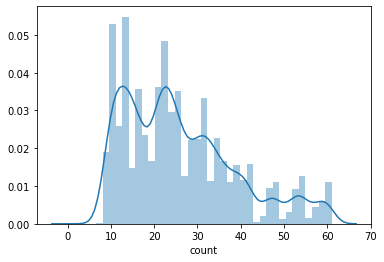

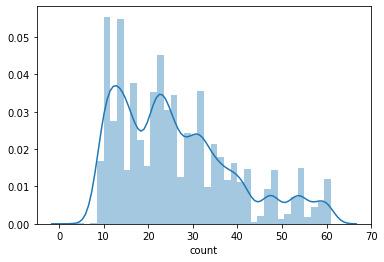

['count', 'acc_x_min_x', 'acc_x_max_x', 'acc_x_mean_x', 'acc_x_sum_x', 'acc_x_median_x', 'acc_x_skew_x', 'acc_x_kurt_x', 'acc_x_mad_x', 'acc_x_std_x', 'acc_x_var_x', 'acc_x_mode_x', 'acc_x_min_y', 'acc_x_max_y', 'acc_x_mean_y', 'acc_x_sum_y', 'acc_x_median_y', 'acc_x_skew_y', 'acc_x_kurt_y', 'acc_x_mad_y', 'acc_x_std_y', 'acc_x_var_y', 'acc_x_mode_y', 'acc_x_q10', 'acc_x_q20', 'acc_x_q25', 'acc_x_q30', 'acc_x_q40', 'acc_x_q60', 'acc_x_q70', 'acc_x_q75', 'acc_x_q80', 'acc_x_q90', 'acc_x_entropy_values', 'acc_x_fourth_moment', 'acc_x_fifth_moment', 'acc_x_range_value', 'acc_x_root_mean_square', 'acc_y_min', 'acc_y_max', 'acc_y_mean', 'acc_y_sum', 'acc_y_median', 'acc_y_skew', 'acc_y_kurt', 'acc_y_mad', 'acc_y_std', 'acc_y_var', 'acc_y_mode', 'acc_y_q10', 'acc_y_q20', 'acc_y_q25', 'acc_y_q30', 'acc_y_q40', 'acc_y_q60', 'acc_y_q70', 'acc_y_q75', 'acc_y_q80', 'acc_y_q90', 'acc_y_entropy_values', 'acc_y_fourth_moment', 'acc_y_fifth_moment', 'acc_y_range_value', 'acc_y_root_mean_square', 'acc

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525118	valid_1's auc: 0.51577
Early stopping, best iteration is:
[2]	training's auc: 0.524392	valid_1's auc: 0.517658
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529083	valid_1's auc: 0.509864
[40]	training's auc: 0.529101	valid_1's auc: 0.509193
Early stopping, best iteration is:
[16]	training's auc: 0.529056	valid_1's auc: 0.510147
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555152	valid_1's auc: 0.506691


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[9]	training's auc: 0.548924	valid_1's auc: 0.508928
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551532	valid_1's auc: 0.507511
Early stopping, best iteration is:
[12]	training's auc: 0.548062	valid_1's auc: 0.508107
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549406	valid_1's auc: 0.514654
Early stopping, best iteration is:
[2]	training's auc: 0.534441	valid_1's auc: 0.519966
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.551427	valid_1's auc: 0.510368
Early stopping, best iteration is:
[3]	training's auc: 0.542837	valid_1's auc: 0.512299
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552989	valid_1's auc: 0.503458
[40]	training's auc: 0.555721	valid_1's auc: 0.503525
Early stopping, best iteration is:
[15]	training's auc: 0.551574	valid_1's auc: 0.503652
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549807	valid_1's auc: 0.511336
Early stopping, best iteration is:
[4]	training's auc: 0.540804	valid_1's auc: 0.512905


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558735	valid_1's auc: 0.511744
[40]	training's auc: 0.563249	valid_1's auc: 0.510701
Early stopping, best iteration is:
[24]	training's auc: 0.560187	valid_1's auc: 0.511756
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556045	valid_1's auc: 0.513424
Early stopping, best iteration is:
[3]	training's auc: 0.538581	valid_1's auc: 0.516792
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557772	valid_1's auc: 0.509967
[40]	training's auc: 0.563512	valid_1's auc: 0.511122
Early stopping, best iteration is:
[33]	training's auc: 0.562061	valid_1's auc: 0.511631
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556569	valid_1's auc: 0.505043
[40]	training's auc: 0.56071	valid_1's auc: 0.506035
[60]	training's auc: 0.562568	valid_1's auc: 0.506385


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[80]	training's auc: 0.563289	valid_1's auc: 0.505812
Early stopping, best iteration is:
[62]	training's auc: 0.562578	valid_1's auc: 0.506486
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556473	valid_1's auc: 0.502557
[40]	training's auc: 0.559678	valid_1's auc: 0.502306
Early stopping, best iteration is:
[29]	training's auc: 0.558522	valid_1's auc: 0.503289
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554689	valid_1's auc: 0.500022
[40]	training's auc: 0.557997	valid_1's auc: 0.50168
[60]	training's auc: 0.559569	valid_1's auc: 0.501922
[80]	training's auc: 0.560336	valid_1's auc: 0.502449
[100]	training's auc: 0.560706	valid_1's auc: 0.502392
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560706	valid_1's auc: 0.502392
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546426	valid_1's auc: 0.502197
[40]	training's auc: 0.548602	valid_1's auc: 0.502

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538656	valid_1's auc: 0.513955
[40]	training's auc: 0.541387	valid_1's auc: 0.513225
Early stopping, best iteration is:
[17]	training's auc: 0.537902	valid_1's auc: 0.514956
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543369	valid_1's auc: 0.505138
Early stopping, best iteration is:
[8]	training's auc: 0.538757	valid_1's auc: 0.510491
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.556836	valid_1's auc: 0.507128
Early stopping, best iteration is:
[8]	training's auc: 0.546694	valid_1's auc: 0.510593
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557574	valid_1's auc: 0.492237
Early stopping, best iteration is:
[3]	training's auc: 0.540935	valid_1's auc: 0.494423
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55328	valid_1's auc: 0.502887
Early stopping, best iteration is:
[3]	training's auc: 0.539396	valid_1's auc: 0.504689
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.554435	valid_1's auc: 0.502909
[40]	training's auc: 0.558624	valid_1's auc: 0.505883
[60]	training's auc: 0.560201	valid_1's auc: 0.506183
[80]	training's auc: 0.560931	valid_1's auc: 0.506546
[100]	training's auc: 0.561276	valid_1's auc: 0.506588
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561276	valid_1's auc: 0.506588
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554385	valid_1's auc: 0.503952
Early stopping, best iteration is:
[1]	training's auc: 0.534708	valid_1's auc: 0.504311
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559527	valid_1's auc: 0.495319
Early stopping, best iteration is:
[5]	training's auc: 0.548255	valid_1's auc: 0.498736
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557836	valid_1's auc: 0.514434
Early stopping, best iteration is:
[14]	training's auc: 0.555189	valid_1's auc: 0.515816
Training until v

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.558677	valid_1's auc: 0.515773
[40]	training's auc: 0.563309	valid_1's auc: 0.514952
Early stopping, best iteration is:
[20]	training's auc: 0.558677	valid_1's auc: 0.515773
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557272	valid_1's auc: 0.517116
Early stopping, best iteration is:
[7]	training's auc: 0.551243	valid_1's auc: 0.520134
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559094	valid_1's auc: 0.503504
Early stopping, best iteration is:
[5]	training's auc: 0.552216	valid_1's auc: 0.507843


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554523	valid_1's auc: 0.514564
Early stopping, best iteration is:
[2]	training's auc: 0.538903	valid_1's auc: 0.515707
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557452	valid_1's auc: 0.506088
Early stopping, best iteration is:
[5]	training's auc: 0.54964	valid_1's auc: 0.510348
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559286	valid_1's auc: 0.503242
Early stopping, best iteration is:
[3]	training's auc: 0.545835	valid_1's auc: 0.507808


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554184	valid_1's auc: 0.516145
Early stopping, best iteration is:
[11]	training's auc: 0.550641	valid_1's auc: 0.517066
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556412	valid_1's auc: 0.505412
Early stopping, best iteration is:
[1]	training's auc: 0.543049	valid_1's auc: 0.509477
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538108	valid_1's auc: 0.506602
Early stopping, best iteration is:
[3]	training's auc: 0.527362	valid_1's auc: 0.510298


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538882	valid_1's auc: 0.504784
Early stopping, best iteration is:
[8]	training's auc: 0.535352	valid_1's auc: 0.506486
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541361	valid_1's auc: 0.500308
[40]	training's auc: 0.543026	valid_1's auc: 0.498888
Early stopping, best iteration is:
[23]	training's auc: 0.541838	valid_1's auc: 0.500833
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.555152	valid_1's auc: 0.506691
Early stopping, best iteration is:
[9]	training's auc: 0.548924	valid_1's auc: 0.508928
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551532	valid_1's auc: 0.507511
Early stopping, best iteration is:
[12]	training's auc: 0.548062	valid_1's auc: 0.508107
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549406	valid_1's auc: 0.514654
Early stopping, best iteration is:
[2]	training's auc: 0.534441	valid_1's auc: 0.519966


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551427	valid_1's auc: 0.510368
Early stopping, best iteration is:
[3]	training's auc: 0.542837	valid_1's auc: 0.512299
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552989	valid_1's auc: 0.503458
[40]	training's auc: 0.555721	valid_1's auc: 0.503525
Early stopping, best iteration is:
[15]	training's auc: 0.551574	valid_1's auc: 0.503652
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549807	valid_1's auc: 0.511336
Early stopping, best iteration is:
[4]	training's auc: 0.540804	valid_1's auc: 0.512905


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558735	valid_1's auc: 0.511744
[40]	training's auc: 0.563249	valid_1's auc: 0.510701
Early stopping, best iteration is:
[24]	training's auc: 0.560187	valid_1's auc: 0.511756
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556045	valid_1's auc: 0.513424
Early stopping, best iteration is:
[3]	training's auc: 0.538581	valid_1's auc: 0.516792
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557772	valid_1's auc: 0.509967
[40]	training's auc: 0.563512	valid_1's auc: 0.511122
Early stopping, best iteration is:
[33]	training's auc: 0.562061	valid_1's auc: 0.511631
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556569	valid_1's auc: 0.505043
[40]	training's auc: 0.56071	valid_1's auc: 0.506035
[60]	training's auc: 0.562568	valid_1's auc: 0.506385


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[80]	training's auc: 0.563289	valid_1's auc: 0.505812
Early stopping, best iteration is:
[62]	training's auc: 0.562578	valid_1's auc: 0.506486
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556473	valid_1's auc: 0.502557
[40]	training's auc: 0.559678	valid_1's auc: 0.502306
Early stopping, best iteration is:
[29]	training's auc: 0.558522	valid_1's auc: 0.503289
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554689	valid_1's auc: 0.500022
[40]	training's auc: 0.557997	valid_1's auc: 0.50168
[60]	training's auc: 0.559569	valid_1's auc: 0.501922
[80]	training's auc: 0.560336	valid_1's auc: 0.502449
[100]	training's auc: 0.560706	valid_1's auc: 0.502392
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560706	valid_1's auc: 0.502392
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546426	valid_1's auc: 0.502197


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.548602	valid_1's auc: 0.502409
Early stopping, best iteration is:
[16]	training's auc: 0.545313	valid_1's auc: 0.504003
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538656	valid_1's auc: 0.513955
[40]	training's auc: 0.541387	valid_1's auc: 0.513225
Early stopping, best iteration is:
[17]	training's auc: 0.537902	valid_1's auc: 0.514956
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543369	valid_1's auc: 0.505138
Early stopping, best iteration is:
[8]	training's auc: 0.538757	valid_1's auc: 0.510491


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556836	valid_1's auc: 0.507128
Early stopping, best iteration is:
[8]	training's auc: 0.546694	valid_1's auc: 0.510593
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557574	valid_1's auc: 0.492237
Early stopping, best iteration is:
[3]	training's auc: 0.540935	valid_1's auc: 0.494423
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55328	valid_1's auc: 0.502887
Early stopping, best iteration is:
[3]	training's auc: 0.539396	valid_1's auc: 0.504689


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554435	valid_1's auc: 0.502909
[40]	training's auc: 0.558624	valid_1's auc: 0.505883
[60]	training's auc: 0.560201	valid_1's auc: 0.506183
[80]	training's auc: 0.560931	valid_1's auc: 0.506546
[100]	training's auc: 0.561276	valid_1's auc: 0.506588
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561276	valid_1's auc: 0.506588
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554385	valid_1's auc: 0.503952
Early stopping, best iteration is:
[1]	training's auc: 0.534708	valid_1's auc: 0.504311
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559527	valid_1's auc: 0.495319
Early stopping, best iteration is:
[5]	training's auc: 0.548255	valid_1's auc: 0.498736
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557836	valid_1's auc: 0.514434
Early stopping, best iteration is:
[14]	trai

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558677	valid_1's auc: 0.515773
[40]	training's auc: 0.563309	valid_1's auc: 0.514952
Early stopping, best iteration is:
[20]	training's auc: 0.558677	valid_1's auc: 0.515773
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557272	valid_1's auc: 0.517116
Early stopping, best iteration is:
[7]	training's auc: 0.551243	valid_1's auc: 0.520134
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559094	valid_1's auc: 0.503504
Early stopping, best iteration is:
[5]	training's auc: 0.552216	valid_1's auc: 0.507843
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554523	valid_1's auc: 0.514564
Early stopping, best iteration is:
[2]	training's auc: 0.538903	valid_1's auc: 0.515707
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557452	valid_1's auc: 0.506088
Early stopping, best iteration is:
[5]	training's auc: 0.54964	valid_1's auc: 0.510348
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559286	valid_1's auc: 0.503242
Early stopping, best iteration is:
[3]	training's auc: 0.545835	valid_1's auc: 0.507808
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554184	valid_1's auc: 0.516145
Early stopping, best iteration is:
[11]	training's auc: 0.550641	valid_1's auc: 0.517066
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556412	valid_1's auc: 0.505412
Early stopping, best iteration is:
[1]	training's auc: 0.543049	valid_1's auc: 0.509477
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.538108	valid_1's auc: 0.506602
Early stopping, best iteration is:
[3]	training's auc: 0.527362	valid_1's auc: 0.510298
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538882	valid_1's auc: 0.504784
Early stopping, best iteration is:
[8]	training's auc: 0.535352	valid_1's auc: 0.506486
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541361	valid_1's auc: 0.500308
[40]	training's auc: 0.543026	valid_1's auc: 0.498888
Early stopping, best iteration is:
[23]	training's auc: 0.541838	valid_1's auc: 0.500833


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553557	valid_1's auc: 0.500852
Early stopping, best iteration is:
[3]	training's auc: 0.538471	valid_1's auc: 0.506758
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552362	valid_1's auc: 0.501881
Early stopping, best iteration is:
[2]	training's auc: 0.5347	valid_1's auc: 0.506805
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550563	valid_1's auc: 0.509019
Early stopping, best iteration is:
[2]	training's auc: 0.535301	valid_1's auc: 0.512241


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54901	valid_1's auc: 0.507859
Early stopping, best iteration is:
[2]	training's auc: 0.53693	valid_1's auc: 0.515648
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549389	valid_1's auc: 0.50474
Early stopping, best iteration is:
[13]	training's auc: 0.547144	valid_1's auc: 0.505559
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54718	valid_1's auc: 0.506073
Early stopping, best iteration is:
[1]	training's auc: 0.535042	valid_1's auc: 0.508807


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545329	valid_1's auc: 0.505575
Early stopping, best iteration is:
[1]	training's auc: 0.526214	valid_1's auc: 0.512896
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552361	valid_1's auc: 0.496067
Early stopping, best iteration is:
[1]	training's auc: 0.536989	valid_1's auc: 0.50422
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547891	valid_1's auc: 0.509287
Early stopping, best iteration is:
[12]	training's auc: 0.543906	valid_1's auc: 0.511669


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549049	valid_1's auc: 0.507385
Early stopping, best iteration is:
[13]	training's auc: 0.545666	valid_1's auc: 0.508703
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549162	valid_1's auc: 0.505736
Early stopping, best iteration is:
[9]	training's auc: 0.543468	valid_1's auc: 0.508723
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551942	valid_1's auc: 0.505908
Early stopping, best iteration is:
[4]	training's auc: 0.538808	valid_1's auc: 0.507266
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550448	valid_1's auc: 0.505942
Early stopping, best iteration is:
[10]	training's auc: 0.547325	valid_1's auc: 0.508061
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553233	valid_1's auc: 0.50372
Early stopping, best iteration is:
[10]	training's auc: 0.547973	valid_1

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.548745	valid_1's auc: 0.507051
[40]	training's auc: 0.553483	valid_1's auc: 0.505434
Early stopping, best iteration is:
[17]	training's auc: 0.548357	valid_1's auc: 0.507257
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552234	valid_1's auc: 0.497662
[40]	training's auc: 0.555036	valid_1's auc: 0.497365
[60]	training's auc: 0.556659	valid_1's auc: 0.497758
[80]	training's auc: 0.557926	valid_1's auc: 0.49761


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[68]	training's auc: 0.557182	valid_1's auc: 0.498573
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54946	valid_1's auc: 0.499038
Early stopping, best iteration is:
[1]	training's auc: 0.529366	valid_1's auc: 0.50487
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544743	valid_1's auc: 0.506415
[40]	training's auc: 0.549596	valid_1's auc: 0.507954
[60]	training's auc: 0.550893	valid_1's auc: 0.508217
[80]	training's auc: 0.551615	valid_1's auc: 0.508949
[100]	training's auc: 0.551997	valid_1's auc: 0.507727
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551997	valid_1's auc: 0.507727
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549529	valid_1's auc: 0.503566
Early stopping, best iteration is:
[2]	training's auc: 0.534293	valid_1's auc: 0.510152
Training until validation scores don't improve for 25 rounds
[20]	traini

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.552773	valid_1's auc: 0.507707
Early stopping, best iteration is:
[38]	training's auc: 0.55124	valid_1's auc: 0.508584
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553424	valid_1's auc: 0.503772
[40]	training's auc: 0.556131	valid_1's auc: 0.503474
[60]	training's auc: 0.557469	valid_1's auc: 0.505017
[80]	training's auc: 0.557868	valid_1's auc: 0.504845
Early stopping, best iteration is:
[61]	training's auc: 0.557502	valid_1's auc: 0.505118


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548803	valid_1's auc: 0.509782
Early stopping, best iteration is:
[3]	training's auc: 0.533218	valid_1's auc: 0.516026
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553685	valid_1's auc: 0.501471
Early stopping, best iteration is:
[1]	training's auc: 0.536844	valid_1's auc: 0.505115
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550273	valid_1's auc: 0.512139
Early stopping, best iteration is:
[9]	training's auc: 0.546323	valid_1's auc: 0.514101


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557562	valid_1's auc: 0.494209
Early stopping, best iteration is:
[1]	training's auc: 0.535672	valid_1's auc: 0.499892
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550162	valid_1's auc: 0.502269
Early stopping, best iteration is:
[1]	training's auc: 0.532159	valid_1's auc: 0.505128
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55067	valid_1's auc: 0.501816
Early stopping, best iteration is:
[3]	training's auc: 0.535488	valid_1's auc: 0.504167
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552725	valid_1's auc: 0.496269
Early stopping, best iteration is:
[5]	training's auc: 0.542636	valid_1's auc: 0.500546
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547369	valid_1's auc: 0.500443
Early stopping, best iteration is:
[6]	training's auc: 0.53746	valid_1's a

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558514	valid_1's auc: 0.503591
Early stopping, best iteration is:
[1]	training's auc: 0.541791	valid_1's auc: 0.508195
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557576	valid_1's auc: 0.508006
Early stopping, best iteration is:
[1]	training's auc: 0.5391	valid_1's auc: 0.511861
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556163	valid_1's auc: 0.51152
Early stopping, best iteration is:
[2]	training's auc: 0.543489	valid_1's auc: 0.515087


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556846	valid_1's auc: 0.514254
Early stopping, best iteration is:
[4]	training's auc: 0.544387	valid_1's auc: 0.51689
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557076	valid_1's auc: 0.509177
Early stopping, best iteration is:
[4]	training's auc: 0.546672	valid_1's auc: 0.513314
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555496	valid_1's auc: 0.511757
Early stopping, best iteration is:
[4]	training's auc: 0.543879	valid_1's auc: 0.513003


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554648	valid_1's auc: 0.506797
Early stopping, best iteration is:
[1]	training's auc: 0.538349	valid_1's auc: 0.510134
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557657	valid_1's auc: 0.507785
Early stopping, best iteration is:
[4]	training's auc: 0.541956	valid_1's auc: 0.508694
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556908	valid_1's auc: 0.51698
Early stopping, best iteration is:
[12]	training's auc: 0.553153	valid_1's auc: 0.517588


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558795	valid_1's auc: 0.505934
Early stopping, best iteration is:
[1]	training's auc: 0.535166	valid_1's auc: 0.512561
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555152	valid_1's auc: 0.516008
[40]	training's auc: 0.558721	valid_1's auc: 0.516236
Early stopping, best iteration is:
[32]	training's auc: 0.557874	valid_1's auc: 0.51695
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553792	valid_1's auc: 0.508412
Early stopping, best iteration is:
[3]	training's auc: 0.538147	valid_1's auc: 0.511996
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555513	valid_1's auc: 0.507002
Early stopping, best iteration is:
[3]	training's auc: 0.544544	valid_1's auc: 0.510041
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557069	valid_1's auc: 0.509288
Early stopping, bes

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.554269	valid_1's auc: 0.509553
Early stopping, best iteration is:
[2]	training's auc: 0.539415	valid_1's auc: 0.514121
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551459	valid_1's auc: 0.501153
[40]	training's auc: 0.554851	valid_1's auc: 0.501734
[60]	training's auc: 0.555928	valid_1's auc: 0.502234
[80]	training's auc: 0.556304	valid_1's auc: 0.501922
Early stopping, best iteration is:
[55]	training's auc: 0.555741	valid_1's auc: 0.502357
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.552802	valid_1's auc: 0.504785
[40]	training's auc: 0.555031	valid_1's auc: 0.508419
[60]	training's auc: 0.556217	valid_1's auc: 0.507968
Early stopping, best iteration is:
[40]	training's auc: 0.555031	valid_1's auc: 0.508419
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550628	valid_1's auc: 0.509745
[40]	training's auc: 0.553412	valid_1's auc: 0.508851
Early stopping, best iteration is:
[19]	training's auc: 0.550135	valid_1's auc: 0.510527
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.552758	valid_1's auc: 0.502739
Early stopping, best iteration is:
[2]	training's auc: 0.536363	valid_1's auc: 0.507158
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549508	valid_1's auc: 0.51007
Early stopping, best iteration is:
[1]	training's auc: 0.538423	valid_1's auc: 0.510792
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549484	valid_1's auc: 0.504598
[40]	training's auc: 0.551465	valid_1's auc: 0.505154
Early stopping, best iteration is:
[26]	training's auc: 0.550328	valid_1's auc: 0.505644


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558794	valid_1's auc: 0.499926
Early stopping, best iteration is:
[1]	training's auc: 0.539486	valid_1's auc: 0.504878
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553689	valid_1's auc: 0.505686
Early stopping, best iteration is:
[3]	training's auc: 0.533831	valid_1's auc: 0.510703
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55227	valid_1's auc: 0.50689
Early stopping, best iteration is:
[4]	training's auc: 0.541753	valid_1's auc: 0.509994


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554379	valid_1's auc: 0.500586
Early stopping, best iteration is:
[1]	training's auc: 0.529826	valid_1's auc: 0.50416
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554434	valid_1's auc: 0.499322
Early stopping, best iteration is:
[2]	training's auc: 0.527331	valid_1's auc: 0.503291
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55325	valid_1's auc: 0.500303
Early stopping, best iteration is:
[5]	training's auc: 0.539328	valid_1's auc: 0.503947


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539565	valid_1's auc: 0.507956
Early stopping, best iteration is:
[3]	training's auc: 0.530009	valid_1's auc: 0.512203
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543464	valid_1's auc: 0.500142
Early stopping, best iteration is:
[1]	training's auc: 0.530056	valid_1's auc: 0.503956
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542484	valid_1's auc: 0.502106
Early stopping, best iteration is:
[1]	training's auc: 0.534408	valid_1's auc: 0.506069
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552848	valid_1's auc: 0.502466
Early stopping, best iteration is:
[1]	training's auc: 0.534445	valid_1's auc: 0.504931
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556085	valid_1's auc: 0.492223
Early stopping, best iteration is:
[2]	training's auc: 0.54412	valid_1's 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.558081	valid_1's auc: 0.49156
Early stopping, best iteration is:
[2]	training's auc: 0.540545	valid_1's auc: 0.497661
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555212	valid_1's auc: 0.500179
Early stopping, best iteration is:
[1]	training's auc: 0.533007	valid_1's auc: 0.50259
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55406	valid_1's auc: 0.502994
Early stopping, best iteration is:
[5]	training's auc: 0.544231	valid_1's auc: 0.508913
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.556467	valid_1's auc: 0.508462
Early stopping, best iteration is:
[7]	training's auc: 0.54837	valid_1's auc: 0.511834
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557006	valid_1's auc: 0.504315
Early stopping, best iteration is:
[7]	training's auc: 0.549679	valid_1's auc: 0.507173
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551138	valid_1's auc: 0.511956
Early stopping, best iteration is:
[10]	training's auc: 0.548174	valid_1's auc: 0.513331


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558102	valid_1's auc: 0.506236
[40]	training's auc: 0.561715	valid_1's auc: 0.505763
Early stopping, best iteration is:
[20]	training's auc: 0.558102	valid_1's auc: 0.506236
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554286	valid_1's auc: 0.504236
Early stopping, best iteration is:
[2]	training's auc: 0.535847	valid_1's auc: 0.505263
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550042	valid_1's auc: 0.506448
[40]	training's auc: 0.554579	valid_1's auc: 0.508505
[60]	training's auc: 0.556254	valid_1's auc: 0.507961
Early stopping, best iteration is:
[39]	training's auc: 0.55382	valid_1's auc: 0.508795
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555858	valid_1's auc: 0.499718
Early stopping, best iteration is:
[5]	training's auc: 0.539781	valid_1's auc: 0.502318
Training until validation

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.560155	valid_1's auc: 0.505342
[60]	training's auc: 0.561899	valid_1's auc: 0.505188
Early stopping, best iteration is:
[42]	training's auc: 0.560362	valid_1's auc: 0.505578
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550144	valid_1's auc: 0.507332
[40]	training's auc: 0.554116	valid_1's auc: 0.508723
[60]	training's auc: 0.556172	valid_1's auc: 0.508295
Early stopping, best iteration is:
[36]	training's auc: 0.5538	valid_1's auc: 0.50882
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.545971	valid_1's auc: 0.518283
[40]	training's auc: 0.549708	valid_1's auc: 0.516495
Early stopping, best iteration is:
[16]	training's auc: 0.543867	valid_1's auc: 0.520598
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549034	valid_1's auc: 0.510649
Early stopping, best iteration is:
[4]	training's auc: 0.540779	valid_1's auc: 0.51303
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547385	valid_1's auc: 0.518524
[40]	training's auc: 0.549392	valid_1's auc: 0.51886
[60]	training's auc: 0.550728	valid_1's auc: 0.518645
Early stopping, best iteration is:
[49]	training's auc: 0.550178	valid_1's auc: 0.519502
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548544	valid_1's auc: 0.514682
Early stopping, best iteration is:
[14]	training's auc: 0.547027	valid_1's auc: 0.51532
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556035	valid_1's auc: 0.511221
[40]	training's auc: 0.559754	valid_1's auc: 0.512022
[60]	training's auc: 0.561078	valid_1's auc: 0.511832
Early stopping, best iteration is:
[36]	training's auc: 0.559369	valid_1's auc: 0.512088
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554171	valid_1's auc: 0.510388
Early stopping, best iteration is:
[8]	training's auc: 0.545361	valid_1's auc: 0.51267


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556305	valid_1's auc: 0.506393
[40]	training's auc: 0.560244	valid_1's auc: 0.505563
Early stopping, best iteration is:
[22]	training's auc: 0.557141	valid_1's auc: 0.507674
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551538	valid_1's auc: 0.509816
Early stopping, best iteration is:
[1]	training's auc: 0.537682	valid_1's auc: 0.514936
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550435	valid_1's auc: 0.515889


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[4]	training's auc: 0.541123	valid_1's auc: 0.519201
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554959	valid_1's auc: 0.501932
Early stopping, best iteration is:
[4]	training's auc: 0.542281	valid_1's auc: 0.504981
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551776	valid_1's auc: 0.508903
[40]	training's auc: 0.555813	valid_1's auc: 0.50752
Early stopping, best iteration is:
[15]	training's auc: 0.551024	valid_1's auc: 0.509478
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.550706	valid_1's auc: 0.503054
Early stopping, best iteration is:
[6]	training's auc: 0.539286	valid_1's auc: 0.504516
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550245	valid_1's auc: 0.507535
[40]	training's auc: 0.554812	valid_1's auc: 0.508169
[60]	training's auc: 0.556226	valid_1's auc: 0.507704
Early stopping, best iteration is:
[37]	training's auc: 0.554239	valid_1's auc: 0.509052
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553017	valid_1's auc: 0.504429
Early stopping, best iteration is:
[9]	training's auc: 0.545514	valid_1's auc: 0.505963
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554356	valid_1's auc: 0.498688
Early stopping, best iteration is:
[1]	training's auc: 0.530571	valid_1's auc: 0.507048
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552827	valid_1's auc: 0.505786
Early stopping, best iter

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.552885	valid_1's auc: 0.506672
[40]	training's auc: 0.555734	valid_1's auc: 0.50747
[60]	training's auc: 0.557285	valid_1's auc: 0.508154
Early stopping, best iteration is:
[48]	training's auc: 0.556367	valid_1's auc: 0.509325
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548806	valid_1's auc: 0.511225
Early stopping, best iteration is:
[10]	training's auc: 0.542863	valid_1's auc: 0.515048
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.551889	valid_1's auc: 0.505819
Early stopping, best iteration is:
[1]	training's auc: 0.536426	valid_1's auc: 0.512439
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550797	valid_1's auc: 0.504155
[40]	training's auc: 0.553824	valid_1's auc: 0.507154
[60]	training's auc: 0.554776	valid_1's auc: 0.506457
Early stopping, best iteration is:
[54]	training's auc: 0.554426	valid_1's auc: 0.507383
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.555768	valid_1's auc: 0.505452
Early stopping, best iteration is:
[8]	training's auc: 0.547515	valid_1's auc: 0.509022
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547587	valid_1's auc: 0.515166
Early stopping, best iteration is:
[10]	training's auc: 0.543073	valid_1's auc: 0.519669
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552743	valid_1's auc: 0.500895
Early stopping, best iteration is:
[1]	training's auc: 0.538026	valid_1's auc: 0.502138
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.547618	valid_1's auc: 0.51012
Early stopping, best iteration is:
[4]	training's auc: 0.536334	valid_1's auc: 0.51452
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549375	valid_1's auc: 0.505221
Early stopping, best iteration is:
[4]	training's auc: 0.541169	valid_1's auc: 0.509673
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548713	valid_1's auc: 0.5105
Early stopping, best iteration is:
[1]	training's auc: 0.53441	valid_1's auc: 0.512847
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.551444	valid_1's auc: 0.505793
Early stopping, best iteration is:
[5]	training's auc: 0.542922	valid_1's auc: 0.509004
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551615	valid_1's auc: 0.511709
Early stopping, best iteration is:
[9]	training's auc: 0.54444	valid_1's auc: 0.514548
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551061	valid_1's auc: 0.505758
[40]	training's auc: 0.557685	valid_1's auc: 0.504511
Early stopping, best iteration is:
[20]	training's auc: 0.551061	valid_1's auc: 0.505758


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55352	valid_1's auc: 0.499971
Early stopping, best iteration is:
[1]	training's auc: 0.5351	valid_1's auc: 0.501056
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554321	valid_1's auc: 0.50954
Early stopping, best iteration is:
[6]	training's auc: 0.545629	valid_1's auc: 0.511411
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551498	valid_1's auc: 0.507046
Early stopping, best iteration is:
[13]	training's auc: 0.548509	valid_1's auc: 0.508119


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556062	valid_1's auc: 0.505472
[40]	training's auc: 0.561345	valid_1's auc: 0.506193
[60]	training's auc: 0.562862	valid_1's auc: 0.506981
[80]	training's auc: 0.563663	valid_1's auc: 0.507128
[100]	training's auc: 0.564081	valid_1's auc: 0.507523
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564081	valid_1's auc: 0.507523
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561691	valid_1's auc: 0.49504
[40]	training's auc: 0.566081	valid_1's auc: 0.495628
[60]	training's auc: 0.567882	valid_1's auc: 0.49647
[80]	training's auc: 0.568621	valid_1's auc: 0.496412
[100]	training's auc: 0.569054	valid_1's auc: 0.496659
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.569054	valid_1's auc: 0.496659
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551762	valid_1's auc: 0.507289
Early stopping, b

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.557087	valid_1's auc: 0.500438
Early stopping, best iteration is:
[14]	training's auc: 0.555156	valid_1's auc: 0.502588
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558812	valid_1's auc: 0.505739
[40]	training's auc: 0.563464	valid_1's auc: 0.507102
[60]	training's auc: 0.565449	valid_1's auc: 0.50674
Early stopping, best iteration is:
[49]	training's auc: 0.564554	valid_1's auc: 0.507325


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554817	valid_1's auc: 0.496393
[40]	training's auc: 0.559423	valid_1's auc: 0.497466
[60]	training's auc: 0.560819	valid_1's auc: 0.497724
Early stopping, best iteration is:
[44]	training's auc: 0.55978	valid_1's auc: 0.498367
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555513	valid_1's auc: 0.492965
[40]	training's auc: 0.559049	valid_1's auc: 0.492055
Early stopping, best iteration is:
[23]	training's auc: 0.556134	valid_1's auc: 0.493525
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54867	valid_1's auc: 0.510121
[40]	training's auc: 0.555255	valid_1's auc: 0.509343
Early stopping, best iteration is:
[24]	training's auc: 0.550175	valid_1's auc: 0.512065
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555437	valid_1's auc: 0.498804


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.560013	valid_1's auc: 0.502143
[60]	training's auc: 0.56116	valid_1's auc: 0.503486
[80]	training's auc: 0.561674	valid_1's auc: 0.503853
[100]	training's auc: 0.562052	valid_1's auc: 0.504234
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562052	valid_1's auc: 0.504234
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556509	valid_1's auc: 0.497587
[40]	training's auc: 0.560563	valid_1's auc: 0.499048
[60]	training's auc: 0.562259	valid_1's auc: 0.500096
[80]	training's auc: 0.562826	valid_1's auc: 0.500427
[100]	training's auc: 0.563092	valid_1's auc: 0.500547
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.563092	valid_1's auc: 0.500547
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558227	valid_1's auc: 0.51457
Early stopping, best iteration is:
[8]	training's auc: 0.55306	valid_1's auc: 0.516444
Training until validation scores don't improv

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.556343	valid_1's auc: 0.497883
Early stopping, best iteration is:
[10]	training's auc: 0.553654	valid_1's auc: 0.499654
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556652	valid_1's auc: 0.508399
Early stopping, best iteration is:
[3]	training's auc: 0.536743	valid_1's auc: 0.512729
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549243	valid_1's auc: 0.498318
Early stopping, best iteration is:
[3]	training's auc: 0.541518	valid_1's auc: 0.49956
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.5451	valid_1's auc: 0.501788
[40]	training's auc: 0.548027	valid_1's auc: 0.502714
[60]	training's auc: 0.549636	valid_1's auc: 0.503134
[80]	training's auc: 0.550191	valid_1's auc: 0.503041
[100]	training's auc: 0.550449	valid_1's auc: 0.502851
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550449	valid_1's auc: 0.502851
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548957	valid_1's auc: 0.499189
Early stopping, best iteration is:
[1]	training's auc: 0.529377	valid_1's auc: 0.50051
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55312	valid_1's auc: 0.503532
[40]	training's auc: 0.556957	valid_1's auc: 0.504178
[60]	training's auc: 0.559036	valid_1's auc: 0.504007
Early stopping, best iteration is:
[35]	training's auc: 0.555994	valid_1's auc: 0.504506
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549423	valid_1's auc: 0.511659


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55291	valid_1's auc: 0.501797
Early stopping, best iteration is:
[3]	training's auc: 0.533976	valid_1's auc: 0.507595
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562125	valid_1's auc: 0.49833
[40]	training's auc: 0.566436	valid_1's auc: 0.498509
[60]	training's auc: 0.568281	valid_1's auc: 0.497861
Early stopping, best iteration is:
[38]	training's auc: 0.565948	valid_1's auc: 0.498964


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553399	valid_1's auc: 0.505346
Early stopping, best iteration is:
[1]	training's auc: 0.529756	valid_1's auc: 0.506507
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557158	valid_1's auc: 0.497178
Early stopping, best iteration is:
[1]	training's auc: 0.533669	valid_1's auc: 0.4998
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554995	valid_1's auc: 0.500908


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.558391	valid_1's auc: 0.500966
Early stopping, best iteration is:
[16]	training's auc: 0.553413	valid_1's auc: 0.501706
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556935	valid_1's auc: 0.503731
Early stopping, best iteration is:
[2]	training's auc: 0.533562	valid_1's auc: 0.508025
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553385	valid_1's auc: 0.507479
Early stopping, best iteration is:
[3]	training's auc: 0.541814	valid_1's auc: 0.510636
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.546986	valid_1's auc: 0.503884
Early stopping, best iteration is:
[2]	training's auc: 0.535717	valid_1's auc: 0.507981
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544043	valid_1's auc: 0.515095
[40]	training's auc: 0.546289	valid_1's auc: 0.514876
Early stopping, best iteration is:
[16]	training's auc: 0.542438	valid_1's auc: 0.517253
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546181	valid_1's auc: 0.513377
[40]	training's auc: 0.548868	valid_1's auc: 0.512573
Early stopping, best iteration is:
[22]	training's auc: 0.546021	valid_1's auc: 0.513482


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555949	valid_1's auc: 0.498299
Early stopping, best iteration is:
[5]	training's auc: 0.53972	valid_1's auc: 0.500133
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558077	valid_1's auc: 0.499183
[40]	training's auc: 0.560786	valid_1's auc: 0.49982
Early stopping, best iteration is:
[30]	training's auc: 0.560093	valid_1's auc: 0.500256
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557575	valid_1's auc: 0.498807
Early stopping, best iteration is:
[6]	training's auc: 0.550381	valid_1's auc: 0.500997
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551902	valid_1's auc: 0.498484
Early stopping, best iteration is:
[2]	training's auc: 0.529522	valid_1's auc: 0.503121
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556227	valid_1's auc: 0.491166
Early stopping, best

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[2]	training's auc: 0.527967	valid_1's auc: 0.503237
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554844	valid_1's auc: 0.491043
Early stopping, best iteration is:
[1]	training's auc: 0.533452	valid_1's auc: 0.494397
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558726	valid_1's auc: 0.49966
Early stopping, best iteration is:
[6]	training's auc: 0.547504	valid_1's auc: 0.504682
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553258	valid_1's auc: 0.494332
[40]	training's auc: 0.557739	valid_1's auc: 0.497197
[60]	training's auc: 0.559066	valid_1's auc: 0.499539
[80]	training's auc: 0.559572	valid_1's auc: 0.500928
[100]	training's auc: 0.560039	valid_1's auc: 0.50113
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560039	valid_1's auc: 0.50113
Training until validation scores don't improve for 25 rounds
[20]	training

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[2]	training's auc: 0.538707	valid_1's auc: 0.503007
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561257	valid_1's auc: 0.496372
[40]	training's auc: 0.564275	valid_1's auc: 0.498986
[60]	training's auc: 0.565575	valid_1's auc: 0.499043
[80]	training's auc: 0.566405	valid_1's auc: 0.499051
[100]	training's auc: 0.566746	valid_1's auc: 0.499413
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566746	valid_1's auc: 0.499413
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552242	valid_1's auc: 0.51095
Early stopping, best iteration is:
[1]	training's auc: 0.534232	valid_1's auc: 0.514518
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555516	valid_1's auc: 0.500757
Early stopping, best iteration is:
[2]	training's auc: 0.538707	valid_1's auc: 0.503007
Training until validation scores don't improve for 25 rounds
[20]	traini

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553076	valid_1's auc: 0.496414
Early stopping, best iteration is:
[3]	training's auc: 0.537868	valid_1's auc: 0.500845
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554665	valid_1's auc: 0.498709
Early stopping, best iteration is:
[1]	training's auc: 0.533943	valid_1's auc: 0.501477
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552434	valid_1's auc: 0.510231
Early stopping, best iteration is:
[3]	training's auc: 0.535183	valid_1's auc: 0.516947
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552092	valid_1's auc: 0.50747


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.556256	valid_1's auc: 0.509231
[60]	training's auc: 0.557557	valid_1's auc: 0.509415
[80]	training's auc: 0.55846	valid_1's auc: 0.509845
Early stopping, best iteration is:
[73]	training's auc: 0.558146	valid_1's auc: 0.509875
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555604	valid_1's auc: 0.503205
Early stopping, best iteration is:
[3]	training's auc: 0.539279	valid_1's auc: 0.507679
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548322	valid_1's auc: 0.509752
[40]	training's auc: 0.551544	valid_1's auc: 0.509839
Early stopping, best iteration is:
[16]	training's auc: 0.546015	valid_1's auc: 0.510726


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550497	valid_1's auc: 0.505588
Early stopping, best iteration is:
[1]	training's auc: 0.534067	valid_1's auc: 0.509594
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552874	valid_1's auc: 0.509891
[40]	training's auc: 0.556633	valid_1's auc: 0.509058
Early stopping, best iteration is:
[22]	training's auc: 0.553403	valid_1's auc: 0.511605
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552709	valid_1's auc: 0.508958
[40]	training's auc: 0.556479	valid_1's auc: 0.506939
Early stopping, best iteration is:
[24]	training's auc: 0.553296	valid_1's auc: 0.509184


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554712	valid_1's auc: 0.503257
Early stopping, best iteration is:
[4]	training's auc: 0.541614	valid_1's auc: 0.506286
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548098	valid_1's auc: 0.515307
Early stopping, best iteration is:
[13]	training's auc: 0.54565	valid_1's auc: 0.517385
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550461	valid_1's auc: 0.510929
Early stopping, best iteration is:
[4]	training's auc: 0.535875	valid_1's auc: 0.51678
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549075	valid_1's auc: 0.499368
Early stopping, best iteration is:
[5]	training's auc: 0.537091	valid_1's auc: 0.504387
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549713	valid_1's auc: 0.499812
[40]	training's auc: 0.553294	valid_1's auc: 0.498443
Early stopping, best

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[21]	training's auc: 0.555059	valid_1's auc: 0.516292
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554485	valid_1's auc: 0.509024
Early stopping, best iteration is:
[14]	training's auc: 0.551355	valid_1's auc: 0.510429
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556263	valid_1's auc: 0.502223
[40]	training's auc: 0.559558	valid_1's auc: 0.50252
[60]	training's auc: 0.562446	valid_1's auc: 0.506106
[80]	training's auc: 0.562998	valid_1's auc: 0.505726
Early stopping, best iteration is:
[59]	training's auc: 0.562252	valid_1's auc: 0.506443


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550422	valid_1's auc: 0.5098
[40]	training's auc: 0.55395	valid_1's auc: 0.509944
Early stopping, best iteration is:
[15]	training's auc: 0.548059	valid_1's auc: 0.510207
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54621	valid_1's auc: 0.509092
Early stopping, best iteration is:
[9]	training's auc: 0.539303	valid_1's auc: 0.511202
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55472	valid_1's auc: 0.503362
Early stopping, best iteration is:
[2]	training's auc: 0.534407	valid_1's auc: 0.506303
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554152	valid_1's auc: 0.504158
Early stopping, best iteration is:
[5]	training's auc: 0.545975	valid_1's auc: 0.507247
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553694	valid_1's auc: 0.506101
Early stopping, best it

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.551312	valid_1's auc: 0.512241
Early stopping, best iteration is:
[9]	training's auc: 0.546561	valid_1's auc: 0.515144
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551012	valid_1's auc: 0.51429
Early stopping, best iteration is:
[1]	training's auc: 0.532132	valid_1's auc: 0.516367
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550687	valid_1's auc: 0.498881
Early stopping, best iteration is:
[2]	training's auc: 0.537191	valid_1's auc: 0.506847
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55317	valid_1's auc: 0.500246
Early stopping, best iteration is:
[2]	training's auc: 0.537094	valid_1's auc: 0.505859
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55225	valid_1's auc: 0.50116
Early stopping, best iteration is:
[1]	training's auc: 0.537919	valid_1's auc: 0.5104
Training until validation scores don't improve for 2

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.55825	valid_1's auc: 0.50986
Early stopping, best iteration is:
[1]	training's auc: 0.54239	valid_1's auc: 0.512446
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556351	valid_1's auc: 0.510023
Early stopping, best iteration is:
[5]	training's auc: 0.54592	valid_1's auc: 0.510756
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553985	valid_1's auc: 0.506932
[40]	training's auc: 0.559364	valid_1's auc: 0.50648
Early stopping, best iteration is:
[27]	training's auc: 0.556951	valid_1's auc: 0.507603
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555486	valid_1's auc: 0.499993


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.558481	valid_1's auc: 0.502344
[60]	training's auc: 0.559965	valid_1's auc: 0.502122
Early stopping, best iteration is:
[36]	training's auc: 0.557869	valid_1's auc: 0.502514
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557829	valid_1's auc: 0.507313
Early stopping, best iteration is:
[6]	training's auc: 0.550469	valid_1's auc: 0.510189
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556225	valid_1's auc: 0.502082
[40]	training's auc: 0.56071	valid_1's auc: 0.504328
[60]	training's auc: 0.562528	valid_1's auc: 0.504352
[80]	training's auc: 0.563209	valid_1's auc: 0.505438
[100]	training's auc: 0.563599	valid_1's auc: 0.505916
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.563599	valid_1's auc: 0.505916
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552175	valid_1's auc: 0.50656
Early stopping, best iteration is:
[1]	training's au

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558584	valid_1's auc: 0.501873
Early stopping, best iteration is:
[3]	training's auc: 0.54649	valid_1's auc: 0.504257
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557221	valid_1's auc: 0.508235
Early stopping, best iteration is:
[1]	training's auc: 0.535822	valid_1's auc: 0.50945
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555936	valid_1's auc: 0.507856
[40]	training's auc: 0.561497	valid_1's auc: 0.508172
Early stopping, best iteration is:
[19]	training's auc: 0.555658	valid_1's auc: 0.508465
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563765	valid_1's auc: 0.517358


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[40]	training's auc: 0.568956	valid_1's auc: 0.516588
Early stopping, best iteration is:
[18]	training's auc: 0.563494	valid_1's auc: 0.518296
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561381	valid_1's auc: 0.514705
Early stopping, best iteration is:
[8]	training's auc: 0.556685	valid_1's auc: 0.517017
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560963	valid_1's auc: 0.520985
Early stopping, best iteration is:
[7]	training's auc: 0.55116	valid_1's auc: 0.524627
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562815	valid_1's auc: 0.51457
Early stopping, best iteration is:
[10]	training's auc: 0.55381	valid_1's auc: 0.516262
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562198	valid_1's auc: 0.525911
Early stopping, best iteration is:
[11]	training's auc: 0.557568	valid_1's auc: 0.527678
Training until validation scores don't improve

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[40]	training's auc: 0.570144	valid_1's auc: 0.518373
Early stopping, best iteration is:
[16]	training's auc: 0.563509	valid_1's auc: 0.52232
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566446	valid_1's auc: 0.523192
Early stopping, best iteration is:
[3]	training's auc: 0.549547	valid_1's auc: 0.525649
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557474	valid_1's auc: 0.50846
Early stopping, best iteration is:
[1]	training's auc: 0.529885	valid_1's auc: 0.513868
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560554	valid_1's auc: 0.503032
Early stopping, best iteration is:
[2]	training's auc: 0.537975	valid_1's auc: 0.508126
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558671	valid_1's auc: 0.503736
[40]	training's auc: 0.56303	valid_1's auc: 0.506612
Early stopping, best iteration is:
[29]	training's auc: 0.561332	valid_1's auc: 0.

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.560891	valid_1's auc: 0.523452
Early stopping, best iteration is:
[1]	training's auc: 0.539746	valid_1's auc: 0.529408
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55162	valid_1's auc: 0.49919
Early stopping, best iteration is:
[10]	training's auc: 0.545982	valid_1's auc: 0.501122
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553118	valid_1's auc: 0.496527
Early stopping, best iteration is:
[1]	training's auc: 0.530556	valid_1's auc: 0.500932
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553629	valid_1's auc: 0.496129
Early stopping, best iteration is:
[4]	training's auc: 0.538649	valid_1's auc: 0.500567
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.553837	valid_1's auc: 0.506072
[40]	training's auc: 0.557374	valid_1's auc: 0.507069
[60]	training's auc: 0.558911	valid_1's auc: 0.506514
Early stopping, best iteration is:
[36]	training's auc: 0.55698	valid_1's auc: 0.507134
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551936	valid_1's auc: 0.504021
[40]	training's auc: 0.555716	valid_1's auc: 0.503
Early stopping, best iteration is:
[19]	training's auc: 0.551576	valid_1's auc: 0.504449
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554709	valid_1's auc: 0.496866
Early stopping, best iteration is:
[1]	training's auc: 0.531595	valid_1's auc: 0.499384


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555461	valid_1's auc: 0.498609
Early stopping, best iteration is:
[1]	training's auc: 0.536917	valid_1's auc: 0.505407
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549915	valid_1's auc: 0.493968
Early stopping, best iteration is:
[3]	training's auc: 0.536294	valid_1's auc: 0.50099
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557825	valid_1's auc: 0.493462
Early stopping, best iteration is:
[1]	training's auc: 0.532619	valid_1's auc: 0.500844
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554152	valid_1's auc: 0.501725
[40]	training's auc: 0.558361	valid_1's auc: 0.50198
Early stopping, best iteration is:
[16]	training's auc: 0.552776	valid_1's auc: 0.502898
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552633	valid_1's auc: 0.504961
Early stopping, best

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[28]	training's auc: 0.555911	valid_1's auc: 0.503831
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552633	valid_1's auc: 0.504961
Early stopping, best iteration is:
[6]	training's auc: 0.543566	valid_1's auc: 0.511386
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557313	valid_1's auc: 0.502169
Early stopping, best iteration is:
[4]	training's auc: 0.54277	valid_1's auc: 0.504278
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568746	valid_1's auc: 0.523113
[40]	training's auc: 0.573351	valid_1's auc: 0.522669


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[26]	training's auc: 0.570794	valid_1's auc: 0.523885
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56651	valid_1's auc: 0.517836
[40]	training's auc: 0.571139	valid_1's auc: 0.521703
[60]	training's auc: 0.572782	valid_1's auc: 0.522786
[80]	training's auc: 0.573951	valid_1's auc: 0.523045
[100]	training's auc: 0.574496	valid_1's auc: 0.523622
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574496	valid_1's auc: 0.523622
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560779	valid_1's auc: 0.534298
[40]	training's auc: 0.564021	valid_1's auc: 0.53566
Early stopping, best iteration is:
[33]	training's auc: 0.563199	valid_1's auc: 0.536168
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563039	valid_1's auc: 0.517153
Early stopping, best iteration is:
[6]	training's auc: 0.554803	valid_1's auc: 0.519662
Training until va

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.569563	valid_1's auc: 0.515307
Early stopping, best iteration is:
[24]	training's auc: 0.565136	valid_1's auc: 0.516485
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56333	valid_1's auc: 0.52376
[40]	training's auc: 0.569692	valid_1's auc: 0.519264
Early stopping, best iteration is:
[16]	training's auc: 0.558307	valid_1's auc: 0.525161
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562292	valid_1's auc: 0.523232
[40]	training's auc: 0.568739	valid_1's auc: 0.521286
Early stopping, best iteration is:
[21]	training's auc: 0.563106	valid_1's auc: 0.524224


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56216	valid_1's auc: 0.523189
[40]	training's auc: 0.566323	valid_1's auc: 0.523042
Early stopping, best iteration is:
[24]	training's auc: 0.563181	valid_1's auc: 0.523827
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564118	valid_1's auc: 0.523626
[40]	training's auc: 0.570746	valid_1's auc: 0.525148
Early stopping, best iteration is:
[31]	training's auc: 0.56915	valid_1's auc: 0.525429


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55828	valid_1's auc: 0.53238
[40]	training's auc: 0.563834	valid_1's auc: 0.534554
[60]	training's auc: 0.566067	valid_1's auc: 0.535855
[80]	training's auc: 0.566892	valid_1's auc: 0.535533
Early stopping, best iteration is:
[64]	training's auc: 0.566306	valid_1's auc: 0.535975
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567182	valid_1's auc: 0.51585
Early stopping, best iteration is:
[8]	training's auc: 0.558641	valid_1's auc: 0.518498
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563017	valid_1's auc: 0.526901
Early stopping, best iteration is:
[1]	training's auc: 0.544442	valid_1's auc: 0.533383
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561746	valid_1's auc: 0.526875
Early stopping, best iteration is:
[14]	training's auc: 0.55814	valid_1's auc: 0.527823
Training until validation sc

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.566136	valid_1's auc: 0.522183
[40]	training's auc: 0.571056	valid_1's auc: 0.520725
Early stopping, best iteration is:
[23]	training's auc: 0.567558	valid_1's auc: 0.522275
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559539	valid_1's auc: 0.526391
[40]	training's auc: 0.565198	valid_1's auc: 0.526511
Early stopping, best iteration is:
[16]	training's auc: 0.556864	valid_1's auc: 0.527883
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562372	valid_1's auc: 0.515363
Early stopping, best iteration is:
[3]	training's auc: 0.547979	valid_1's auc: 0.520477


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565101	valid_1's auc: 0.522051
[40]	training's auc: 0.56966	valid_1's auc: 0.520884
Early stopping, best iteration is:
[16]	training's auc: 0.56275	valid_1's auc: 0.523545
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562473	valid_1's auc: 0.518086
Early stopping, best iteration is:
[2]	training's auc: 0.544643	valid_1's auc: 0.528129
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564869	valid_1's auc: 0.526989


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.569217	valid_1's auc: 0.528344
[60]	training's auc: 0.570909	valid_1's auc: 0.5286
Early stopping, best iteration is:
[50]	training's auc: 0.570312	valid_1's auc: 0.52899
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567379	valid_1's auc: 0.523339
Early stopping, best iteration is:
[1]	training's auc: 0.55117	valid_1's auc: 0.523935
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567356	valid_1's auc: 0.524417
Early stopping, best iteration is:
[8]	training's auc: 0.559342	valid_1's auc: 0.526947


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564799	valid_1's auc: 0.525527
[40]	training's auc: 0.569358	valid_1's auc: 0.52344
Early stopping, best iteration is:
[17]	training's auc: 0.563832	valid_1's auc: 0.525644
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5608	valid_1's auc: 0.521751
Early stopping, best iteration is:
[13]	training's auc: 0.557899	valid_1's auc: 0.522948
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566713	valid_1's auc: 0.526007
[40]	training's auc: 0.57168	valid_1's auc: 0.522797
Early stopping, best iteration is:
[18]	training's auc: 0.565779	valid_1's auc: 0.526073
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5639	valid_1's auc: 0.520418
Early stopping, best iteration is:
[3]	training's auc: 0.550899	valid_1's auc: 0.524167
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.565509	valid_1's auc: 0.519076
Early stopping, best iteration is:
[2]	training's auc: 0.549636	valid_1's auc: 0.519928
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563049	valid_1's auc: 0.519151
Early stopping, best iteration is:
[2]	training's auc: 0.55002	valid_1's auc: 0.522627
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567292	valid_1's auc: 0.522924
Early stopping, best iteration is:
[5]	training's auc: 0.555049	valid_1's auc: 0.523983
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.565759	valid_1's auc: 0.519281
Early stopping, best iteration is:
[10]	training's auc: 0.558068	valid_1's auc: 0.519677
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566479	valid_1's auc: 0.521582
Early stopping, best iteration is:
[7]	training's auc: 0.554831	valid_1's auc: 0.524385
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563936	valid_1's auc: 0.527287
[40]	training's auc: 0.56831	valid_1's auc: 0.526071
Early stopping, best iteration is:
[19]	training's auc: 0.563619	valid_1's auc: 0.527403


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563172	valid_1's auc: 0.52487
Early stopping, best iteration is:
[10]	training's auc: 0.557473	valid_1's auc: 0.527654
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553712	valid_1's auc: 0.504993
Early stopping, best iteration is:
[4]	training's auc: 0.544452	valid_1's auc: 0.508364
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554476	valid_1's auc: 0.500312
Early stopping, best iteration is:
[3]	training's auc: 0.540929	valid_1's auc: 0.503612


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550644	valid_1's auc: 0.505142
Early stopping, best iteration is:
[3]	training's auc: 0.538826	valid_1's auc: 0.5066
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563676	valid_1's auc: 0.510644
Early stopping, best iteration is:
[1]	training's auc: 0.536075	valid_1's auc: 0.517355
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557744	valid_1's auc: 0.509938
Early stopping, best iteration is:
[14]	training's auc: 0.554131	valid_1's auc: 0.510989
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561938	valid_1's auc: 0.51069
Early stopping, best iteration is:
[4]	training's auc: 0.547512	valid_1's auc: 0.5116
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557051	valid_1's auc: 0.505503
Early stopping, best iteration is:
[4]	training's auc: 0.54475	valid_1's auc:

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.554897	valid_1's auc: 0.501027
[60]	training's auc: 0.556493	valid_1's auc: 0.501735
[80]	training's auc: 0.557282	valid_1's auc: 0.502478
[100]	training's auc: 0.557545	valid_1's auc: 0.502857
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557545	valid_1's auc: 0.502857
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561503	valid_1's auc: 0.50942
Early stopping, best iteration is:
[10]	training's auc: 0.553588	valid_1's auc: 0.511751
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556032	valid_1's auc: 0.512642
Early stopping, best iteration is:
[6]	training's auc: 0.544805	valid_1's auc: 0.51612


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557621	valid_1's auc: 0.50766
[40]	training's auc: 0.561402	valid_1's auc: 0.508187
[60]	training's auc: 0.563241	valid_1's auc: 0.509433
[80]	training's auc: 0.563991	valid_1's auc: 0.509448
Early stopping, best iteration is:
[65]	training's auc: 0.563401	valid_1's auc: 0.509679
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562816	valid_1's auc: 0.520873
Early stopping, best iteration is:
[4]	training's auc: 0.550772	valid_1's auc: 0.52193
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.561558	valid_1's auc: 0.527867
Early stopping, best iteration is:
[2]	training's auc: 0.544554	valid_1's auc: 0.530259
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563537	valid_1's auc: 0.528418
[40]	training's auc: 0.568744	valid_1's auc: 0.526191
Early stopping, best iteration is:
[20]	training's auc: 0.563537	valid_1's auc: 0.528418
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557029	valid_1's auc: 0.513166
Early stopping, best iteration is:
[5]	training's auc: 0.550318	valid_1's auc: 0.514611
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553867	valid_1's auc: 0.519201
Early stopping, best iteration is:
[1]	training's auc: 0.536709	valid_1's auc: 0.523102
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561944	valid_1's auc: 0.508042
Early stopping, best iteration is:
[2]	training's auc: 0.549903	valid_1's auc: 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.561724	valid_1's auc: 0.507547
[60]	training's auc: 0.563947	valid_1's auc: 0.507525
Early stopping, best iteration is:
[38]	training's auc: 0.561462	valid_1's auc: 0.507598
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556201	valid_1's auc: 0.51774
Early stopping, best iteration is:
[10]	training's auc: 0.551927	valid_1's auc: 0.519343
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558915	valid_1's auc: 0.522563
Early stopping, best iteration is:
[3]	training's auc: 0.544079	valid_1's auc: 0.526425
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558491	valid_1's auc: 0.506583
Early stopping, best iteration is:
[1]	training's auc: 0.543541	valid_1's auc: 0.511468


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557601	valid_1's auc: 0.510299
[40]	training's auc: 0.562159	valid_1's auc: 0.510505
[60]	training's auc: 0.563658	valid_1's auc: 0.510747
Early stopping, best iteration is:
[50]	training's auc: 0.563141	valid_1's auc: 0.510991
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55464	valid_1's auc: 0.499853
Early stopping, best iteration is:
[10]	training's auc: 0.548334	valid_1's auc: 0.501846
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562505	valid_1's auc: 0.50267
Early stopping, best iteration is:
[4]	training's auc: 0.55198	valid_1's auc: 0.50352
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558924	valid_1's auc: 0.52268
Early stopping, best iteration is:
[1]	training's auc: 0.544659	valid_1's auc: 0.524858
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557311	valid_1's auc: 0.502485
[40]	training's auc: 0.561006	valid_1's auc: 0.50351
[60]	training's auc: 0.562713	valid_1's auc: 0.504471
[80]	training's auc: 0.563426	valid_1's auc: 0.505091
[100]	training's auc: 0.563726	valid_1's auc: 0.50535
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.563726	valid_1's auc: 0.50535
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554112	valid_1's auc: 0.501562
Early stopping, best iteration is:
[3]	training's auc: 0.541297	valid_1's auc: 0.505116
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557533	valid_1's auc: 0.504982
Early stopping, best iteration is:
[1]	training's auc: 0.534093	valid_1's auc: 0.510607
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556053	valid_1's auc: 0.509277
[40]	training's auc: 0.559608	valid_1's auc: 0.

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.56255	valid_1's auc: 0.510675
Early stopping, best iteration is:
[17]	training's auc: 0.557281	valid_1's auc: 0.511821
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557605	valid_1's auc: 0.504444
Early stopping, best iteration is:
[1]	training's auc: 0.539915	valid_1's auc: 0.506774
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559049	valid_1's auc: 0.513301
Early stopping, best iteration is:
[1]	training's auc: 0.542257	valid_1's auc: 0.517079
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562764	valid_1's auc: 0.504198


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[13]	training's auc: 0.559879	valid_1's auc: 0.506839
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562956	valid_1's auc: 0.510471
Early stopping, best iteration is:
[1]	training's auc: 0.537568	valid_1's auc: 0.514913
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560703	valid_1's auc: 0.500165
Early stopping, best iteration is:
[2]	training's auc: 0.539449	valid_1's auc: 0.50507
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555962	valid_1's auc: 0.504787


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.560119	valid_1's auc: 0.5052
Early stopping, best iteration is:
[34]	training's auc: 0.559216	valid_1's auc: 0.505533
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551476	valid_1's auc: 0.509335
Early stopping, best iteration is:
[7]	training's auc: 0.544071	valid_1's auc: 0.511948
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560703	valid_1's auc: 0.500165
Early stopping, best iteration is:
[2]	training's auc: 0.539449	valid_1's auc: 0.50507
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.556202	valid_1's auc: 0.504444
[40]	training's auc: 0.560476	valid_1's auc: 0.504316
Early stopping, best iteration is:
[20]	training's auc: 0.556202	valid_1's auc: 0.504444
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551476	valid_1's auc: 0.509335
Early stopping, best iteration is:
[7]	training's auc: 0.544071	valid_1's auc: 0.511948
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558904	valid_1's auc: 0.522779
Early stopping, best iteration is:
[13]	training's auc: 0.556435	valid_1's auc: 0.524683


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560181	valid_1's auc: 0.520191
Early stopping, best iteration is:
[9]	training's auc: 0.553841	valid_1's auc: 0.52269
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563346	valid_1's auc: 0.512175
[40]	training's auc: 0.566661	valid_1's auc: 0.511908
Early stopping, best iteration is:
[15]	training's auc: 0.561108	valid_1's auc: 0.513155
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563487	valid_1's auc: 0.516883


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[1]	training's auc: 0.547586	valid_1's auc: 0.522636
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564028	valid_1's auc: 0.514708
Early stopping, best iteration is:
[12]	training's auc: 0.560364	valid_1's auc: 0.516539
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562598	valid_1's auc: 0.509218
Early stopping, best iteration is:
[5]	training's auc: 0.55525	valid_1's auc: 0.510652
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.561615	valid_1's auc: 0.517236
Early stopping, best iteration is:
[4]	training's auc: 0.5511	valid_1's auc: 0.520893
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558118	valid_1's auc: 0.520776
Early stopping, best iteration is:
[1]	training's auc: 0.544412	valid_1's auc: 0.521596
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563525	valid_1's auc: 0.512836
Early stopping, best iteration is:
[6]	training's auc: 0.555711	valid_1's auc: 0.513886
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.562086	valid_1's auc: 0.514652
Early stopping, best iteration is:
[10]	training's auc: 0.554297	valid_1's auc: 0.516622
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557629	valid_1's auc: 0.51928
Early stopping, best iteration is:
[2]	training's auc: 0.545566	valid_1's auc: 0.521425
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560575	valid_1's auc: 0.51277
[40]	training's auc: 0.564801	valid_1's auc: 0.510206
Early stopping, best iteration is:
[18]	training's auc: 0.559834	valid_1's auc: 0.512899


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55878	valid_1's auc: 0.522102
Early stopping, best iteration is:
[6]	training's auc: 0.552092	valid_1's auc: 0.524765
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556568	valid_1's auc: 0.523566
Early stopping, best iteration is:
[8]	training's auc: 0.551731	valid_1's auc: 0.525895
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563137	valid_1's auc: 0.513797
Early stopping, best iteration is:
[1]	training's auc: 0.545108	valid_1's auc: 0.520653


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560943	valid_1's auc: 0.520044
Early stopping, best iteration is:
[4]	training's auc: 0.545863	valid_1's auc: 0.522696
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558342	valid_1's auc: 0.525682
Early stopping, best iteration is:
[10]	training's auc: 0.553534	valid_1's auc: 0.526607
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561115	valid_1's auc: 0.514234
Early stopping, best iteration is:
[2]	training's auc: 0.547182	valid_1's auc: 0.51593


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555504	valid_1's auc: 0.523813
Early stopping, best iteration is:
[14]	training's auc: 0.55406	valid_1's auc: 0.524487
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557913	valid_1's auc: 0.518662
Early stopping, best iteration is:
[4]	training's auc: 0.545252	valid_1's auc: 0.519465
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561392	valid_1's auc: 0.503758
Early stopping, best iteration is:
[1]	training's auc: 0.545298	valid_1's auc: 0.509517


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554346	valid_1's auc: 0.51867
Early stopping, best iteration is:
[7]	training's auc: 0.547538	valid_1's auc: 0.520096
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556658	valid_1's auc: 0.519254
Early stopping, best iteration is:
[3]	training's auc: 0.544144	valid_1's auc: 0.522611
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559836	valid_1's auc: 0.509668
Early stopping, best iteration is:
[3]	training's auc: 0.54786	valid_1's auc: 0.510788


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555354	valid_1's auc: 0.510738
[40]	training's auc: 0.559783	valid_1's auc: 0.509824
Early stopping, best iteration is:
[17]	training's auc: 0.554213	valid_1's auc: 0.511659
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558163	valid_1's auc: 0.515772
Early stopping, best iteration is:
[6]	training's auc: 0.549501	valid_1's auc: 0.518406
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559829	valid_1's auc: 0.509284
Early stopping, best iteration is:
[13]	training's auc: 0.556177	valid_1's auc: 0.510809
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557664	valid_1's auc: 0.516732
[40]	training's auc: 0.561349	valid_1's auc: 0.516164
Early stopping, best iteration is:
[25]	training's auc: 0.558471	valid_1's auc: 0.517087
Training until validation scores don't improve for 25 rounds
[20]	training's 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.560321	valid_1's auc: 0.509559
[40]	training's auc: 0.564432	valid_1's auc: 0.508506
Early stopping, best iteration is:
[17]	training's auc: 0.559356	valid_1's auc: 0.510002
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56045	valid_1's auc: 0.519838
Early stopping, best iteration is:
[8]	training's auc: 0.552203	valid_1's auc: 0.520504
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55726	valid_1's auc: 0.524291
Early stopping, best iteration is:
[8]	training's auc: 0.54997	valid_1's auc: 0.526706


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563913	valid_1's auc: 0.514405
Early stopping, best iteration is:
[12]	training's auc: 0.559536	valid_1's auc: 0.516077
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555719	valid_1's auc: 0.504683
Early stopping, best iteration is:
[7]	training's auc: 0.548787	valid_1's auc: 0.506646
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56005	valid_1's auc: 0.503181


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.565217	valid_1's auc: 0.502144
Early stopping, best iteration is:
[25]	training's auc: 0.562019	valid_1's auc: 0.503447
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557966	valid_1's auc: 0.496848
Early stopping, best iteration is:
[4]	training's auc: 0.537365	valid_1's auc: 0.50513
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55758	valid_1's auc: 0.50476
[40]	training's auc: 0.561387	valid_1's auc: 0.505932


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.562987	valid_1's auc: 0.506617
Early stopping, best iteration is:
[54]	training's auc: 0.562676	valid_1's auc: 0.506854
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550665	valid_1's auc: 0.508959
[40]	training's auc: 0.55539	valid_1's auc: 0.510737
[60]	training's auc: 0.557255	valid_1's auc: 0.511678
[80]	training's auc: 0.55842	valid_1's auc: 0.511283
Early stopping, best iteration is:
[55]	training's auc: 0.556924	valid_1's auc: 0.512121
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555122	valid_1's auc: 0.500109
Early stopping, best iteration is:
[7]	training's auc: 0.548566	valid_1's auc: 0.501989
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553712	valid_1's auc: 0.506183
Early stopping, best iteration is:
[2]	training's auc: 0.541277	valid_1's auc: 0.512873
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.557752	valid_1's auc: 0.500841
Early stopping, best iteration is:
[4]	training's auc: 0.544875	valid_1's auc: 0.503131
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55742	valid_1's auc: 0.500454
Early stopping, best iteration is:
[2]	training's auc: 0.541935	valid_1's auc: 0.507114
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556217	valid_1's auc: 0.508603
Early stopping, best iteration is:
[1]	training's auc: 0.539024	valid_1's auc: 0.511382
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557894	valid_1's auc: 0.515134


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[12]	training's auc: 0.554719	valid_1's auc: 0.517144
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561631	valid_1's auc: 0.522715
Early stopping, best iteration is:
[7]	training's auc: 0.552226	valid_1's auc: 0.525937
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559891	valid_1's auc: 0.51347
Early stopping, best iteration is:
[14]	training's auc: 0.557281	valid_1's auc: 0.514431
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557746	valid_1's auc: 0.521249
Early stopping, best iteration is:
[14]	training's auc: 0.554718	valid_1's auc: 0.52246
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560295	valid_1's auc: 0.516337
Early stopping, best iteration is:
[1]	training's auc: 0.545799	valid_1's auc: 0.519835
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558956	valid_1'

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562883	valid_1's auc: 0.509378
Early stopping, best iteration is:
[1]	training's auc: 0.544494	valid_1's auc: 0.512067
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561489	valid_1's auc: 0.528705
Early stopping, best iteration is:
[14]	training's auc: 0.559092	valid_1's auc: 0.529731
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562864	valid_1's auc: 0.530496
Early stopping, best iteration is:
[5]	training's auc: 0.554319	valid_1's auc: 0.532325
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562894	valid_1's auc: 0.516142
[40]	training's auc: 0.567857	valid_1's auc: 0.516261
Early stopping, best iteration is:
[26]	training's auc: 0.565392	valid_1's auc: 0.516882
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554486	valid_1's auc: 0.505523
Early stopping, b

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.555293	valid_1's auc: 0.508144
Early stopping, best iteration is:
[3]	training's auc: 0.539401	valid_1's auc: 0.514278
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556244	valid_1's auc: 0.510318
Early stopping, best iteration is:
[3]	training's auc: 0.536874	valid_1's auc: 0.512382
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562261	valid_1's auc: 0.520348
Early stopping, best iteration is:
[1]	training's auc: 0.546423	valid_1's auc: 0.52264
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.560962	valid_1's auc: 0.52019
Early stopping, best iteration is:
[13]	training's auc: 0.556521	valid_1's auc: 0.522756
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562876	valid_1's auc: 0.516552
Early stopping, best iteration is:
[8]	training's auc: 0.554902	valid_1's auc: 0.519688
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553172	valid_1's auc: 0.50209
[40]	training's auc: 0.556224	valid_1's auc: 0.503281


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.557518	valid_1's auc: 0.503895
[80]	training's auc: 0.557995	valid_1's auc: 0.504735
[100]	training's auc: 0.558307	valid_1's auc: 0.505266
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558307	valid_1's auc: 0.505266
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554094	valid_1's auc: 0.498197
Early stopping, best iteration is:
[2]	training's auc: 0.534537	valid_1's auc: 0.50235
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557203	valid_1's auc: 0.490538
Early stopping, best iteration is:
[1]	training's auc: 0.535609	valid_1's auc: 0.4919
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558424	valid_1's auc: 0.508938
Early stopping, best iteration is:
[5]	training's auc: 0.551233	valid_1's auc: 0.511642
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55975	valid_1's auc: 0.51375
Early stopping,

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.560513	valid_1's auc: 0.508492
Early stopping, best iteration is:
[24]	training's auc: 0.558038	valid_1's auc: 0.509277
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55861	valid_1's auc: 0.504753
Early stopping, best iteration is:
[14]	training's auc: 0.5556	valid_1's auc: 0.506334
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555888	valid_1's auc: 0.506236
[40]	training's auc: 0.558652	valid_1's auc: 0.507105


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.560043	valid_1's auc: 0.506775
Early stopping, best iteration is:
[38]	training's auc: 0.558621	valid_1's auc: 0.507672
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555637	valid_1's auc: 0.504311
Early stopping, best iteration is:
[2]	training's auc: 0.541252	valid_1's auc: 0.509267
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552384	valid_1's auc: 0.50184
Early stopping, best iteration is:
[2]	training's auc: 0.536301	valid_1's auc: 0.503705
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554596	valid_1's auc: 0.496312


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[9]	training's auc: 0.547626	valid_1's auc: 0.497889
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557456	valid_1's auc: 0.487585
Early stopping, best iteration is:
[2]	training's auc: 0.540142	valid_1's auc: 0.494066
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552199	valid_1's auc: 0.502211
[40]	training's auc: 0.555414	valid_1's auc: 0.502944
[60]	training's auc: 0.557431	valid_1's auc: 0.502418
Early stopping, best iteration is:
[41]	training's auc: 0.555404	valid_1's auc: 0.502991


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554596	valid_1's auc: 0.496312
Early stopping, best iteration is:
[9]	training's auc: 0.547626	valid_1's auc: 0.497889
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557456	valid_1's auc: 0.487585
Early stopping, best iteration is:
[2]	training's auc: 0.540142	valid_1's auc: 0.494066
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560567	valid_1's auc: 0.517625
Early stopping, best iteration is:
[3]	training's auc: 0.55016	valid_1's auc: 0.520101


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562158	valid_1's auc: 0.519846
Early stopping, best iteration is:
[7]	training's auc: 0.556621	valid_1's auc: 0.521277
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562208	valid_1's auc: 0.51296
Early stopping, best iteration is:
[4]	training's auc: 0.552149	valid_1's auc: 0.516159
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568647	valid_1's auc: 0.517969
Early stopping, best iteration is:
[1]	training's auc: 0.550674	valid_1's auc: 0.521127


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562681	valid_1's auc: 0.526798
Early stopping, best iteration is:
[12]	training's auc: 0.559174	valid_1's auc: 0.530158
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564767	valid_1's auc: 0.52524
Early stopping, best iteration is:
[13]	training's auc: 0.561491	valid_1's auc: 0.526074
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.557835	valid_1's auc: 0.522637
Early stopping, best iteration is:
[8]	training's auc: 0.551415	valid_1's auc: 0.523789
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560152	valid_1's auc: 0.518469
Early stopping, best iteration is:
[6]	training's auc: 0.552358	valid_1's auc: 0.519067
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560599	valid_1's auc: 0.515445
Early stopping, best iteration is:
[13]	training's auc: 0.555861	valid_1's auc: 0.517291


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559656	valid_1's auc: 0.520159
Early stopping, best iteration is:
[2]	training's auc: 0.544916	valid_1's auc: 0.521109
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561576	valid_1's auc: 0.521012
Early stopping, best iteration is:
[6]	training's auc: 0.552929	valid_1's auc: 0.524178
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565473	valid_1's auc: 0.509889
Early stopping, best iteration is:
[11]	training's auc: 0.559648	valid_1's auc: 0.511755


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561818	valid_1's auc: 0.517869
Early stopping, best iteration is:
[8]	training's auc: 0.551245	valid_1's auc: 0.518708
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563261	valid_1's auc: 0.521227
Early stopping, best iteration is:
[14]	training's auc: 0.560726	valid_1's auc: 0.523174
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564324	valid_1's auc: 0.516219
Early stopping, best iteration is:
[5]	training's auc: 0.552996	valid_1's auc: 0.518417
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56125	valid_1's auc: 0.517896
Early stopping, best iteration is:
[8]	training's auc: 0.553989	valid_1's auc: 0.518561
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559582	valid_1's auc: 0.526144
Early stopping, best iteration is:
[1]	training's auc: 0.548098	valid_1's

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[1]	training's auc: 0.546827	valid_1's auc: 0.521495
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560032	valid_1's auc: 0.523213
Early stopping, best iteration is:
[4]	training's auc: 0.550601	valid_1's auc: 0.524429
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563688	valid_1's auc: 0.52237
Early stopping, best iteration is:
[1]	training's auc: 0.547769	valid_1's auc: 0.526427
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567101	valid_1's auc: 0.512759


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[8]	training's auc: 0.560559	valid_1's auc: 0.514164
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567246	valid_1's auc: 0.526942
Early stopping, best iteration is:
[13]	training's auc: 0.563549	valid_1's auc: 0.528398
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566133	valid_1's auc: 0.526611
Early stopping, best iteration is:
[8]	training's auc: 0.56041	valid_1's auc: 0.52827
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.569368	valid_1's auc: 0.52133
[40]	training's auc: 0.573994	valid_1's auc: 0.520689
Early stopping, best iteration is:
[15]	training's auc: 0.566897	valid_1's auc: 0.521705
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56279	valid_1's auc: 0.528351
Early stopping, best iteration is:
[4]	training's auc: 0.554586	valid_1's auc: 0.529104
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561198	valid_1's auc: 0.531392
Early stopping, best iteration is:
[13]	training's auc: 0.559231	valid_1's auc: 0.532369


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56787	valid_1's auc: 0.521113
Early stopping, best iteration is:
[8]	training's auc: 0.561969	valid_1's auc: 0.521795
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562439	valid_1's auc: 0.530325
Early stopping, best iteration is:
[13]	training's auc: 0.558671	valid_1's auc: 0.530352
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563616	valid_1's auc: 0.53042


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[8]	training's auc: 0.557201	valid_1's auc: 0.531598
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571184	valid_1's auc: 0.521819
[40]	training's auc: 0.576224	valid_1's auc: 0.519892
Early stopping, best iteration is:
[18]	training's auc: 0.570243	valid_1's auc: 0.52202
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55668	valid_1's auc: 0.519985
Early stopping, best iteration is:
[1]	training's auc: 0.544728	valid_1's auc: 0.524827
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.561654	valid_1's auc: 0.518976
Early stopping, best iteration is:
[13]	training's auc: 0.557614	valid_1's auc: 0.520491
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562656	valid_1's auc: 0.511603
Early stopping, best iteration is:
[4]	training's auc: 0.553418	valid_1's auc: 0.515023
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553545	valid_1's auc: 0.501706
Early stopping, best iteration is:
[1]	training's auc: 0.52971	valid_1's auc: 0.507832
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.556972	valid_1's auc: 0.494942
Early stopping, best iteration is:
[1]	training's auc: 0.524862	valid_1's auc: 0.499752
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54875	valid_1's auc: 0.501314
[40]	training's auc: 0.55257	valid_1's auc: 0.504377
[60]	training's auc: 0.553792	valid_1's auc: 0.504512
[80]	training's auc: 0.554549	valid_1's auc: 0.504783
Early stopping, best iteration is:
[66]	training's auc: 0.554168	valid_1's auc: 0.504992


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556755	valid_1's auc: 0.506042
Early stopping, best iteration is:
[13]	training's auc: 0.553902	valid_1's auc: 0.507187
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559788	valid_1's auc: 0.504514
Early stopping, best iteration is:
[1]	training's auc: 0.539121	valid_1's auc: 0.509491
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556459	valid_1's auc: 0.501904
Early stopping, best iteration is:
[14]	training's auc: 0.554826	valid_1's auc: 0.503646
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557556	valid_1's auc: 0.509308
Early stopping, best iteration is:
[6]	training's auc: 0.548669	valid_1's auc: 0.511924
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559131	valid_1's auc: 0.509687
Early stopping, best iteration is:
[1]	training's auc: 0.535249	valid_1

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[3]	training's auc: 0.544066	valid_1's auc: 0.512984
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557948	valid_1's auc: 0.507685
Early stopping, best iteration is:
[12]	training's auc: 0.554901	valid_1's auc: 0.508475
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553904	valid_1's auc: 0.508877
[40]	training's auc: 0.55934	valid_1's auc: 0.507951
Early stopping, best iteration is:
[23]	training's auc: 0.555896	valid_1's auc: 0.509097


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556984	valid_1's auc: 0.50516
[40]	training's auc: 0.560384	valid_1's auc: 0.505065
Early stopping, best iteration is:
[15]	training's auc: 0.554264	valid_1's auc: 0.506213
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560082	valid_1's auc: 0.519396
Early stopping, best iteration is:
[2]	training's auc: 0.54944	valid_1's auc: 0.521735
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557591	valid_1's auc: 0.531019


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.561267	valid_1's auc: 0.529867
Early stopping, best iteration is:
[15]	training's auc: 0.555574	valid_1's auc: 0.531949
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567874	valid_1's auc: 0.507758
Early stopping, best iteration is:
[1]	training's auc: 0.551288	valid_1's auc: 0.515358
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549214	valid_1's auc: 0.514754
Early stopping, best iteration is:
[1]	training's auc: 0.5255	valid_1's auc: 0.519469
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551799	valid_1's auc: 0.5004
Early stopping, best iteration is:
[1]	training's auc: 0.532338	valid_1's auc: 0.505511


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550496	valid_1's auc: 0.508188
Early stopping, best iteration is:
[9]	training's auc: 0.542537	valid_1's auc: 0.51165
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549734	valid_1's auc: 0.5081
Early stopping, best iteration is:
[5]	training's auc: 0.541608	valid_1's auc: 0.51214
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558052	valid_1's auc: 0.497743
Early stopping, best iteration is:
[2]	training's auc: 0.533878	valid_1's auc: 0.501516
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550498	valid_1's auc: 0.503876
[40]	training's auc: 0.55436	valid_1's auc: 0.504145
Early stopping, best iteration is:
[23]	training's auc: 0.551026	valid_1's auc: 0.504924
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55452	valid_1's auc: 0.502109
[40]	training's auc: 0.5

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.551166	valid_1's auc: 0.50926
[40]	training's auc: 0.555062	valid_1's auc: 0.507843
Early stopping, best iteration is:
[15]	training's auc: 0.54913	valid_1's auc: 0.509931
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55764	valid_1's auc: 0.503042
Early stopping, best iteration is:
[6]	training's auc: 0.544003	valid_1's auc: 0.508672
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554427	valid_1's auc: 0.494985
[40]	training's auc: 0.557832	valid_1's auc: 0.497116


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.559303	valid_1's auc: 0.498087
[80]	training's auc: 0.560203	valid_1's auc: 0.499192
[100]	training's auc: 0.560648	valid_1's auc: 0.499733
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560648	valid_1's auc: 0.499733
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559386	valid_1's auc: 0.497399
[40]	training's auc: 0.562513	valid_1's auc: 0.494365
Early stopping, best iteration is:
[15]	training's auc: 0.55666	valid_1's auc: 0.498442
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55613	valid_1's auc: 0.498436
[40]	training's auc: 0.561241	valid_1's auc: 0.49884
[60]	training's auc: 0.563332	valid_1's auc: 0.49754
Early stopping, best iteration is:
[38]	training's auc: 0.561131	valid_1's auc: 0.499255
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556747	valid_1's auc: 0.499505
Early stopping, best iteration is:
[3]	training's auc

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553559	valid_1's auc: 0.50373
Early stopping, best iteration is:
[1]	training's auc: 0.533436	valid_1's auc: 0.507271
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555121	valid_1's auc: 0.49516
Early stopping, best iteration is:
[1]	training's auc: 0.530505	valid_1's auc: 0.496737
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554808	valid_1's auc: 0.501756
Early stopping, best iteration is:
[11]	training's auc: 0.550679	valid_1's auc: 0.502536
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556044	valid_1's auc: 0.486937
Early stopping, best iteration is:
[3]	training's auc: 0.543343	valid_1's auc: 0.494396
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553657	valid_1's auc: 0.505885
Early stopping, best iteration is:
[2]	training's auc: 0.536192	valid_1's 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.552164	valid_1's auc: 0.502629
Early stopping, best iteration is:
[3]	training's auc: 0.533035	valid_1's auc: 0.505766
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55727	valid_1's auc: 0.500505
Early stopping, best iteration is:
[1]	training's auc: 0.536915	valid_1's auc: 0.503676
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555182	valid_1's auc: 0.504252
[40]	training's auc: 0.560594	valid_1's auc: 0.504477
[60]	training's auc: 0.56243	valid_1's auc: 0.505508
[80]	training's auc: 0.563381	valid_1's auc: 0.506157
[100]	training's auc: 0.563829	valid_1's auc: 0.506137
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.563829	valid_1's auc: 0.506137
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559732	valid_1's auc: 0.503082
Early stopping, best iteration is:
[2]	training's auc: 0.534576	valid_1's auc: 0.512019
Training until vali

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.561325	valid_1's auc: 0.504252
Early stopping, best iteration is:
[4]	training's auc: 0.548478	valid_1's auc: 0.505147
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557861	valid_1's auc: 0.500253
Early stopping, best iteration is:
[3]	training's auc: 0.538497	valid_1's auc: 0.507583
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557524	valid_1's auc: 0.502515
Early stopping, best iteration is:
[1]	training's auc: 0.536479	valid_1's auc: 0.504852
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561325	valid_1's auc: 0.504252
Early stopping, best iteration is:
[4]	training's auc: 0.548478	valid_1's auc: 0.505147
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557861	valid_1's auc: 0.500253
Early stopping, best iteration is:
[3]	training's auc: 0.538497	valid_1's auc: 0.507583
Training until validation scores don't improve

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.557611	valid_1's auc: 0.506696
Early stopping, best iteration is:
[23]	training's auc: 0.554171	valid_1's auc: 0.507885
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553728	valid_1's auc: 0.505588
[40]	training's auc: 0.558212	valid_1's auc: 0.504403
Early stopping, best iteration is:
[28]	training's auc: 0.555738	valid_1's auc: 0.506521
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555698	valid_1's auc: 0.511159
Early stopping, best iteration is:
[6]	training's auc: 0.545965	valid_1's auc: 0.513392


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55273	valid_1's auc: 0.518827
[40]	training's auc: 0.558192	valid_1's auc: 0.518655
[60]	training's auc: 0.560149	valid_1's auc: 0.517923
Early stopping, best iteration is:
[37]	training's auc: 0.557672	valid_1's auc: 0.519442
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555099	valid_1's auc: 0.506164
[40]	training's auc: 0.55917	valid_1's auc: 0.508279
[60]	training's auc: 0.561106	valid_1's auc: 0.508123
Early stopping, best iteration is:
[37]	training's auc: 0.558427	valid_1's auc: 0.508406
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556134	valid_1's auc: 0.510358
Early stopping, best iteration is:
[5]	training's auc: 0.543748	valid_1's auc: 0.51479
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556368	valid_1's auc: 0.500368
[40]	training's auc: 0.560816	valid_1's auc: 0.500884
Early s

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560119	valid_1's auc: 0.497289
Early stopping, best iteration is:
[14]	training's auc: 0.556727	valid_1's auc: 0.499013
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553724	valid_1's auc: 0.507452
[40]	training's auc: 0.557905	valid_1's auc: 0.508995
[60]	training's auc: 0.559284	valid_1's auc: 0.508978
Early stopping, best iteration is:
[44]	training's auc: 0.558043	valid_1's auc: 0.509693


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554929	valid_1's auc: 0.50616
[40]	training's auc: 0.560164	valid_1's auc: 0.506412
Early stopping, best iteration is:
[29]	training's auc: 0.558447	valid_1's auc: 0.507297
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55328	valid_1's auc: 0.512822
[40]	training's auc: 0.557845	valid_1's auc: 0.512629
Early stopping, best iteration is:
[26]	training's auc: 0.555086	valid_1's auc: 0.513241


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555299	valid_1's auc: 0.510633
[40]	training's auc: 0.559169	valid_1's auc: 0.509654
Early stopping, best iteration is:
[16]	training's auc: 0.553395	valid_1's auc: 0.511005
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559388	valid_1's auc: 0.500975
Early stopping, best iteration is:
[1]	training's auc: 0.533895	valid_1's auc: 0.506183
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551646	valid_1's auc: 0.50905
Early stopping, best iteration is:
[3]	training's auc: 0.540795	valid_1's auc: 0.511194


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553433	valid_1's auc: 0.502207
Early stopping, best iteration is:
[5]	training's auc: 0.544378	valid_1's auc: 0.508652
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557354	valid_1's auc: 0.512943
[40]	training's auc: 0.562675	valid_1's auc: 0.511309
Early stopping, best iteration is:
[22]	training's auc: 0.557936	valid_1's auc: 0.513014
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553513	valid_1's auc: 0.506857
Early stopping, best iteration is:
[1]	training's auc: 0.533042	valid_1's auc: 0.512994


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55945	valid_1's auc: 0.501783
Early stopping, best iteration is:
[5]	training's auc: 0.547384	valid_1's auc: 0.50423
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554101	valid_1's auc: 0.50697
Early stopping, best iteration is:
[5]	training's auc: 0.544078	valid_1's auc: 0.508135
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554271	valid_1's auc: 0.507341
[40]	training's auc: 0.558843	valid_1's auc: 0.506675
Early stopping, best iteration is:
[19]	training's auc: 0.553624	valid_1's auc: 0.507623


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558318	valid_1's auc: 0.508071
Early stopping, best iteration is:
[9]	training's auc: 0.551159	valid_1's auc: 0.50912
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560337	valid_1's auc: 0.499724
Early stopping, best iteration is:
[2]	training's auc: 0.538785	valid_1's auc: 0.503364
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557549	valid_1's auc: 0.509398
Early stopping, best iteration is:
[7]	training's auc: 0.547919	valid_1's auc: 0.512453


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556226	valid_1's auc: 0.501135
Early stopping, best iteration is:
[2]	training's auc: 0.540567	valid_1's auc: 0.506331
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553964	valid_1's auc: 0.501955
Early stopping, best iteration is:
[6]	training's auc: 0.543853	valid_1's auc: 0.503872
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556216	valid_1's auc: 0.501054
Early stopping, best iteration is:
[2]	training's auc: 0.54108	valid_1's auc: 0.509677


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55736	valid_1's auc: 0.496842
Early stopping, best iteration is:
[1]	training's auc: 0.537472	valid_1's auc: 0.498636
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55356	valid_1's auc: 0.498596
Early stopping, best iteration is:
[6]	training's auc: 0.541202	valid_1's auc: 0.501683
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549454	valid_1's auc: 0.513911
Early stopping, best iteration is:
[4]	training's auc: 0.534826	valid_1's auc: 0.519347


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559821	valid_1's auc: 0.497214
Early stopping, best iteration is:
[5]	training's auc: 0.547208	valid_1's auc: 0.499864
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555516	valid_1's auc: 0.502758
[40]	training's auc: 0.561375	valid_1's auc: 0.503633
[60]	training's auc: 0.563198	valid_1's auc: 0.503872
[80]	training's auc: 0.564003	valid_1's auc: 0.504421
[100]	training's auc: 0.564454	valid_1's auc: 0.504125
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564454	valid_1's auc: 0.504125
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555152	valid_1's auc: 0.507737
Early stopping, best iteration is:
[7]	training's auc: 0.544243	valid_1's auc: 0.512805
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555481	valid_1's auc: 0.5076
Early stopping, best iteration is:
[14]	traini

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.554083	valid_1's auc: 0.510255
[40]	training's auc: 0.556935	valid_1's auc: 0.51077
[60]	training's auc: 0.558126	valid_1's auc: 0.512341
[80]	training's auc: 0.558709	valid_1's auc: 0.512002
Early stopping, best iteration is:
[61]	training's auc: 0.558197	valid_1's auc: 0.512404
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552897	valid_1's auc: 0.509221
[40]	training's auc: 0.556092	valid_1's auc: 0.509688
[60]	training's auc: 0.557735	valid_1's auc: 0.509709
Early stopping, best iteration is:
[48]	training's auc: 0.556781	valid_1's auc: 0.510355
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55756	valid_1's auc: 0.495319
Early stopping, best iteration is:
[4]	training's auc: 0.546817	valid_1's auc: 0.50097
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555531	valid_1's auc: 0.502673
Early stopping, best iteration is:
[3]	training's auc: 0.54363	valid

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.551314	valid_1's auc: 0.506123
Early stopping, best iteration is:
[1]	training's auc: 0.534019	valid_1's auc: 0.513931
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55899	valid_1's auc: 0.493768
Early stopping, best iteration is:
[2]	training's auc: 0.541469	valid_1's auc: 0.499661
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557069	valid_1's auc: 0.500791
Early stopping, best iteration is:
[1]	training's auc: 0.532659	valid_1's auc: 0.508284
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554502	valid_1's auc: 0.510758


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.558582	valid_1's auc: 0.510181
Early stopping, best iteration is:
[17]	training's auc: 0.553731	valid_1's auc: 0.510946
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557316	valid_1's auc: 0.51155
Early stopping, best iteration is:
[11]	training's auc: 0.553124	valid_1's auc: 0.51229
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563173	valid_1's auc: 0.498105
Early stopping, best iteration is:
[6]	training's auc: 0.553649	valid_1's auc: 0.499319
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.5556	valid_1's auc: 0.500064
[40]	training's auc: 0.560857	valid_1's auc: 0.501446
Early stopping, best iteration is:
[18]	training's auc: 0.554179	valid_1's auc: 0.502018
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554132	valid_1's auc: 0.512221
[40]	training's auc: 0.560719	valid_1's auc: 0.514894
[60]	training's auc: 0.562488	valid_1's auc: 0.514736
Early stopping, best iteration is:
[50]	training's auc: 0.561643	valid_1's auc: 0.515475


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560543	valid_1's auc: 0.508872
[40]	training's auc: 0.564676	valid_1's auc: 0.509217
[60]	training's auc: 0.566682	valid_1's auc: 0.509795
[80]	training's auc: 0.567987	valid_1's auc: 0.509842
[100]	training's auc: 0.568598	valid_1's auc: 0.509718
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.568598	valid_1's auc: 0.509718
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557291	valid_1's auc: 0.505518
Early stopping, best iteration is:
[6]	training's auc: 0.544576	valid_1's auc: 0.509197
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55895	valid_1's auc: 0.50328
Early stopping, best iteration is:
[1]	training's auc: 0.542862	valid_1's auc: 0.505346
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55533	valid_1's auc: 0.50869
[40]	training's auc: 0.56088	valid_1's auc: 0.50

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558008	valid_1's auc: 0.505688
Early stopping, best iteration is:
[1]	training's auc: 0.534591	valid_1's auc: 0.511743
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552749	valid_1's auc: 0.513657
Early stopping, best iteration is:
[8]	training's auc: 0.545753	valid_1's auc: 0.515579
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558187	valid_1's auc: 0.510947
[40]	training's auc: 0.560725	valid_1's auc: 0.511247
Early stopping, best iteration is:
[18]	training's auc: 0.557705	valid_1's auc: 0.511712


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560222	valid_1's auc: 0.508554
Early stopping, best iteration is:
[11]	training's auc: 0.556503	valid_1's auc: 0.509804
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561802	valid_1's auc: 0.506199
Early stopping, best iteration is:
[11]	training's auc: 0.556807	valid_1's auc: 0.507368
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557372	valid_1's auc: 0.511235


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.561586	valid_1's auc: 0.509105
Early stopping, best iteration is:
[20]	training's auc: 0.557372	valid_1's auc: 0.511235
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563134	valid_1's auc: 0.512298
[40]	training's auc: 0.567562	valid_1's auc: 0.513323
[60]	training's auc: 0.569279	valid_1's auc: 0.513827
[80]	training's auc: 0.570105	valid_1's auc: 0.51464
[100]	training's auc: 0.570559	valid_1's auc: 0.514726
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570559	valid_1's auc: 0.514726


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559231	valid_1's auc: 0.499135
Early stopping, best iteration is:
[5]	training's auc: 0.549664	valid_1's auc: 0.504057
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557365	valid_1's auc: 0.506144
Early stopping, best iteration is:
[1]	training's auc: 0.535885	valid_1's auc: 0.508073
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5569	valid_1's auc: 0.51017
Early stopping, best iteration is:
[3]	training's auc: 0.542835	valid_1's auc: 0.51462
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55599	valid_1's auc: 0.51334
Early stopping, best iteration is:
[10]	training's auc: 0.549737	valid_1's auc: 0.513748
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559823	valid_1's auc: 0.511726
Early stopping, best iteration is:
[12]	training's auc: 0.555546	valid_1's auc

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.555405	valid_1's auc: 0.502663
Early stopping, best iteration is:
[5]	training's auc: 0.544016	valid_1's auc: 0.506694
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557202	valid_1's auc: 0.495509
Early stopping, best iteration is:
[6]	training's auc: 0.547505	valid_1's auc: 0.496125
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557465	valid_1's auc: 0.494604
Early stopping, best iteration is:
[4]	training's auc: 0.544003	valid_1's auc: 0.498025
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.548358	valid_1's auc: 0.499612
Early stopping, best iteration is:
[4]	training's auc: 0.53683	valid_1's auc: 0.501676
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554533	valid_1's auc: 0.488257
Early stopping, best iteration is:
[4]	training's auc: 0.536738	valid_1's auc: 0.498927
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555551	valid_1's auc: 0.494689
Early stopping, best iteration is:
[1]	training's auc: 0.534646	valid_1's auc: 0.501332
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.560706	valid_1's auc: 0.498305
Early stopping, best iteration is:
[1]	training's auc: 0.537134	valid_1's auc: 0.50106
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557675	valid_1's auc: 0.506895
[40]	training's auc: 0.560509	valid_1's auc: 0.506913
Early stopping, best iteration is:
[23]	training's auc: 0.558267	valid_1's auc: 0.506914
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558209	valid_1's auc: 0.505259
Early stopping, best iteration is:
[6]	training's auc: 0.54725	valid_1's auc: 0.506888


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55479	valid_1's auc: 0.50449
Early stopping, best iteration is:
[1]	training's auc: 0.534149	valid_1's auc: 0.511579
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553172	valid_1's auc: 0.508439
Early stopping, best iteration is:
[1]	training's auc: 0.5336	valid_1's auc: 0.511836
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554244	valid_1's auc: 0.508003
Early stopping, best iteration is:
[1]	training's auc: 0.53448	valid_1's auc: 0.514762
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55479	valid_1's auc: 0.50449
Early stopping, best iteration is:
[1]	training's auc: 0.534149	valid_1's auc: 0.511579
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553172	valid_1's auc: 0.508439
Early stopping, best iteration is:
[1]	training's auc: 0.5336	valid_1's auc: 0.5

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[1]	training's auc: 0.537743	valid_1's auc: 0.509715
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557133	valid_1's auc: 0.505559
Early stopping, best iteration is:
[8]	training's auc: 0.550873	valid_1's auc: 0.509653
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560611	valid_1's auc: 0.503489
Early stopping, best iteration is:
[4]	training's auc: 0.548193	valid_1's auc: 0.507505
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555401	valid_1's auc: 0.513265


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[8]	training's auc: 0.550377	valid_1's auc: 0.515063
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556376	valid_1's auc: 0.515697
[40]	training's auc: 0.564114	valid_1's auc: 0.514214
Early stopping, best iteration is:
[21]	training's auc: 0.556837	valid_1's auc: 0.515933
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560698	valid_1's auc: 0.51374
Early stopping, best iteration is:
[12]	training's auc: 0.553819	valid_1's auc: 0.517581


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554605	valid_1's auc: 0.509142
Early stopping, best iteration is:
[12]	training's auc: 0.551581	valid_1's auc: 0.509901
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560545	valid_1's auc: 0.513878
Early stopping, best iteration is:
[11]	training's auc: 0.555708	valid_1's auc: 0.515205
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555009	valid_1's auc: 0.508859
Early stopping, best iteration is:
[5]	training's auc: 0.545471	valid_1's auc: 0.509085


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561786	valid_1's auc: 0.504117
Early stopping, best iteration is:
[4]	training's auc: 0.546255	valid_1's auc: 0.509247
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558131	valid_1's auc: 0.514939
[40]	training's auc: 0.561914	valid_1's auc: 0.5153
[60]	training's auc: 0.563407	valid_1's auc: 0.515384
Early stopping, best iteration is:
[49]	training's auc: 0.56268	valid_1's auc: 0.515629
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554887	valid_1's auc: 0.516973
[40]	training's auc: 0.559722	valid_1's auc: 0.516789
Early stopping, best iteration is:
[15]	training's auc: 0.552983	valid_1's auc: 0.517424
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557665	valid_1's auc: 0.514929
Early stopping, best iteration is:
[3]	training's auc: 0.541455	valid_1's auc: 0.515904
Training until validation s

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.562767	valid_1's auc: 0.509401
Early stopping, best iteration is:
[23]	training's auc: 0.559994	valid_1's auc: 0.510048
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561227	valid_1's auc: 0.509634
Early stopping, best iteration is:
[7]	training's auc: 0.552764	valid_1's auc: 0.513994
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555426	valid_1's auc: 0.515597
Early stopping, best iteration is:
[2]	training's auc: 0.542469	valid_1's auc: 0.518486
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.557539	valid_1's auc: 0.513112
[40]	training's auc: 0.562488	valid_1's auc: 0.511409
Early stopping, best iteration is:
[15]	training's auc: 0.555409	valid_1's auc: 0.514345
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559563	valid_1's auc: 0.511152
Early stopping, best iteration is:
[8]	training's auc: 0.553765	valid_1's auc: 0.514159
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558226	valid_1's auc: 0.517841
[40]	training's auc: 0.562288	valid_1's auc: 0.520705


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.564382	valid_1's auc: 0.520619
[80]	training's auc: 0.565324	valid_1's auc: 0.52004
Early stopping, best iteration is:
[56]	training's auc: 0.564036	valid_1's auc: 0.520853
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559114	valid_1's auc: 0.51046
Early stopping, best iteration is:
[1]	training's auc: 0.542676	valid_1's auc: 0.514257
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555824	valid_1's auc: 0.523966
Early stopping, best iteration is:
[6]	training's auc: 0.546446	valid_1's auc: 0.525725
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559459	valid_1's auc: 0.505564
Early stopping, best iteration is:
[6]	training's auc: 0.549609	valid_1's auc: 0.506496
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556126	valid_1's auc: 0.508074
Early stopping, best iteration is:
[4]	training's auc: 0.546683	valid_1's auc: 0.510204
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560152	valid_1's auc: 0.508988
Early stopping, best iteration is:
[1]	training's auc: 0.54162	valid_1's auc: 0.512976
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.557158	valid_1's auc: 0.509807
Early stopping, best iteration is:
[3]	training's auc: 0.544148	valid_1's auc: 0.513923
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561036	valid_1's auc: 0.505923
Early stopping, best iteration is:
[5]	training's auc: 0.541706	valid_1's auc: 0.509383
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559026	valid_1's auc: 0.513079
Early stopping, best iteration is:
[3]	training's auc: 0.546381	valid_1's auc: 0.514394
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556372	valid_1's auc: 0.50938


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[2]	training's auc: 0.541258	valid_1's auc: 0.515196
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560024	valid_1's auc: 0.505627
Early stopping, best iteration is:
[7]	training's auc: 0.549996	valid_1's auc: 0.509276
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557802	valid_1's auc: 0.503479
Early stopping, best iteration is:
[1]	training's auc: 0.542585	valid_1's auc: 0.505459
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556193	valid_1's auc: 0.512471
[40]	training's auc: 0.56056	valid_1's auc: 0.510189
Early stopping, best iteration is:
[18]	training's auc: 0.554564	valid_1's auc: 0.513059
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560266	valid_1's auc: 0.504377
Early stopping, best iteration is:
[6]	training's auc: 0.551139	valid_1's auc: 0.506629
Training until validation scores don't improve

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.54349	valid_1's auc: 0.514845
Early stopping, best iteration is:
[1]	training's auc: 0.530938	valid_1's auc: 0.516059
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542214	valid_1's auc: 0.51206
[40]	training's auc: 0.543858	valid_1's auc: 0.51215
[60]	training's auc: 0.544501	valid_1's auc: 0.510858
Early stopping, best iteration is:
[39]	training's auc: 0.543791	valid_1's auc: 0.51222
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557783	valid_1's auc: 0.49734
[40]	training's auc: 0.561585	valid_1's auc: 0.495871
Early stopping, best iteration is:
[18]	training's auc: 0.557095	valid_1's auc: 0.497639
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.551729	valid_1's auc: 0.501046
Early stopping, best iteration is:
[1]	training's auc: 0.531019	valid_1's auc: 0.508095
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552571	valid_1's auc: 0.503641
Early stopping, best iteration is:
[1]	training's auc: 0.53624	valid_1's auc: 0.508178
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557149	valid_1's auc: 0.500899
Early stopping, best iteration is:
[5]	training's auc: 0.544963	valid_1's auc: 0.505175
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553918	valid_1's auc: 0.499802
Early stopping, best iteration is:
[13]	training's auc: 0.550747	valid_1's auc: 0.500897
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559028	valid_1's auc: 0.502717
Early stopping, best iteration is:
[1]	training's auc: 0.533061	valid_1's auc: 0.508466
Training until validation scores don't improve

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[11]	training's auc: 0.546671	valid_1's auc: 0.508743
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556044	valid_1's auc: 0.509634
Early stopping, best iteration is:
[3]	training's auc: 0.542654	valid_1's auc: 0.512686
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558653	valid_1's auc: 0.498963
Early stopping, best iteration is:
[5]	training's auc: 0.547288	valid_1's auc: 0.500919
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556708	valid_1's auc: 0.507727
Early stopping, best iteration is:
[2]	training's auc: 0.541293	valid_1's auc: 0.50878
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.527055	valid_1's auc: 0.523724
Early stopping, best iteration is:
[6]	training's auc: 0.526861	valid_1's auc: 0.523851
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531492	valid_1's auc: 0.515359
Early stopping, best iteration is:
[2]	training's auc: 0.531244	valid_1's auc: 0.515468
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534022	valid_1's auc: 0.509025
[40]	training's auc: 0.53415	valid_1's auc: 0.509041
Early stopping, best iteration is:
[27]	training's auc: 0.534116	valid_1's auc: 0.509849
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515653	valid_1's auc: 0.50896
[40]	training's auc: 0.515659	valid_1's auc: 0.508959
[60]	training's auc: 0.515661	valid_1's auc: 0.50896
[80]	training's auc: 0.515737	valid_1's auc: 0.509121
[100]	training's auc: 0.515759	valid_1's auc: 0.509129
Did not meet early stopping. Best iteration is:
[97]	training's auc:

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[8]	training's auc: 0.553014	valid_1's auc: 0.514961
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560633	valid_1's auc: 0.507008
Early stopping, best iteration is:
[2]	training's auc: 0.545825	valid_1's auc: 0.509247
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554442	valid_1's auc: 0.514767
[40]	training's auc: 0.558321	valid_1's auc: 0.512414
Early stopping, best iteration is:
[15]	training's auc: 0.552779	valid_1's auc: 0.515603
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560686	valid_1's auc: 0.499332
Early stopping, best iteration is:
[6]	training's auc: 0.544664	valid_1's auc: 0.501302


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.524125	valid_1's auc: 0.526402
[40]	training's auc: 0.524131	valid_1's auc: 0.526422
[60]	training's auc: 0.524133	valid_1's auc: 0.526424
Early stopping, best iteration is:
[47]	training's auc: 0.524133	valid_1's auc: 0.526424
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.522764	valid_1's auc: 0.530927
Early stopping, best iteration is:
[1]	training's auc: 0.522764	valid_1's auc: 0.530927
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532203	valid_1's auc: 0.509386
[40]	training's auc: 0.532205	valid_1's auc: 0.509398
Early stopping, best iteration is:
[25]	training's auc: 0.532205	valid_1's auc: 0.509398
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558588	valid_1's auc: 0.500246
[40]	training's auc: 0.56241	valid_1's auc: 0.499934
Early stopping, best iteration is:
[26]	training's auc: 0.5

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.55611	valid_1's auc: 0.490935
Early stopping, best iteration is:
[4]	training's auc: 0.542199	valid_1's auc: 0.494648
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552233	valid_1's auc: 0.502292
Early stopping, best iteration is:
[2]	training's auc: 0.535819	valid_1's auc: 0.504195
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554874	valid_1's auc: 0.497863
Early stopping, best iteration is:
[1]	training's auc: 0.533551	valid_1's auc: 0.502635
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554402	valid_1's auc: 0.499635
Early stopping, best iteration is:
[3]	training's auc: 0.543222	valid_1's auc: 0.503017
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552481	valid_1's auc: 0.499097
Early stopping, best iteration is:
[14]	training's auc: 0.55067	valid_1's auc: 0.500093
Training until validation scores don't improve 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.552903	valid_1's auc: 0.499127
[40]	training's auc: 0.556933	valid_1's auc: 0.498179
Early stopping, best iteration is:
[18]	training's auc: 0.552253	valid_1's auc: 0.499534
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553018	valid_1's auc: 0.510282
Early stopping, best iteration is:
[2]	training's auc: 0.537484	valid_1's auc: 0.513905
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557066	valid_1's auc: 0.496217
Early stopping, best iteration is:
[1]	training's auc: 0.537854	valid_1's auc: 0.497381
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553377	valid_1's auc: 0.497103
[40]	training's auc: 0.557682	valid_1's auc: 0.498538
[60]	training's auc: 0.558925	valid_1's auc: 0.498478
Early stopping, best iteration is:
[46]	training's auc: 0.558273	valid_1's auc: 0.498548
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54163	valid_1's auc: 0.519613
Early stopping, best iteration is:
[1]	training's auc: 0.537298	valid_1's auc: 0.520217
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539892	valid_1's auc: 0.524344
Early stopping, best iteration is:
[13]	training's auc: 0.538878	valid_1's auc: 0.526705
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548018	valid_1's auc: 0.507172
Early stopping, best iteration is:
[9]	training's auc: 0.546387	valid_1's auc: 0.508662
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533012	valid_1's auc: 0.526967


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[40]	training's auc: 0.533348	valid_1's auc: 0.527157
Early stopping, best iteration is:
[23]	training's auc: 0.533017	valid_1's auc: 0.52746
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533589	valid_1's auc: 0.525136
Early stopping, best iteration is:
[8]	training's auc: 0.533248	valid_1's auc: 0.526047
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540005	valid_1's auc: 0.510489
Early stopping, best iteration is:
[7]	training's auc: 0.539779	valid_1's auc: 0.512184
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53045	valid_1's auc: 0.527714
[40]	training's auc: 0.530468	valid_1's auc: 0.528085
[60]	training's auc: 0.530512	valid_1's auc: 0.528161
Early stopping, best iteration is:
[39]	training's auc: 0.53047	valid_1's auc: 0.528222
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531987	valid_1's auc: 0.527418
[40]	training's auc: 0.5320

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.537128	valid_1's auc: 0.523314
Early stopping, best iteration is:
[8]	training's auc: 0.53575	valid_1's auc: 0.523855
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539188	valid_1's auc: 0.518528
Early stopping, best iteration is:
[14]	training's auc: 0.538689	valid_1's auc: 0.5186
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545515	valid_1's auc: 0.50598
Early stopping, best iteration is:
[2]	training's auc: 0.542827	valid_1's auc: 0.507352
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.529551	valid_1's auc: 0.524139
[40]	training's auc: 0.529696	valid_1's auc: 0.523702
Early stopping, best iteration is:
[17]	training's auc: 0.529509	valid_1's auc: 0.524427
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533105	valid_1's auc: 0.518032
Early stopping, best iteration is:
[8]	training's auc: 0.532567	valid_1's auc: 0.518272
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533003	valid_1's auc: 0.512062
Early stopping, best iteration is:
[1]	training's auc: 0.532425	valid_1's auc: 0.514495
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530147	valid_1's auc: 0.523285
Early stopping, best iteration is:
[9]	training's auc: 0.529987	valid_1's auc: 0.525058
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532258	valid_1's auc: 0.519033
[40]	training's auc: 0.532265	valid_1's auc: 0.518979
[60]	training's auc: 0.53

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536439	valid_1's auc: 0.523438
Early stopping, best iteration is:
[8]	training's auc: 0.535828	valid_1's auc: 0.524083
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542051	valid_1's auc: 0.513219
Early stopping, best iteration is:
[1]	training's auc: 0.53998	valid_1's auc: 0.515438
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526522	valid_1's auc: 0.521638
Early stopping, best iteration is:
[14]	training's auc: 0.526403	valid_1's auc: 0.521845
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528725	valid_1's auc: 0.518897
[40]	training's auc: 0.528803	valid_1's auc: 0.518994
[60]	training's auc: 0.528841	valid_1's auc: 0.518926
Early stopping, best iteration is:
[37]	training's auc: 0.52878	valid_1's auc: 0.519046
Training until validation scores don't improve for 25 rounds
[20]	training's auc

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.530392	valid_1's auc: 0.503562
Early stopping, best iteration is:
[4]	training's auc: 0.529723	valid_1's auc: 0.50454
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529565	valid_1's auc: 0.512515
[40]	training's auc: 0.53108	valid_1's auc: 0.510796
Early stopping, best iteration is:
[15]	training's auc: 0.52724	valid_1's auc: 0.514079
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533518	valid_1's auc: 0.503744
Early stopping, best iteration is:
[13]	training's auc: 0.532882	valid_1's auc: 0.504213
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537183	valid_1's auc: 0.497292
Early stopping, best iteration is:
[1]	training's auc: 0.531962	valid_1's auc: 0.503106


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552915	valid_1's auc: 0.51098
Early stopping, best iteration is:
[2]	training's auc: 0.53624	valid_1's auc: 0.51301
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557994	valid_1's auc: 0.508006
Early stopping, best iteration is:
[7]	training's auc: 0.54759	valid_1's auc: 0.510978
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558313	valid_1's auc: 0.504629
Early stopping, best iteration is:
[1]	training's auc: 0.539557	valid_1's auc: 0.512647
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5	valid_1's auc: 0.5
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5	valid_1's auc: 0.5
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Training until validation sco

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528712	valid_1's auc: 0.509754
Early stopping, best iteration is:
[4]	training's auc: 0.528223	valid_1's auc: 0.511031
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5	valid_1's auc: 0.5
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5	valid_1's auc: 0.5
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5	valid_1's auc: 0.5
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559982	valid_1's auc: 0.524261


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[40]	training's auc: 0.566167	valid_1's auc: 0.522782
Early stopping, best iteration is:
[24]	training's auc: 0.562384	valid_1's auc: 0.525016
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569875	valid_1's auc: 0.511455
Early stopping, best iteration is:
[2]	training's auc: 0.552748	valid_1's auc: 0.516528
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559528	valid_1's auc: 0.525288
Early stopping, best iteration is:
[6]	training's auc: 0.547327	valid_1's auc: 0.529255
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566212	valid_1's auc: 0.528381
[40]	training's auc: 0.571072	valid_1's auc: 0.530224


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.573356	valid_1's auc: 0.530325
[80]	training's auc: 0.574243	valid_1's auc: 0.529806
Early stopping, best iteration is:
[63]	training's auc: 0.573544	valid_1's auc: 0.530328
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566553	valid_1's auc: 0.527494
[40]	training's auc: 0.571243	valid_1's auc: 0.526095
Early stopping, best iteration is:
[21]	training's auc: 0.567442	valid_1's auc: 0.527537
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566919	valid_1's auc: 0.525171
[40]	training's auc: 0.572171	valid_1's auc: 0.521218
Early stopping, best iteration is:
[20]	training's auc: 0.566919	valid_1's auc: 0.525171


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560579	valid_1's auc: 0.52186
Early stopping, best iteration is:
[1]	training's auc: 0.544982	valid_1's auc: 0.524107
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568073	valid_1's auc: 0.520204
[40]	training's auc: 0.571906	valid_1's auc: 0.519597
Early stopping, best iteration is:
[17]	training's auc: 0.567062	valid_1's auc: 0.521044
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561751	valid_1's auc: 0.52796
Early stopping, best iteration is:
[4]	training's auc: 0.54747	valid_1's auc: 0.532299
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550972	valid_1's auc: 0.513677
Early stopping, best iteration is:
[6]	training's auc: 0.540941	valid_1's auc: 0.515215
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558436	valid_1's auc: 0.498119
Early stopping, best 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.564943	valid_1's auc: 0.5111
Early stopping, best iteration is:
[7]	training's auc: 0.557662	valid_1's auc: 0.512145
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558937	valid_1's auc: 0.521703
Early stopping, best iteration is:
[2]	training's auc: 0.541723	valid_1's auc: 0.528934
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555933	valid_1's auc: 0.495648
Early stopping, best iteration is:
[1]	training's auc: 0.541242	valid_1's auc: 0.496916
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556542	valid_1's auc: 0.496152
[40]	training's auc: 0.560409	valid_1's auc: 0.498174
[60]	training's auc: 0.562997	valid_1's auc: 0.499105
[80]	training's auc: 0.563847	valid_1's auc: 0.499347
[100]	training's auc: 0.564316	valid_1's auc: 0.499473
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564316	valid_1's auc: 0.499473
Training until vali

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.556941	valid_1's auc: 0.502183
[80]	training's auc: 0.557615	valid_1's auc: 0.501658
Early stopping, best iteration is:
[61]	training's auc: 0.556959	valid_1's auc: 0.502256
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557515	valid_1's auc: 0.50464
Early stopping, best iteration is:
[6]	training's auc: 0.544794	valid_1's auc: 0.509214
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557257	valid_1's auc: 0.513002
Early stopping, best iteration is:
[10]	training's auc: 0.549851	valid_1's auc: 0.514165
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.559927	valid_1's auc: 0.500924
Early stopping, best iteration is:
[6]	training's auc: 0.549095	valid_1's auc: 0.505786
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56389	valid_1's auc: 0.504909
Early stopping, best iteration is:
[2]	training's auc: 0.5462	valid_1's auc: 0.509639
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56047	valid_1's auc: 0.514611
Early stopping, best iteration is:
[9]	training's auc: 0.553696	valid_1's auc: 0.517219
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561352	valid_1's auc: 0.509025
Early stopping, best iteration is:
[10]	training's auc: 0.556191	valid_1's auc: 0.512309


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56389	valid_1's auc: 0.504909
Early stopping, best iteration is:
[2]	training's auc: 0.5462	valid_1's auc: 0.509639
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56047	valid_1's auc: 0.514611
Early stopping, best iteration is:
[9]	training's auc: 0.553696	valid_1's auc: 0.517219
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561352	valid_1's auc: 0.509025
Early stopping, best iteration is:
[10]	training's auc: 0.556191	valid_1's auc: 0.512309
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567556	valid_1's auc: 0.52291
Early stopping, best iteration is:
[7]	training's auc: 0.55893	valid_1's auc: 0.525046
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572425	valid_1's auc: 0.513144
Early stopping, best iteration is:
[6]	training's auc: 0.557926	valid_1's auc:

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.562008	valid_1's auc: 0.520961
Early stopping, best iteration is:
[7]	training's auc: 0.554784	valid_1's auc: 0.523442
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564376	valid_1's auc: 0.525381
[40]	training's auc: 0.569661	valid_1's auc: 0.526565
[60]	training's auc: 0.571768	valid_1's auc: 0.52604
Early stopping, best iteration is:
[52]	training's auc: 0.570989	valid_1's auc: 0.527112
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564161	valid_1's auc: 0.523158
Early stopping, best iteration is:
[9]	training's auc: 0.551941	valid_1's auc: 0.5266
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563165	valid_1's auc: 0.531318
[40]	training's auc: 0.570856	valid_1's auc: 0.526498
Early stopping, best iteration is:
[18]	training's auc: 0.562137	valid_1's auc: 0.531579
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5693

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	training's auc: 0.576827	valid_1's auc: 0.522102
[80]	training's auc: 0.577578	valid_1's auc: 0.522347
[100]	training's auc: 0.578051	valid_1's auc: 0.522108
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.578051	valid_1's auc: 0.522108
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563718	valid_1's auc: 0.527885
Early stopping, best iteration is:
[11]	training's auc: 0.559645	valid_1's auc: 0.529758
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563483	valid_1's auc: 0.525505


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[14]	training's auc: 0.558083	valid_1's auc: 0.527236
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566862	valid_1's auc: 0.523869
[40]	training's auc: 0.571477	valid_1's auc: 0.524696
[60]	training's auc: 0.573337	valid_1's auc: 0.525531
[80]	training's auc: 0.573925	valid_1's auc: 0.525476
[100]	training's auc: 0.574446	valid_1's auc: 0.525577
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574446	valid_1's auc: 0.525577
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563926	valid_1's auc: 0.53123
Early stopping, best iteration is:
[4]	training's auc: 0.550252	valid_1's auc: 0.533062
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559383	valid_1's auc: 0.51971
Early stopping, best iteration is:
[9]	training's auc: 0.553198	valid_1's auc: 0.52115
Training until validation scores don't improve for 25 rounds
[20]	trainin

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564714	valid_1's auc: 0.522159
Early stopping, best iteration is:
[6]	training's auc: 0.556113	valid_1's auc: 0.523015
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565191	valid_1's auc: 0.520998
Early stopping, best iteration is:
[7]	training's auc: 0.552169	valid_1's auc: 0.525508
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565815	valid_1's auc: 0.516371
Early stopping, best iteration is:
[4]	training's auc: 0.558402	valid_1's auc: 0.517583


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563353	valid_1's auc: 0.523658
Early stopping, best iteration is:
[1]	training's auc: 0.549665	valid_1's auc: 0.526833
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566029	valid_1's auc: 0.527848
[40]	training's auc: 0.571259	valid_1's auc: 0.528471
[60]	training's auc: 0.573282	valid_1's auc: 0.529539
[80]	training's auc: 0.574097	valid_1's auc: 0.529963


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.574468	valid_1's auc: 0.529855
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574468	valid_1's auc: 0.529855
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565162	valid_1's auc: 0.520998
[40]	training's auc: 0.57097	valid_1's auc: 0.520432
[60]	training's auc: 0.572636	valid_1's auc: 0.521252
[80]	training's auc: 0.573612	valid_1's auc: 0.521525
[100]	training's auc: 0.574027	valid_1's auc: 0.521126
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574027	valid_1's auc: 0.521126
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563326	valid_1's auc: 0.524273
[40]	training's auc: 0.568145	valid_1's auc: 0.52388
Early stopping, best iteration is:
[24]	training's auc: 0.564958	valid_1's auc: 0.524791
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564658	valid_1's auc: 0.523646
[40]	training's auc: 0.56904	valid_1

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.566343	valid_1's auc: 0.515358
Early stopping, best iteration is:
[5]	training's auc: 0.556469	valid_1's auc: 0.517483
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560708	valid_1's auc: 0.517802
[40]	training's auc: 0.566446	valid_1's auc: 0.519128
[60]	training's auc: 0.568343	valid_1's auc: 0.519863
[80]	training's auc: 0.569131	valid_1's auc: 0.519191
Early stopping, best iteration is:
[60]	training's auc: 0.568343	valid_1's auc: 0.519863


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562791	valid_1's auc: 0.518748
Early stopping, best iteration is:
[5]	training's auc: 0.55328	valid_1's auc: 0.522118
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564068	valid_1's auc: 0.515619
Early stopping, best iteration is:
[5]	training's auc: 0.55051	valid_1's auc: 0.516923
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56431	valid_1's auc: 0.518709
Early stopping, best iteration is:
[1]	training's auc: 0.548469	valid_1's auc: 0.520345


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558782	valid_1's auc: 0.519634
[40]	training's auc: 0.566012	valid_1's auc: 0.521309
[60]	training's auc: 0.567943	valid_1's auc: 0.521745
Early stopping, best iteration is:
[53]	training's auc: 0.567653	valid_1's auc: 0.521962
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563569	valid_1's auc: 0.518507
Early stopping, best iteration is:
[4]	training's auc: 0.55225	valid_1's auc: 0.519631
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562671	valid_1's auc: 0.524009
[40]	training's auc: 0.567297	valid_1's auc: 0.521391
Early stopping, best iteration is:
[22]	training's auc: 0.563361	valid_1's auc: 0.524324
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548002	valid_1's auc: 0.501939
Early stopping, best iteration is:
[12]	training's auc: 0.545752	valid_1's auc: 0.502678
Training until validatio

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.546168	valid_1's auc: 0.512078
Early stopping, best iteration is:
[4]	training's auc: 0.536727	valid_1's auc: 0.51866
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546128	valid_1's auc: 0.50724
Early stopping, best iteration is:
[1]	training's auc: 0.532487	valid_1's auc: 0.514734
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553889	valid_1's auc: 0.508199
Early stopping, best iteration is:
[10]	training's auc: 0.548223	valid_1's auc: 0.510586
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.556537	valid_1's auc: 0.51655
[40]	training's auc: 0.560697	valid_1's auc: 0.517071
Early stopping, best iteration is:
[28]	training's auc: 0.558986	valid_1's auc: 0.517615
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557833	valid_1's auc: 0.509314
Early stopping, best iteration is:
[2]	training's auc: 0.538324	valid_1's auc: 0.512685
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570264	valid_1's auc: 0.523451


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.575279	valid_1's auc: 0.523159
Early stopping, best iteration is:
[16]	training's auc: 0.56747	valid_1's auc: 0.524953
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561019	valid_1's auc: 0.532475
Early stopping, best iteration is:
[10]	training's auc: 0.553718	valid_1's auc: 0.534531
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56466	valid_1's auc: 0.529783
[40]	training's auc: 0.569472	valid_1's auc: 0.531683
[60]	training's auc: 0.571314	valid_1's auc: 0.531257
Early stopping, best iteration is:
[37]	training's auc: 0.569218	valid_1's auc: 0.531961


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565592	valid_1's auc: 0.515744
[40]	training's auc: 0.569799	valid_1's auc: 0.513213
Early stopping, best iteration is:
[15]	training's auc: 0.563702	valid_1's auc: 0.516984
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559139	valid_1's auc: 0.519701
Early stopping, best iteration is:
[4]	training's auc: 0.548502	valid_1's auc: 0.525169
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566457	valid_1's auc: 0.518081
[40]	training's auc: 0.571053	valid_1's auc: 0.518461
Early stopping, best iteration is:
[25]	training's auc: 0.567731	valid_1's auc: 0.518873
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559008	valid_1's auc: 0.51866
Early stopping, best iteration is:
[5]	training's auc: 0.54757	valid_1's auc: 0.520591
Training until validation scores don't improve for 25 rounds
[20]	training's auc

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.560199	valid_1's auc: 0.513998
[40]	training's auc: 0.565726	valid_1's auc: 0.516794
[60]	training's auc: 0.56793	valid_1's auc: 0.517211
Early stopping, best iteration is:
[49]	training's auc: 0.566952	valid_1's auc: 0.517524
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562334	valid_1's auc: 0.514356
Early stopping, best iteration is:
[2]	training's auc: 0.548616	valid_1's auc: 0.518512
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.558173	valid_1's auc: 0.517983
Early stopping, best iteration is:
[3]	training's auc: 0.54609	valid_1's auc: 0.519933
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559853	valid_1's auc: 0.509051
Early stopping, best iteration is:
[1]	training's auc: 0.547063	valid_1's auc: 0.513453
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555712	valid_1's auc: 0.510387
Early stopping, best iteration is:
[11]	training's auc: 0.55117	valid_1's auc: 0.513721
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.557554	valid_1's auc: 0.502364
Early stopping, best iteration is:
[6]	training's auc: 0.549592	valid_1's auc: 0.505364
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555788	valid_1's auc: 0.507749
Early stopping, best iteration is:
[2]	training's auc: 0.541981	valid_1's auc: 0.509663
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559514	valid_1's auc: 0.516042
Early stopping, best iteration is:
[2]	training's auc: 0.544342	valid_1's auc: 0.519973
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.563304	valid_1's auc: 0.515515
Early stopping, best iteration is:
[10]	training's auc: 0.556396	valid_1's auc: 0.517053
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560202	valid_1's auc: 0.517165
[40]	training's auc: 0.56399	valid_1's auc: 0.516931
Early stopping, best iteration is:
[29]	training's auc: 0.562347	valid_1's auc: 0.517459
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557369	valid_1's auc: 0.507415


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.561013	valid_1's auc: 0.50763
[60]	training's auc: 0.562517	valid_1's auc: 0.507682
[80]	training's auc: 0.563163	valid_1's auc: 0.508048
Early stopping, best iteration is:
[67]	training's auc: 0.562819	valid_1's auc: 0.508234
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556065	valid_1's auc: 0.497991
Early stopping, best iteration is:
[1]	training's auc: 0.532967	valid_1's auc: 0.501204
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55445	valid_1's auc: 0.503704
Early stopping, best iteration is:
[1]	training's auc: 0.532524	valid_1's auc: 0.511152
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552108	valid_1's auc: 0.505979
Early stopping, best iteration is:
[8]	training's auc: 0.545677	valid_1's auc: 0.507639
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558624	valid_1's auc: 0.493649
Early stopping, best iterat

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.555458	valid_1's auc: 0.496993
Early stopping, best iteration is:
[1]	training's auc: 0.533339	valid_1's auc: 0.50437
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556911	valid_1's auc: 0.491229
[40]	training's auc: 0.560445	valid_1's auc: 0.490789
Early stopping, best iteration is:
[23]	training's auc: 0.557728	valid_1's auc: 0.491614
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553259	valid_1's auc: 0.499961
Early stopping, best iteration is:
[6]	training's auc: 0.542164	valid_1's auc: 0.502257


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555369	valid_1's auc: 0.49803
Early stopping, best iteration is:
[12]	training's auc: 0.551696	valid_1's auc: 0.498996
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557845	valid_1's auc: 0.496281
[40]	training's auc: 0.561091	valid_1's auc: 0.4996
[60]	training's auc: 0.563072	valid_1's auc: 0.500032


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[80]	training's auc: 0.563914	valid_1's auc: 0.500548
[100]	training's auc: 0.564321	valid_1's auc: 0.500708
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564321	valid_1's auc: 0.500708
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555368	valid_1's auc: 0.495455
[40]	training's auc: 0.55877	valid_1's auc: 0.497142
[60]	training's auc: 0.560681	valid_1's auc: 0.495863
Early stopping, best iteration is:
[43]	training's auc: 0.559026	valid_1's auc: 0.49715
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556719	valid_1's auc: 0.499094
Early stopping, best iteration is:
[2]	training's auc: 0.538283	valid_1's auc: 0.502647
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557845	valid_1's auc: 0.496281
[40]	training's auc: 0.561091	valid_1's auc: 0.4996
[60]	training's auc: 0.563072	valid_1's auc: 0.500032
[80]	training's auc: 0.563914	valid_1's auc: 0.500548


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555368	valid_1's auc: 0.495455
[40]	training's auc: 0.55877	valid_1's auc: 0.497142
[60]	training's auc: 0.560681	valid_1's auc: 0.495863
Early stopping, best iteration is:
[43]	training's auc: 0.559026	valid_1's auc: 0.49715
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556719	valid_1's auc: 0.499094
Early stopping, best iteration is:
[2]	training's auc: 0.538283	valid_1's auc: 0.502647


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558339	valid_1's auc: 0.522136
Early stopping, best iteration is:
[1]	training's auc: 0.544464	valid_1's auc: 0.525604
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557859	valid_1's auc: 0.520891
Early stopping, best iteration is:
[8]	training's auc: 0.552666	valid_1's auc: 0.521991
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56105	valid_1's auc: 0.513211
[40]	training's auc: 0.565324	valid_1's auc: 0.513932
[60]	training's auc: 0.567146	valid_1's auc: 0.51387
Early stopping, best iteration is:
[48]	training's auc: 0.566097	valid_1's auc: 0.514586
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555632	valid_1's auc: 0.51422
Early stopping, best iteration is:
[5]	training's auc: 0.547605	valid_1's auc: 0.516951
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.564798	valid_1's auc: 0.514625
Early stopping, best iteration is:
[21]	training's auc: 0.560402	valid_1's auc: 0.514825
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562785	valid_1's auc: 0.515804
[40]	training's auc: 0.567128	valid_1's auc: 0.515499
[60]	training's auc: 0.569337	valid_1's auc: 0.515708
Early stopping, best iteration is:
[42]	training's auc: 0.567546	valid_1's auc: 0.515862
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.55632	valid_1's auc: 0.51335
Early stopping, best iteration is:
[10]	training's auc: 0.550663	valid_1's auc: 0.515192
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55778	valid_1's auc: 0.516383
Early stopping, best iteration is:
[2]	training's auc: 0.547622	valid_1's auc: 0.517073
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561001	valid_1's auc: 0.507049
Early stopping, best iteration is:
[1]	training's auc: 0.545302	valid_1's auc: 0.511425
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559479	valid_1's auc: 0.515332
Early stopping, best iteration is:
[3]	training's auc: 0.546158	valid_1's auc: 0.518912
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557587	valid_1's auc: 0.51582
Early stopping, best iteration is:
[7]	training's auc: 0.551148	valid_1's auc: 0.518684
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560884	valid_1's auc: 0.515784
Early stopping, best iteration is:
[1]	training's auc: 0.546677	valid_1's auc: 0.516256
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559269	valid_1's auc: 0.519918
Early stopping, best iteration is:
[8]	training's auc: 0.55201	valid_1's auc: 0.520037
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560433	valid_1's auc: 0.51645
Early stopping, best iteration is:
[12]	training's auc: 0.555753	valid_1's auc: 0.518405
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559645	valid_1's auc: 0.510649
Early stopping, best iteration is:
[1]	training's auc: 0.545202	valid_1's auc: 0.51764
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.562072	valid_1's auc: 0.518617
[40]	training's auc: 0.565741	valid_1's auc: 0.517852
Early stopping, best iteration is:
[19]	training's auc: 0.56176	valid_1's auc: 0.518959
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561815	valid_1's auc: 0.519034
Early stopping, best iteration is:
[10]	training's auc: 0.556306	valid_1's auc: 0.521391
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563817	valid_1's auc: 0.510045
[40]	training's auc: 0.568953	valid_1's auc: 0.509125
Early stopping, best iteration is:
[19]	training's auc: 0.56321	valid_1's auc: 0.511682
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557777	valid_1's auc: 0.518937
Early stopping, best iteration is:
[6]	training's auc: 0.550078	valid_1's auc: 0.522498
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557847	valid_1's auc: 0.513259
Early stopping, best iter

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.56025	valid_1's auc: 0.506681
Early stopping, best iteration is:
[2]	training's auc: 0.544007	valid_1's auc: 0.509564
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559174	valid_1's auc: 0.505055
Early stopping, best iteration is:
[8]	training's auc: 0.551413	valid_1's auc: 0.505816
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554349	valid_1's auc: 0.516783
Early stopping, best iteration is:
[4]	training's auc: 0.542691	valid_1's auc: 0.520822
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.554533	valid_1's auc: 0.503546
Early stopping, best iteration is:
[2]	training's auc: 0.544249	valid_1's auc: 0.507365
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555312	valid_1's auc: 0.512339
[40]	training's auc: 0.559997	valid_1's auc: 0.513432
[60]	training's auc: 0.562056	valid_1's auc: 0.512267
Early stopping, best iteration is:
[41]	training's auc: 0.560063	valid_1's auc: 0.513486
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558515	valid_1's auc: 0.511263


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Early stopping, best iteration is:
[8]	training's auc: 0.550246	valid_1's auc: 0.51364
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559233	valid_1's auc: 0.511907
[40]	training's auc: 0.563458	valid_1's auc: 0.510478
Early stopping, best iteration is:
[17]	training's auc: 0.5579	valid_1's auc: 0.512375
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561402	valid_1's auc: 0.521278
[40]	training's auc: 0.566075	valid_1's auc: 0.519213
Early stopping, best iteration is:
[21]	training's auc: 0.561806	valid_1's auc: 0.521503
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559898	valid_1's auc: 0.521988


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[8]	training's auc: 0.552723	valid_1's auc: 0.523718
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564636	valid_1's auc: 0.511344
Early stopping, best iteration is:
[3]	training's auc: 0.553395	valid_1's auc: 0.512786
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548494	valid_1's auc: 0.502707
[40]	training's auc: 0.551516	valid_1's auc: 0.50466
[60]	training's auc: 0.552444	valid_1's auc: 0.504982
[80]	training's auc: 0.552673	valid_1's auc: 0.504988
Early stopping, best iteration is:
[59]	training's auc: 0.552406	valid_1's auc: 0.505272
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546109	valid_1's auc: 0.51682
Early stopping, best iteration is:
[6]	training's auc: 0.541357	valid_1's auc: 0.518486
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546045	valid_1's auc: 0.512302
Early stopping, best iterat

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.56511	valid_1's auc: 0.491971
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56511	valid_1's auc: 0.491971
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559096	valid_1's auc: 0.50948
[40]	training's auc: 0.563027	valid_1's auc: 0.507849
Early stopping, best iteration is:
[20]	training's auc: 0.559096	valid_1's auc: 0.50948
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557083	valid_1's auc: 0.502091
[40]	training's auc: 0.561621	valid_1's auc: 0.500819
Early stopping, best iteration is:
[17]	training's auc: 0.555978	valid_1's auc: 0.503703
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559441	valid_1's auc: 0.509461


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[1]	training's auc: 0.545292	valid_1's auc: 0.513445
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557608	valid_1's auc: 0.505032
Early stopping, best iteration is:
[2]	training's auc: 0.541074	valid_1's auc: 0.511416
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556318	valid_1's auc: 0.508928
Early stopping, best iteration is:
[14]	training's auc: 0.552898	valid_1's auc: 0.509898
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559732	valid_1's auc: 0.523552
[40]	training's auc: 0.564915	valid_1's auc: 0.523721
Early stopping, best iteration is:
[15]	training's auc: 0.557969	valid_1's auc: 0.525257
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559644	valid_1's auc: 0.527417
Early stopping, best iteration is:
[6]	training's auc: 0.553164	valid_1's auc: 0.52884
Training until validation scores don't improv

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.554014	valid_1's auc: 0.51321
Early stopping, best iteration is:
[6]	training's auc: 0.544491	valid_1's auc: 0.516633
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558423	valid_1's auc: 0.502167
Early stopping, best iteration is:
[11]	training's auc: 0.554958	valid_1's auc: 0.503219
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562422	valid_1's auc: 0.518307
Early stopping, best iteration is:
[3]	training's auc: 0.550189	valid_1's auc: 0.519418
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559423	valid_1's auc: 0.525973
Early stopping, best iteration is:
[2]	training's auc: 0.544064	valid_1's auc: 0.533158
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563658	valid_1's auc: 0.509537
Early stopping, best iteration is:
[4]	training's auc: 0.554471	valid_1's auc: 0.50995
Training until validation scores don't improve 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.55464	valid_1's auc: 0.516095
Early stopping, best iteration is:
[6]	training's auc: 0.546674	valid_1's auc: 0.520061
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557098	valid_1's auc: 0.51959
Early stopping, best iteration is:
[3]	training's auc: 0.542935	valid_1's auc: 0.524846
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563989	valid_1's auc: 0.504047
Early stopping, best iteration is:
[5]	training's auc: 0.554794	valid_1's auc: 0.506675
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554926	valid_1's auc: 0.501331
Early stopping, best iteration is:
[7]	training's auc: 0.548141	valid_1's auc: 0.505477


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558339	valid_1's auc: 0.490239
Early stopping, best iteration is:
[2]	training's auc: 0.536643	valid_1's auc: 0.496006
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55461	valid_1's auc: 0.493585
Early stopping, best iteration is:
[1]	training's auc: 0.535006	valid_1's auc: 0.496356
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555459	valid_1's auc: 0.490961
Early stopping, best iteration is:
[3]	training's auc: 0.536262	valid_1's auc: 0.496254
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553614	valid_1's auc: 0.499499
Early stopping, best iteration is:
[4]	training's auc: 0.538469	valid_1's auc: 0.509078
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550898	valid_1's auc: 0.493041
Early stopping, best iteration is:
[6]	training's auc: 0.543058	valid_1's 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552481	valid_1's auc: 0.506682
Early stopping, best iteration is:
[13]	training's auc: 0.549345	valid_1's auc: 0.507413
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557546	valid_1's auc: 0.494139
Early stopping, best iteration is:
[6]	training's auc: 0.549837	valid_1's auc: 0.496645
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555318	valid_1's auc: 0.506535
[40]	training's auc: 0.558904	valid_1's auc: 0.506731
Early stopping, best iteration is:
[24]	training's auc: 0.556049	valid_1's auc: 0.507474
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.55541	valid_1's auc: 0.503289
Early stopping, best iteration is:
[5]	training's auc: 0.547555	valid_1's auc: 0.507663
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557546	valid_1's auc: 0.494139
Early stopping, best iteration is:
[6]	training's auc: 0.549837	valid_1's auc: 0.496645
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555318	valid_1's auc: 0.506535
[40]	training's auc: 0.558904	valid_1's auc: 0.506731
Early stopping, best iteration is:
[24]	training's auc: 0.556049	valid_1's auc: 0.507474
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55541	valid_1's auc: 0.503289
Early stopping, best iteration is:
[5]	training's auc: 0.547555	valid_1's auc: 0.507663
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560967	valid_1's auc: 0.525547
[40]	training's auc: 0.565718	valid_1's auc: 0.52475
Early stopping, best iterati

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.572105	valid_1's auc: 0.511999
Early stopping, best iteration is:
[25]	training's auc: 0.569224	valid_1's auc: 0.512686
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560493	valid_1's auc: 0.516468
Early stopping, best iteration is:
[10]	training's auc: 0.55461	valid_1's auc: 0.519356
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562734	valid_1's auc: 0.514921
Early stopping, best iteration is:
[1]	training's auc: 0.54246	valid_1's auc: 0.522506
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559686	valid_1's auc: 0.517891


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[3]	training's auc: 0.547789	valid_1's auc: 0.521541
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558685	valid_1's auc: 0.521649
Early stopping, best iteration is:
[9]	training's auc: 0.553815	valid_1's auc: 0.523256
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562061	valid_1's auc: 0.515767
Early stopping, best iteration is:
[6]	training's auc: 0.548115	valid_1's auc: 0.522516
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560589	valid_1's auc: 0.516548
[40]	training's auc: 0.565793	valid_1's auc: 0.517185
[60]	training's auc: 0.567478	valid_1's auc: 0.516718
Early stopping, best iteration is:
[36]	training's auc: 0.565158	valid_1's auc: 0.517353
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557516	valid_1's auc: 0.515528
Early stopping, best iteration is:
[12]	training's auc: 0.554479	valid_1's auc:

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.556937	valid_1's auc: 0.518957
Early stopping, best iteration is:
[1]	training's auc: 0.543562	valid_1's auc: 0.519617
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558114	valid_1's auc: 0.525375
Early stopping, best iteration is:
[11]	training's auc: 0.553172	valid_1's auc: 0.528024
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558987	valid_1's auc: 0.510909
Early stopping, best iteration is:
[1]	training's auc: 0.547733	valid_1's auc: 0.513902
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558862	valid_1's auc: 0.51563
Early stopping, best iteration is:
[4]	training's auc: 0.54776	valid_1's auc: 0.519408
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.559492	valid_1's auc: 0.512995
Early stopping, best iteration is:
[1]	training's auc: 0.54535	valid_1's auc: 0.515373
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564196	valid_1's auc: 0.501196
Early stopping, best iteration is:
[2]	training's auc: 0.551646	valid_1's auc: 0.506003
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556545	valid_1's auc: 0.524152
Early stopping, best iteration is:
[2]	training's auc: 0.541821	valid_1's auc: 0.531856
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559702	valid_1's auc: 0.527249
Early stopping, best iteration is:
[9]	training's auc: 0.555149	valid_1's auc: 0.529618
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566378	valid_1's auc: 0.510343
Early stopping, best iteration is:
[2]	training's auc: 0.553651	valid_1's auc: 0.512397
Training until validation scores don't improve 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559937	valid_1's auc: 0.52958
Early stopping, best iteration is:
[7]	training's auc: 0.552646	valid_1's auc: 0.53226
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561563	valid_1's auc: 0.51908
Early stopping, best iteration is:
[5]	training's auc: 0.552594	valid_1's auc: 0.520122
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566723	valid_1's auc: 0.510443
[40]	training's auc: 0.570187	valid_1's auc: 0.509367
Early stopping, best iteration is:
[20]	training's auc: 0.566723	valid_1's auc: 0.510443
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.555442	valid_1's auc: 0.513038
[40]	training's auc: 0.559752	valid_1's auc: 0.513024
[60]	training's auc: 0.561258	valid_1's auc: 0.512817
Early stopping, best iteration is:
[45]	training's auc: 0.560173	valid_1's auc: 0.513297
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555803	valid_1's auc: 0.509098
Early stopping, best iteration is:
[1]	training's auc: 0.541343	valid_1's auc: 0.510572
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559459	valid_1's auc: 0.508858
Early stopping, best iteration is:
[7]	training's auc: 0.550633	valid_1's auc: 0.510439
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.547278	valid_1's auc: 0.506165
Early stopping, best iteration is:
[12]	training's auc: 0.545331	valid_1's auc: 0.507153
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54353	valid_1's auc: 0.514369
Early stopping, best iteration is:
[2]	training's auc: 0.535733	valid_1's auc: 0.517789
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542446	valid_1's auc: 0.510489
[40]	training's auc: 0.544767	valid_1's auc: 0.509189
Early stopping, best iteration is:
[17]	training's auc: 0.541847	valid_1's auc: 0.511386
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554904	valid_1's auc: 0.508453
Early stopping, best iteration is:
[7]	training's auc: 0.549412	valid_1's auc: 0.510392
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556509	valid_1's auc: 0.50296
Early stopping, best iteration is:
[12]	training's auc: 0.553122	valid_1's auc: 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.558809	valid_1's auc: 0.525372
Early stopping, best iteration is:
[7]	training's auc: 0.551225	valid_1's auc: 0.529352
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562648	valid_1's auc: 0.507942
[40]	training's auc: 0.566888	valid_1's auc: 0.508174
[60]	training's auc: 0.568753	valid_1's auc: 0.509283
[80]	training's auc: 0.569581	valid_1's auc: 0.510056
[100]	training's auc: 0.570004	valid_1's auc: 0.510754
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570004	valid_1's auc: 0.510754
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.543017	valid_1's auc: 0.502247
Early stopping, best iteration is:
[1]	training's auc: 0.530212	valid_1's auc: 0.506288
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543031	valid_1's auc: 0.505861
[40]	training's auc: 0.545916	valid_1's auc: 0.508495
[60]	training's auc: 0.547225	valid_1's auc: 0.507933
Early stopping, best iteration is:
[39]	training's auc: 0.545864	valid_1's auc: 0.508638
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542343	valid_1's auc: 0.511298
[40]	training's auc: 0.544372	valid_1's auc: 0.510048
Early stopping, best iteration is:
[25]	training's auc: 0.543086	valid_1's auc: 0.511609


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55715	valid_1's auc: 0.506617
Early stopping, best iteration is:
[11]	training's auc: 0.55165	valid_1's auc: 0.507576
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558186	valid_1's auc: 0.499718
[40]	training's auc: 0.563851	valid_1's auc: 0.499786
[60]	training's auc: 0.56562	valid_1's auc: 0.49986
Early stopping, best iteration is:
[45]	training's auc: 0.564341	valid_1's auc: 0.500411
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551736	valid_1's auc: 0.503747
Early stopping, best iteration is:
[8]	training's auc: 0.545168	valid_1's auc: 0.507887
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557667	valid_1's auc: 0.503944
Early stopping, best iteration is:
[2]	training's auc: 0.542676	valid_1's auc: 0.514023
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[40]	training's auc: 0.559387	valid_1's auc: 0.50941
[60]	training's auc: 0.561064	valid_1's auc: 0.51039
[80]	training's auc: 0.562073	valid_1's auc: 0.511697
[100]	training's auc: 0.562476	valid_1's auc: 0.512136
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562476	valid_1's auc: 0.512136
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557449	valid_1's auc: 0.514495
[40]	training's auc: 0.56209	valid_1's auc: 0.515912
[60]	training's auc: 0.564245	valid_1's auc: 0.5163
[80]	training's auc: 0.565001	valid_1's auc: 0.516156
Early stopping, best iteration is:
[55]	training's auc: 0.563761	valid_1's auc: 0.516496
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558968	valid_1's auc: 0.506604
Early stopping, best iteration is:
[2]	training's auc: 0.537122	valid_1's auc: 0.515658
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55322	valid_1's auc: 0.497796
Ea

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.551414	valid_1's auc: 0.503552
Early stopping, best iteration is:
[1]	training's auc: 0.535329	valid_1's auc: 0.506164
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55738	valid_1's auc: 0.504822
Early stopping, best iteration is:
[6]	training's auc: 0.544938	valid_1's auc: 0.506208
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558932	valid_1's auc: 0.508106
[40]	training's auc: 0.562312	valid_1's auc: 0.508471
Early stopping, best iteration is:
[31]	training's auc: 0.560672	valid_1's auc: 0.509928
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555394	valid_1's auc: 0.505059
[40]	training's auc: 0.559887	valid_1's auc: 0.504956
Early stopping, best iteration is:
[16]	training's auc: 0.554558	valid_1's auc: 0.506095
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553318	valid_1's auc: 0.506098
Early stopping, best iter

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557843	valid_1's auc: 0.499802
Early stopping, best iteration is:
[1]	training's auc: 0.535745	valid_1's auc: 0.503834
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557011	valid_1's auc: 0.501341
[40]	training's auc: 0.560371	valid_1's auc: 0.502953
[60]	training's auc: 0.561627	valid_1's auc: 0.504583
[80]	training's auc: 0.562264	valid_1's auc: 0.505157
[100]	training's auc: 0.562598	valid_1's auc: 0.505766
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562598	valid_1's auc: 0.505766


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55237	valid_1's auc: 0.50328
[40]	training's auc: 0.555786	valid_1's auc: 0.504136
[60]	training's auc: 0.557252	valid_1's auc: 0.504391
[80]	training's auc: 0.55788	valid_1's auc: 0.505313
[100]	training's auc: 0.558232	valid_1's auc: 0.506079
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558232	valid_1's auc: 0.506079
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550668	valid_1's auc: 0.494441
Early stopping, best iteration is:
[2]	training's auc: 0.536867	valid_1's auc: 0.497386


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558873	valid_1's auc: 0.493739
Early stopping, best iteration is:
[2]	training's auc: 0.540996	valid_1's auc: 0.498364
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555205	valid_1's auc: 0.505065
[40]	training's auc: 0.559206	valid_1's auc: 0.50784
[60]	training's auc: 0.560783	valid_1's auc: 0.509216
[80]	training's auc: 0.561358	valid_1's auc: 0.509453
Early stopping, best iteration is:
[59]	training's auc: 0.560747	valid_1's auc: 0.509578
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560642	valid_1's auc: 0.491413
Early stopping, best iteration is:
[2]	training's auc: 0.543464	valid_1's auc: 0.496967
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557609	valid_1's auc: 0.491916
Early stopping, best iteration is:
[2]	training's auc: 0.541071	valid_1's auc: 0.498204
Training until validation 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.560269	valid_1's auc: 0.491124
Early stopping, best iteration is:
[2]	training's auc: 0.539014	valid_1's auc: 0.49679
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549806	valid_1's auc: 0.501151
Early stopping, best iteration is:
[5]	training's auc: 0.541179	valid_1's auc: 0.506141
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55178	valid_1's auc: 0.503843
[40]	training's auc: 0.555602	valid_1's auc: 0.503922
[60]	training's auc: 0.558152	valid_1's auc: 0.501914
Early stopping, best iteration is:
[41]	training's auc: 0.555701	valid_1's auc: 0.504329
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.551909	valid_1's auc: 0.502349
Early stopping, best iteration is:
[1]	training's auc: 0.536362	valid_1's auc: 0.506388
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553949	valid_1's auc: 0.491744
Early stopping, best iteration is:
[3]	training's auc: 0.540333	valid_1's auc: 0.497314
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551757	valid_1's auc: 0.50219
Early stopping, best iteration is:
[4]	training's auc: 0.543116	valid_1's auc: 0.504304
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551554	valid_1's auc: 0.503153
Early stopping, best iteration is:
[6]	training's auc: 0.543153	valid_1's auc: 0.505176
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.549218	valid_1's auc: 0.513197
Early stopping, best iteration is:
[1]	training's auc: 0.524679	valid_1's auc: 0.520935
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554878	valid_1's auc: 0.504272
[40]	training's auc: 0.558227	valid_1's auc: 0.502535
Early stopping, best iteration is:
[19]	training's auc: 0.554668	valid_1's auc: 0.504415
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5509	valid_1's auc: 0.50754
[40]	training's auc: 0.555622	valid_1's auc: 0.50714
Early stopping, best iteration is:
[34]	training's auc: 0.553641	valid_1's auc: 0.508295
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.554347	valid_1's auc: 0.510377
Early stopping, best iteration is:
[3]	training's auc: 0.539748	valid_1's auc: 0.515238
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551769	valid_1's auc: 0.508568
[40]	training's auc: 0.557056	valid_1's auc: 0.507904
Early stopping, best iteration is:
[31]	training's auc: 0.555514	valid_1's auc: 0.508989
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552715	valid_1's auc: 0.503786
Early stopping, best iteration is:
[5]	training's auc: 0.543572	valid_1's auc: 0.506209
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553428	valid_1's auc: 0.505112
[40]	training's auc: 0.556722	valid_1's auc: 0.503795
Early stopping, best iteration is:
[17]	training's auc: 0.55223	valid_1's auc: 0.50594
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555598	valid_1's auc: 0.505481
[40]	training's auc: 0.559

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551781	valid_1's auc: 0.50946
[40]	training's auc: 0.555056	valid_1's auc: 0.509385
[60]	training's auc: 0.557137	valid_1's auc: 0.509998
Early stopping, best iteration is:
[36]	training's auc: 0.554151	valid_1's auc: 0.510158
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555772	valid_1's auc: 0.509179
Early stopping, best iteration is:
[1]	training's auc: 0.534748	valid_1's auc: 0.511679
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549094	valid_1's auc: 0.500996
Early stopping, best iteration is:
[4]	training's auc: 0.537754	valid_1's auc: 0.507735
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556481	valid_1's auc: 0.503339
Early stopping, best iteration is:
[3]	training's auc: 0.54149	valid_1's auc: 0.508169
Training until validation scores don't improve for 25 rounds
[20]	training's auc:

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552184	valid_1's auc: 0.506343
Early stopping, best iteration is:
[14]	training's auc: 0.5502	valid_1's auc: 0.507734
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550933	valid_1's auc: 0.506452
Early stopping, best iteration is:
[6]	training's auc: 0.539536	valid_1's auc: 0.508621
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554676	valid_1's auc: 0.507308
Early stopping, best iteration is:
[5]	training's auc: 0.543932	valid_1's auc: 0.510001
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555897	valid_1's auc: 0.502502
Early stopping, best iteration is:
[3]	training's auc: 0.543037	valid_1's auc: 0.507324
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558344	valid_1's auc: 0.506131
Early stopping, best iteration is:
[6]	training's auc: 0.551057	valid_1's 

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.553948	valid_1's auc: 0.503261
Early stopping, best iteration is:
[7]	training's auc: 0.543516	valid_1's auc: 0.507274
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555239	valid_1's auc: 0.508581
[40]	training's auc: 0.559304	valid_1's auc: 0.511905
[60]	training's auc: 0.56087	valid_1's auc: 0.512094
[80]	training's auc: 0.561622	valid_1's auc: 0.512109
Early stopping, best iteration is:
[68]	training's auc: 0.561178	valid_1's auc: 0.512405
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558725	valid_1's auc: 0.504135
Early stopping, best iteration is:
[11]	training's auc: 0.552929	valid_1's auc: 0.505382
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559343	valid_1's auc: 0.501812
Early stopping, best iteration is:
[8]	training's auc: 0.550247	valid_1's auc: 0.50504
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561843	valid_1's auc: 0.498163
Early stopping, best iteration is:
[1]	training's auc: 0.546425	valid_1's auc: 0.505639
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553207	valid_1's auc: 0.515127
Early stopping, best iteration is:
[5]	training's auc: 0.545223	valid_1's auc: 0.51668
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55752	valid_1's auc: 0.50284
Early stopping, best iteration is:
[1]	training's auc: 0.536378	valid_1's auc: 0.514757
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556767	valid_1's auc: 0.515735
Early stopping, best iteration is:
[7]	training's auc: 0.549843	valid_1's auc: 0.517827


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560875	valid_1's auc: 0.518329
Early stopping, best iteration is:
[9]	training's auc: 0.553057	valid_1's auc: 0.521609
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563459	valid_1's auc: 0.506318
Early stopping, best iteration is:
[1]	training's auc: 0.548473	valid_1's auc: 0.510974
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562771	valid_1's auc: 0.517354
[40]	training's auc: 0.567886	valid_1's auc: 0.51561
Early stopping, best iteration is:
[21]	training's auc: 0.563149	valid_1's auc: 0.517555
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56241	valid_1's auc: 0.512246
[40]	training's auc: 0.567308	valid_1's auc: 0.512551
Early stopping, best iteration is:
[30]	training's auc: 0.565149	valid_1's auc: 0.513646
Training until validation scores don't improve for 25 rounds
[20]	training's auc

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[3]	training's auc: 0.54532	valid_1's auc: 0.528496
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564712	valid_1's auc: 0.504782
Early stopping, best iteration is:
[11]	training's auc: 0.560207	valid_1's auc: 0.505932
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558551	valid_1's auc: 0.507901
Early stopping, best iteration is:
[1]	training's auc: 0.531875	valid_1's auc: 0.515431
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553867	valid_1's auc: 0.50414
Early stopping, best iteration is:
[2]	training's auc: 0.535197	valid_1's auc: 0.511482
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559198	valid_1's auc: 0.497702
[40]	training's auc: 0.563691	valid_1's auc: 0.50032
[60]	training's auc: 0.565291	valid_1's auc: 0.500741
Early stopping, best iteration is:
[52]	training's auc: 0.564743	valid_1's auc: 0.

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.563677	valid_1's auc: 0.505868
[40]	training's auc: 0.567785	valid_1's auc: 0.505676
Early stopping, best iteration is:
[24]	training's auc: 0.564919	valid_1's auc: 0.506329
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55366	valid_1's auc: 0.504334
Early stopping, best iteration is:
[1]	training's auc: 0.534285	valid_1's auc: 0.509898
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556505	valid_1's auc: 0.501616
[40]	training's auc: 0.561677	valid_1's auc: 0.501698
[60]	training's auc: 0.56328	valid_1's auc: 0.501431
Early stopping, best iteration is:
[40]	training's auc: 0.561677	valid_1's auc: 0.501698
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555604	valid_1's auc: 0.504705
[40]	training's auc: 0.560857	valid_1's auc: 0.503836
Early stopping, best iteration is:
[15]	training's auc: 0.553287	valid_1's auc: 0.504828
Training until validation scores

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.554802	valid_1's auc: 0.498065
Early stopping, best iteration is:
[2]	training's auc: 0.543109	valid_1's auc: 0.507398
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554007	valid_1's auc: 0.505266
Early stopping, best iteration is:
[3]	training's auc: 0.541391	valid_1's auc: 0.509526
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557692	valid_1's auc: 0.499176
[40]	training's auc: 0.561326	valid_1's auc: 0.500759
[60]	training's auc: 0.562856	valid_1's auc: 0.500335
Early stopping, best iteration is:
[37]	training's auc: 0.56099	valid_1's auc: 0.500965
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558587	valid_1's auc: 0.503716
Early stopping, best iteration is:
[7]	training's auc: 0.550353	valid_1's auc: 0.507759
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555764	valid_1's auc: 0.503209
Early stopping, best itera

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.552482	valid_1's auc: 0.498468
[40]	training's auc: 0.556965	valid_1's auc: 0.497619
Early stopping, best iteration is:
[24]	training's auc: 0.55377	valid_1's auc: 0.498783
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555764	valid_1's auc: 0.503209
Early stopping, best iteration is:
[1]	training's auc: 0.534254	valid_1's auc: 0.509269
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553503	valid_1's auc: 0.499619
[40]	training's auc: 0.556938	valid_1's auc: 0.499842
Early stopping, best iteration is:
[29]	training's auc: 0.555534	valid_1's auc: 0.500132


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552482	valid_1's auc: 0.498468
[40]	training's auc: 0.556965	valid_1's auc: 0.497619
Early stopping, best iteration is:
[24]	training's auc: 0.55377	valid_1's auc: 0.498783
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560205	valid_1's auc: 0.52028
Early stopping, best iteration is:
[2]	training's auc: 0.54914	valid_1's auc: 0.524258
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562002	valid_1's auc: 0.517269
Early stopping, best iteration is:
[1]	training's auc: 0.548113	valid_1's auc: 0.522856
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559728	valid_1's auc: 0.513109


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Early stopping, best iteration is:
[1]	training's auc: 0.545617	valid_1's auc: 0.51995
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567522	valid_1's auc: 0.511098
Early stopping, best iteration is:
[2]	training's auc: 0.548502	valid_1's auc: 0.514025
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563989	valid_1's auc: 0.516848
[40]	training's auc: 0.56951	valid_1's auc: 0.516872
Early stopping, best iteration is:
[19]	training's auc: 0.563732	valid_1's auc: 0.51711
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564048	valid_1's auc: 0.510812
Early stopping, best iteration is:
[12]	training's auc: 0.560263	valid_1's auc: 0.513342


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558687	valid_1's auc: 0.51615
Early stopping, best iteration is:
[1]	training's auc: 0.54126	valid_1's auc: 0.521439
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562813	valid_1's auc: 0.515538
Early stopping, best iteration is:
[6]	training's auc: 0.552682	valid_1's auc: 0.517931
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564856	valid_1's auc: 0.517163
Early stopping, best iteration is:
[2]	training's auc: 0.550496	valid_1's auc: 0.519105
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559933	valid_1's auc: 0.518294
Early stopping, best iteration is:
[6]	training's auc: 0.549685	valid_1's auc: 0.52026
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562499	valid_1's auc: 0.521198
Early stopping, best iteration is:
[9]	training's auc: 0.555254	valid_1's au

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[20]	training's auc: 0.559457	valid_1's auc: 0.522309
Early stopping, best iteration is:
[4]	training's auc: 0.545973	valid_1's auc: 0.524695
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560463	valid_1's auc: 0.511422
Early stopping, best iteration is:
[11]	training's auc: 0.555657	valid_1's auc: 0.512701
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559103	valid_1's auc: 0.514825
Early stopping, best iteration is:
[14]	training's auc: 0.556065	valid_1's auc: 0.515525
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556552	valid_1's auc: 0.514143
Early stopping, best iteration is:
[9]	training's auc: 0.54954	valid_1's auc: 0.517038
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563529	valid_1's auc: 0.502766
[40]	training's auc: 0.568152	valid_1's auc: 0.503833
[60]	training's auc: 0.570746	valid_1's auc: 0.503599
Early stopping, best iter

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.555681	valid_1's auc: 0.504872
Early stopping, best iteration is:
[1]	training's auc: 0.539464	valid_1's auc: 0.514872
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560317	valid_1's auc: 0.498705
[40]	training's auc: 0.564281	valid_1's auc: 0.500554
[60]	training's auc: 0.566187	valid_1's auc: 0.501478
[80]	training's auc: 0.567292	valid_1's auc: 0.502418
[100]	training's auc: 0.567669	valid_1's auc: 0.502378
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.567669	valid_1's auc: 0.502378
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560473	valid_1's auc: 0.516558


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	training's auc: 0.563795	valid_1's auc: 0.516962
[60]	training's auc: 0.566151	valid_1's auc: 0.516409
Early stopping, best iteration is:
[44]	training's auc: 0.564267	valid_1's auc: 0.517158
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561213	valid_1's auc: 0.512377
Early stopping, best iteration is:
[5]	training's auc: 0.545615	valid_1's auc: 0.517775
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562465	valid_1's auc: 0.503065
[40]	training's auc: 0.567664	valid_1's auc: 0.502596
Early stopping, best iteration is:
[29]	training's auc: 0.565848	valid_1's auc: 0.503427
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559593	valid_1's auc: 0.509137
[40]	training's auc: 0.563895	valid_1's auc: 0.506199
Early stopping, best iteration is:
[15]	training's auc: 0.557284	valid_1's auc: 0.510533
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55851	valid_1's auc: 0.514667
Early stopping, best iteration is:
[11]	training's auc: 0.551931	valid_1's auc: 0.516374
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559094	valid_1's auc: 0.505357
[40]	training's auc: 0.564157	valid_1's auc: 0.506364
Early stopping, best iteration is:
[34]	training's auc: 0.563106	valid_1's auc: 0.506759


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559386	valid_1's auc: 0.513148
[40]	training's auc: 0.563651	valid_1's auc: 0.510855
Early stopping, best iteration is:
[17]	training's auc: 0.557766	valid_1's auc: 0.514862
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55815	valid_1's auc: 0.513686
Early stopping, best iteration is:
[1]	training's auc: 0.538287	valid_1's auc: 0.523074
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562126	valid_1's auc: 0.509264
[40]	training's auc: 0.565856	valid_1's auc: 0.509975
[60]	training's auc: 0.567931	valid_1's auc: 0.510008
Early stopping, best iteration is:
[36]	training's auc: 0.565308	valid_1's auc: 0.510372


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554794	valid_1's auc: 0.495799
[40]	training's auc: 0.559506	valid_1's auc: 0.496637
Early stopping, best iteration is:
[25]	training's auc: 0.556891	valid_1's auc: 0.497107
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548774	valid_1's auc: 0.512938
[40]	training's auc: 0.552182	valid_1's auc: 0.512562
Early stopping, best iteration is:
[19]	training's auc: 0.548712	valid_1's auc: 0.513292
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547447	valid_1's auc: 0.502952
Early stopping, best iteration is:
[2]	training's auc: 0.532384	valid_1's auc: 0.511199


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556086	valid_1's auc: 0.493368
Early stopping, best iteration is:
[2]	training's auc: 0.539448	valid_1's auc: 0.499564
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553498	valid_1's auc: 0.49629
[40]	training's auc: 0.557184	valid_1's auc: 0.49722
Early stopping, best iteration is:
[16]	training's auc: 0.551963	valid_1's auc: 0.497537
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553118	valid_1's auc: 0.504326
Early stopping, best iteration is:
[4]	training's auc: 0.540918	valid_1's auc: 0.509197
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558867	valid_1's auc: 0.513536
Early stopping, best iteration is:
[1]	training's auc: 0.542842	valid_1's auc: 0.519885
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557035	valid_1's auc: 0.519997
[40]	training's auc:

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558512	valid_1's auc: 0.517518
[40]	training's auc: 0.563458	valid_1's auc: 0.516809
Early stopping, best iteration is:
[26]	training's auc: 0.560672	valid_1's auc: 0.518349
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555304	valid_1's auc: 0.518349
[40]	training's auc: 0.560049	valid_1's auc: 0.520301
[60]	training's auc: 0.561996	valid_1's auc: 0.520131
Early stopping, best iteration is:
[50]	training's auc: 0.561173	valid_1's auc: 0.520601


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559086	valid_1's auc: 0.511552
Early stopping, best iteration is:
[2]	training's auc: 0.541353	valid_1's auc: 0.513028
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560118	valid_1's auc: 0.494479
Early stopping, best iteration is:
[3]	training's auc: 0.54816	valid_1's auc: 0.502261
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555728	valid_1's auc: 0.510341
[40]	training's auc: 0.559083	valid_1's auc: 0.510941
[60]	training's auc: 0.561036	valid_1's auc: 0.51151
[80]	training's auc: 0.561782	valid_1's auc: 0.511594
[100]	training's auc: 0.56212	valid_1's auc: 0.511664
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56212	valid_1's auc: 0.511664
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55676	valid_1's auc: 0.512516
Early stopping, best iteration is:
[12]	training'

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[40]	training's auc: 0.559224	valid_1's auc: 0.507028
Early stopping, best iteration is:
[20]	training's auc: 0.55512	valid_1's auc: 0.507823
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560961	valid_1's auc: 0.493567
[40]	training's auc: 0.565373	valid_1's auc: 0.493454
Early stopping, best iteration is:
[32]	training's auc: 0.564013	valid_1's auc: 0.494675
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558168	valid_1's auc: 0.511333
Early stopping, best iteration is:
[7]	training's auc: 0.554077	valid_1's auc: 0.512527
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554785	valid_1's auc: 0.507135
[40]	training's auc: 0.557629	valid_1's auc: 0.505194
Early stopping, best iteration is:
[16]	training's auc: 0.552961	valid_1's auc: 0.508071
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558497	valid_1's auc: 0.513554
Early stopping, best ite

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556517	valid_1's auc: 0.503912
Early stopping, best iteration is:
[1]	training's auc: 0.532746	valid_1's auc: 0.507386
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557287	valid_1's auc: 0.503959
Early stopping, best iteration is:
[6]	training's auc: 0.548562	valid_1's auc: 0.504737
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557796	valid_1's auc: 0.499356
Early stopping, best iteration is:
[3]	training's auc: 0.541382	valid_1's auc: 0.506634
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556457	valid_1's auc: 0.4968


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

[40]	training's auc: 0.560461	valid_1's auc: 0.497087
Early stopping, best iteration is:
[25]	training's auc: 0.558486	valid_1's auc: 0.497827
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553192	valid_1's auc: 0.498451
Early stopping, best iteration is:
[10]	training's auc: 0.54864	valid_1's auc: 0.499871
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55395	valid_1's auc: 0.496286
Early stopping, best iteration is:
[2]	training's auc: 0.538038	valid_1's auc: 0.49722
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56109	valid_1's auc: 0.507678
Early stopping, best iteration is:
[1]	training's auc: 0.54085	valid_1's auc: 0.514853
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553635	valid_1's auc: 0.516196
[40]	training's auc: 0.557904	valid_1's auc: 0.515819
Early stopping, best iteration is:
[16]	training's auc: 0.5511	valid_1's auc: 0.516

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553662	valid_1's auc: 0.50483
Early stopping, best iteration is:
[3]	training's auc: 0.541462	valid_1's auc: 0.50803
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558574	valid_1's auc: 0.504416
Early stopping, best iteration is:
[2]	training's auc: 0.546702	valid_1's auc: 0.507079
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55882	valid_1's auc: 0.51451
Early stopping, best iteration is:
[2]	training's auc: 0.540493	valid_1's auc: 0.517358
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553662	valid_1's auc: 0.50483
Early stopping, best iteration is:
[3]	training's auc: 0.541462	valid_1's auc: 0.50803


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561834	valid_1's auc: 0.512546
Early stopping, best iteration is:
[4]	training's auc: 0.550813	valid_1's auc: 0.515924
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563	valid_1's auc: 0.518001
Early stopping, best iteration is:
[4]	training's auc: 0.550622	valid_1's auc: 0.523093
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558392	valid_1's auc: 0.51424
Early stopping, best iteration is:
[11]	training's auc: 0.554567	valid_1's auc: 0.516551
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558545	valid_1's auc: 0.508202
Early stopping, best iteration is:
[1]	training's auc: 0.542784	valid_1's auc: 0.511411
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554945	valid_1's auc: 0.520964
[40]	training's auc: 0.55979	valid_1's auc: 0.520634
Early stopping, best it

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559281	valid_1's auc: 0.513948
Early stopping, best iteration is:
[8]	training's auc: 0.553641	valid_1's auc: 0.51711
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561859	valid_1's auc: 0.508336
[40]	training's auc: 0.566677	valid_1's auc: 0.509905
[60]	training's auc: 0.568183	valid_1's auc: 0.509006
Early stopping, best iteration is:
[40]	training's auc: 0.566677	valid_1's auc: 0.509905
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557704	valid_1's auc: 0.513482
[40]	training's auc: 0.562959	valid_1's auc: 0.511083
Early stopping, best iteration is:
[17]	training's auc: 0.556912	valid_1's auc: 0.5141


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561247	valid_1's auc: 0.515682
Early stopping, best iteration is:
[1]	training's auc: 0.540889	valid_1's auc: 0.52129
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562659	valid_1's auc: 0.514044
Early stopping, best iteration is:
[1]	training's auc: 0.546854	valid_1's auc: 0.517279
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556389	valid_1's auc: 0.510943
[40]	training's auc: 0.559521	valid_1's auc: 0.509606
Early stopping, best iteration is:
[23]	training's auc: 0.557088	valid_1's auc: 0.511263
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560091	valid_1's auc: 0.51297
Early stopping, best iteration is:
[1]	training's auc: 0.540229	valid_1's auc: 0.515658
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558973	valid_1's auc: 0.504947
Early stopping, best

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56256	valid_1's auc: 0.505542
Early stopping, best iteration is:
[2]	training's auc: 0.550842	valid_1's auc: 0.508556
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556858	valid_1's auc: 0.512185
Early stopping, best iteration is:
[8]	training's auc: 0.551332	valid_1's auc: 0.514211
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561254	valid_1's auc: 0.504554
Early stopping, best iteration is:
[1]	training's auc: 0.544855	valid_1's auc: 0.51195
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558172	valid_1's auc: 0.512761
Early stopping, best iteration is:
[7]	training's auc: 0.552465	valid_1's auc: 0.514495
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556201	valid_1's auc: 0.5137
Early stopping, best iteration is:
[12]	training's auc: 0.551952	valid_1's au

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.559279	valid_1's auc: 0.51114
Early stopping, best iteration is:
[11]	training's auc: 0.553736	valid_1's auc: 0.515034
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55673	valid_1's auc: 0.510096
Early stopping, best iteration is:
[2]	training's auc: 0.544892	valid_1's auc: 0.510818
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55749	valid_1's auc: 0.515473
Early stopping, best iteration is:
[5]	training's auc: 0.548978	valid_1's auc: 0.517249
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560387	valid_1's auc: 0.511846
Early stopping, best iteration is:
[8]	training's auc: 0.544297	valid_1's auc: 0.51335


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560511	valid_1's auc: 0.504291
Early stopping, best iteration is:
[1]	training's auc: 0.544849	valid_1's auc: 0.511504
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55583	valid_1's auc: 0.511413
[40]	training's auc: 0.560275	valid_1's auc: 0.509104
Early stopping, best iteration is:
[18]	training's auc: 0.554491	valid_1's auc: 0.511711
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554637	valid_1's auc: 0.514333
[40]	training's auc: 0.559025	valid_1's auc: 0.514291
Early stopping, best iteration is:
[25]	training's auc: 0.556145	valid_1's auc: 0.515423
Training until validation scores don't improve for 25 rounds


/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	training's auc: 0.546901	valid_1's auc: 0.50196
[40]	training's auc: 0.549953	valid_1's auc: 0.503811
[60]	training's auc: 0.551423	valid_1's auc: 0.505537
[80]	training's auc: 0.55182	valid_1's auc: 0.505243
[100]	training's auc: 0.55215	valid_1's auc: 0.505666
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55215	valid_1's auc: 0.505666
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544586	valid_1's auc: 0.507564
[40]	training's auc: 0.548015	valid_1's auc: 0.509204
[60]	training's auc: 0.549132	valid_1's auc: 0.510145
[80]	training's auc: 0.549667	valid_1's auc: 0.510388
[100]	training's auc: 0.54999	valid_1's auc: 0.510995
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.549997	valid_1's auc: 0.510968
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544073	valid_1's auc: 0.507182
Early stopping, best iteration is:
[6]	training's auc: 0.536582	valid_1's auc: 0.5

/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/team_04/anaconda3/envs/tf2_torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555855	valid_1's auc: 0.504829
Early stopping, best iteration is:
[1]	training's auc: 0.537126	valid_1's auc: 0.50879
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552378	valid_1's auc: 0.508398
Early stopping, best iteration is:
[1]	training's auc: 0.538179	valid_1's auc: 0.511964
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557286	valid_1's auc: 0.505199
Early stopping, best iteration is:
[3]	training's auc: 0.543389	valid_1's auc: 0.510349
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55652	valid_1's auc: 0.512962
Early stopping, best iteration is:
[11]	training's auc: 0.552564	valid_1's auc: 0.514082


,train_auc,val_auc,feat
268,0.563469,0.530482,thetax_root_mean_square
103,0.556463,0.529285,acc_xg_q25
259,0.560927,0.528625,thetax_q30
161,0.562038,0.527990,acc_zg_q80
100,0.569496,0.527892,acc_xg_mode
258,0.566611,0.527815,thetax_q25
160,0.558595,0.527756,acc_zg_q75
247,0.569302,0.527679,thetax_max
115,0.552954,0.526869,acc_xg_root_mean_square
106,0.560275,0.526624,acc_xg_q60


In [23]:
df["count"] = data.groupby("fragment_id")["time_point"].count().values
train_df = df[df["istrain"]==1].reset_index(drop=True)
test_df = df[df["istrain"]==0].reset_index(drop=True)

sns.distplot(train_df["count"])
plt.show()
sns.distplot(test_df["count"])
plt.show()

drop_feat = ["istrain"] 
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)]
# used_feat = ["count"]
print(used_feat)
# df["istrain"] = (df[label].isna()==False).astype(np.int8)
result_dict = get_feature_report_by_covariate_shift_test(df,
                                               features=used_feat,
                                               all_cate_feas=[],
                                               params=None,
                                               nfold=3,
                                               y2test='istrain',
                                               train_all_feas=False)

result_df = result_dict["df_fea_auc"]
drop_bylgb = list(result_df[result_df["val_auc"] > 0.6]["feat"])
result_df

In [32]:
train_df = df[df["istrain"]==1].reset_index(drop=True)
test_df = df[df["istrain"]==0].reset_index(drop=True)

drop_feat = []#drop_bylgb
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat))
print(used_feat)

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]
print(test_x.shape)
print(train_x.shape)

385
['count', 'acc_x_min_x', 'acc_x_max_x', 'acc_x_mean_x', 'acc_x_sum_x', 'acc_x_median_x', 'acc_x_skew_x', 'acc_x_kurt_x', 'acc_x_mad_x', 'acc_x_std_x', 'acc_x_var_x', 'acc_x_mode_x', 'acc_x_min_y', 'acc_x_max_y', 'acc_x_mean_y', 'acc_x_sum_y', 'acc_x_median_y', 'acc_x_skew_y', 'acc_x_kurt_y', 'acc_x_mad_y', 'acc_x_std_y', 'acc_x_var_y', 'acc_x_mode_y', 'acc_x_q10', 'acc_x_q20', 'acc_x_q25', 'acc_x_q30', 'acc_x_q40', 'acc_x_q60', 'acc_x_q70', 'acc_x_q75', 'acc_x_q80', 'acc_x_q90', 'acc_x_entropy_values', 'acc_x_fourth_moment', 'acc_x_fifth_moment', 'acc_x_range_value', 'acc_x_root_mean_square', 'acc_y_min', 'acc_y_max', 'acc_y_mean', 'acc_y_sum', 'acc_y_median', 'acc_y_skew', 'acc_y_kurt', 'acc_y_mad', 'acc_y_std', 'acc_y_var', 'acc_y_mode', 'acc_y_q10', 'acc_y_q20', 'acc_y_q25', 'acc_y_q30', 'acc_y_q40', 'acc_y_q60', 'acc_y_q70', 'acc_y_q75', 'acc_y_q80', 'acc_y_q90', 'acc_y_entropy_values', 'acc_y_fourth_moment', 'acc_y_fifth_moment', 'acc_y_range_value', 'acc_y_root_mean_square', 

In [33]:
scores = []
imp = pd.DataFrame()
imp['feat'] = used_feat

params = {
    'learning_rate': 0.1,
    'metric': 'multi_error',
    'objective': 'multiclass',
    'num_class': 20,
    'feature_fraction': 0.80,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'n_jobs': 20,
    'seed': 2020,
    'max_depth': 10,
    'num_leaves': 64,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
}

oof_train = np.zeros((len(train_x), 20))
preds = np.zeros((len(test_x), 20))
folds = 5
seeds = [44, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
        train_set = lgb.Dataset(x_trn, y_trn)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, train_set, num_boost_round=500000,
                          valid_sets=(train_set, val_set), early_stopping_rounds=50,
                          verbose_eval=20)
        oof_train[val_idx] += model.predict(x_val) / len(seeds)
        preds += model.predict(test_x) / folds / len(seeds)
        scores.append(model.best_score['valid_1']['multi_error'])
        imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val, model, train_set, val_set
        gc.collect()

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.05675	valid_1's multi_error: 0.212333
[40]	training's multi_error: 0.0145833	valid_1's multi_error: 0.191333
[60]	training's multi_error: 0.00241667	valid_1's multi_error: 0.181667
[80]	training's multi_error: 0.0005	valid_1's multi_error: 0.174333
[100]	training's multi_error: 0.000333333	valid_1's multi_error: 0.169667
[120]	training's multi_error: 0.000333333	valid_1's multi_error: 0.168333
[140]	training's multi_error: 0.000166667	valid_1's multi_error: 0.164667
[160]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.165
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.163
[200]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.164667
[220]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.166333
Early stopping, best iteration is:
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.163


13296

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.05225	valid_1's multi_error: 0.213
[40]	training's multi_error: 0.01325	valid_1's multi_error: 0.194667
[60]	training's multi_error: 0.00208333	valid_1's multi_error: 0.183667
[80]	training's multi_error: 0.0005	valid_1's multi_error: 0.177667
[100]	training's multi_error: 0.00025	valid_1's multi_error: 0.175667
[120]	training's multi_error: 0.00025	valid_1's multi_error: 0.174
[140]	training's multi_error: 0.000166667	valid_1's multi_error: 0.173667
[160]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.173667
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.172
[200]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.171333
[220]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.173667
[240]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.174667
Early stopping, best iteration is:
[198]	training's multi_error: 8.33333e-05	valid_1's

312

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0531667	valid_1's multi_error: 0.201667
[40]	training's multi_error: 0.0146667	valid_1's multi_error: 0.185333
[60]	training's multi_error: 0.00225	valid_1's multi_error: 0.178
[80]	training's multi_error: 0.000916667	valid_1's multi_error: 0.176333
[100]	training's multi_error: 0.000583333	valid_1's multi_error: 0.172
[120]	training's multi_error: 0.0005	valid_1's multi_error: 0.172
[140]	training's multi_error: 0.000333333	valid_1's multi_error: 0.169333
[160]	training's multi_error: 0.000166667	valid_1's multi_error: 0.169667
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.17
Early stopping, best iteration is:
[135]	training's multi_error: 0.000333333	valid_1's multi_error: 0.167667


60

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.05425	valid_1's multi_error: 0.232667
[40]	training's multi_error: 0.0169167	valid_1's multi_error: 0.208
[60]	training's multi_error: 0.00358333	valid_1's multi_error: 0.195333
[80]	training's multi_error: 0.000916667	valid_1's multi_error: 0.188
[100]	training's multi_error: 0.00075	valid_1's multi_error: 0.186333
[120]	training's multi_error: 0.000416667	valid_1's multi_error: 0.186
[140]	training's multi_error: 0.000333333	valid_1's multi_error: 0.185333
[160]	training's multi_error: 0.000333333	valid_1's multi_error: 0.183333
[180]	training's multi_error: 0.00025	valid_1's multi_error: 0.182667
[200]	training's multi_error: 0.000166667	valid_1's multi_error: 0.183667
[220]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.182333
Early stopping, best iteration is:
[181]	training's multi_error: 0.00025	valid_1's multi_error: 0.182


244

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0604167	valid_1's multi_error: 0.214333
[40]	training's multi_error: 0.01575	valid_1's multi_error: 0.194
[60]	training's multi_error: 0.00316667	valid_1's multi_error: 0.182667
[80]	training's multi_error: 0.0005	valid_1's multi_error: 0.172
[100]	training's multi_error: 0.000333333	valid_1's multi_error: 0.168667
[120]	training's multi_error: 0.000333333	valid_1's multi_error: 0.168
[140]	training's multi_error: 0.000333333	valid_1's multi_error: 0.166
[160]	training's multi_error: 0.000333333	valid_1's multi_error: 0.165
[180]	training's multi_error: 0.000166667	valid_1's multi_error: 0.163667
[200]	training's multi_error: 0.000166667	valid_1's multi_error: 0.163333
[220]	training's multi_error: 0.000166667	valid_1's multi_error: 0.161
[240]	training's multi_error: 0.000166667	valid_1's multi_error: 0.16
[260]	training's multi_error: 0.000166667	valid_1's multi_error: 0.159
[280]	training's m

628

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0511667	valid_1's multi_error: 0.219333
[40]	training's multi_error: 0.0141667	valid_1's multi_error: 0.204
[60]	training's multi_error: 0.00275	valid_1's multi_error: 0.189667
[80]	training's multi_error: 0.000833333	valid_1's multi_error: 0.183667
[100]	training's multi_error: 0.000583333	valid_1's multi_error: 0.183333
[120]	training's multi_error: 0.000416667	valid_1's multi_error: 0.183333
[140]	training's multi_error: 0.000416667	valid_1's multi_error: 0.18
[160]	training's multi_error: 0.000333333	valid_1's multi_error: 0.180333
[180]	training's multi_error: 0.00025	valid_1's multi_error: 0.180667
Early stopping, best iteration is:
[148]	training's multi_error: 0.000416667	valid_1's multi_error: 0.179333


112

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0526667	valid_1's multi_error: 0.214667
[40]	training's multi_error: 0.0151667	valid_1's multi_error: 0.191
[60]	training's multi_error: 0.00233333	valid_1's multi_error: 0.180667
[80]	training's multi_error: 0.000833333	valid_1's multi_error: 0.173667
[100]	training's multi_error: 0.000416667	valid_1's multi_error: 0.172667
[120]	training's multi_error: 0.000416667	valid_1's multi_error: 0.169667
[140]	training's multi_error: 0.000333333	valid_1's multi_error: 0.169667
[160]	training's multi_error: 0.000166667	valid_1's multi_error: 0.169667
Early stopping, best iteration is:
[123]	training's multi_error: 0.000416667	valid_1's multi_error: 0.168


29

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0565833	valid_1's multi_error: 0.22
[40]	training's multi_error: 0.0146667	valid_1's multi_error: 0.197667
[60]	training's multi_error: 0.00225	valid_1's multi_error: 0.183
[80]	training's multi_error: 0.000583333	valid_1's multi_error: 0.176
[100]	training's multi_error: 0.000166667	valid_1's multi_error: 0.172333
[120]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.168667
[140]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.167333
[160]	training's multi_error: 0	valid_1's multi_error: 0.167333
[180]	training's multi_error: 0	valid_1's multi_error: 0.167
[200]	training's multi_error: 0	valid_1's multi_error: 0.167
[220]	training's multi_error: 0	valid_1's multi_error: 0.168
Early stopping, best iteration is:
[177]	training's multi_error: 0	valid_1's multi_error: 0.166333


228

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0555	valid_1's multi_error: 0.205333
[40]	training's multi_error: 0.0150833	valid_1's multi_error: 0.189667
[60]	training's multi_error: 0.00266667	valid_1's multi_error: 0.179333
[80]	training's multi_error: 0.00075	valid_1's multi_error: 0.17
[100]	training's multi_error: 0.0005	valid_1's multi_error: 0.169333
[120]	training's multi_error: 0.000333333	valid_1's multi_error: 0.168
[140]	training's multi_error: 0.000333333	valid_1's multi_error: 0.166333
[160]	training's multi_error: 0.000333333	valid_1's multi_error: 0.165333
[180]	training's multi_error: 0.000333333	valid_1's multi_error: 0.165
Early stopping, best iteration is:
[149]	training's multi_error: 0.000333333	valid_1's multi_error: 0.163667


116

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0565	valid_1's multi_error: 0.221667
[40]	training's multi_error: 0.016	valid_1's multi_error: 0.197
[60]	training's multi_error: 0.00283333	valid_1's multi_error: 0.192
[80]	training's multi_error: 0.00075	valid_1's multi_error: 0.185
[100]	training's multi_error: 0.000583333	valid_1's multi_error: 0.178667
[120]	training's multi_error: 0.000416667	valid_1's multi_error: 0.178333
[140]	training's multi_error: 0.000416667	valid_1's multi_error: 0.178333
Early stopping, best iteration is:
[106]	training's multi_error: 0.0005	valid_1's multi_error: 0.175333


661

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0545833	valid_1's multi_error: 0.207
[40]	training's multi_error: 0.01525	valid_1's multi_error: 0.190667
[60]	training's multi_error: 0.00241667	valid_1's multi_error: 0.182667
[80]	training's multi_error: 0.000583333	valid_1's multi_error: 0.177
[100]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.173
[120]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.169667
[140]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.17
[160]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.17
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.170667
[200]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.169333
[220]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.169667
[240]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.169
Early stopping, best iteration is:
[195]	training's multi_error: 8.33333e-05	valid

300

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0536667	valid_1's multi_error: 0.203333
[40]	training's multi_error: 0.0146667	valid_1's multi_error: 0.190333
[60]	training's multi_error: 0.0025	valid_1's multi_error: 0.180667
[80]	training's multi_error: 0.000666667	valid_1's multi_error: 0.175333
[100]	training's multi_error: 0.000333333	valid_1's multi_error: 0.172
[120]	training's multi_error: 0.00025	valid_1's multi_error: 0.168333
[140]	training's multi_error: 0.000166667	valid_1's multi_error: 0.166667
[160]	training's multi_error: 0.000166667	valid_1's multi_error: 0.165
[180]	training's multi_error: 0.000166667	valid_1's multi_error: 0.166667
[200]	training's multi_error: 0.000166667	valid_1's multi_error: 0.167
Early stopping, best iteration is:
[154]	training's multi_error: 0.000166667	valid_1's multi_error: 0.164667


136

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0531667	valid_1's multi_error: 0.228333
[40]	training's multi_error: 0.0155833	valid_1's multi_error: 0.210667
[60]	training's multi_error: 0.00175	valid_1's multi_error: 0.198
[80]	training's multi_error: 0.000583333	valid_1's multi_error: 0.191
[100]	training's multi_error: 0.000583333	valid_1's multi_error: 0.186333
[120]	training's multi_error: 0.000333333	valid_1's multi_error: 0.182
[140]	training's multi_error: 0.00025	valid_1's multi_error: 0.182667
[160]	training's multi_error: 0.00025	valid_1's multi_error: 0.182
[180]	training's multi_error: 0.00025	valid_1's multi_error: 0.180667
[200]	training's multi_error: 0.00025	valid_1's multi_error: 0.179667
[220]	training's multi_error: 0.00025	valid_1's multi_error: 0.179333
[240]	training's multi_error: 0.00025	valid_1's multi_error: 0.180333
[260]	training's multi_error: 0.00025	valid_1's multi_error: 0.180667
Early stopping, best iteratio

404

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0584167	valid_1's multi_error: 0.212333
[40]	training's multi_error: 0.0154167	valid_1's multi_error: 0.197333
[60]	training's multi_error: 0.00258333	valid_1's multi_error: 0.178667
[80]	training's multi_error: 0.001	valid_1's multi_error: 0.174667
[100]	training's multi_error: 0.000583333	valid_1's multi_error: 0.169667
[120]	training's multi_error: 0.000416667	valid_1's multi_error: 0.168333
[140]	training's multi_error: 0.000416667	valid_1's multi_error: 0.167
[160]	training's multi_error: 0.00025	valid_1's multi_error: 0.166667
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.164333
[200]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.164
[220]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.164
[240]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.165667
Early stopping, best iteration is:
[207]	training's multi_error: 8.33333e-05	va

348

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0546667	valid_1's multi_error: 0.220333
[40]	training's multi_error: 0.0130833	valid_1's multi_error: 0.193
[60]	training's multi_error: 0.00291667	valid_1's multi_error: 0.180333
[80]	training's multi_error: 0.0005	valid_1's multi_error: 0.177
[100]	training's multi_error: 0.000166667	valid_1's multi_error: 0.174333
[120]	training's multi_error: 0	valid_1's multi_error: 0.172
[140]	training's multi_error: 0	valid_1's multi_error: 0.17
[160]	training's multi_error: 0	valid_1's multi_error: 0.168333
[180]	training's multi_error: 0	valid_1's multi_error: 0.168
[200]	training's multi_error: 0	valid_1's multi_error: 0.168333
Early stopping, best iteration is:
[159]	training's multi_error: 0	valid_1's multi_error: 0.167667


156

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.05475	valid_1's multi_error: 0.215
[40]	training's multi_error: 0.0139167	valid_1's multi_error: 0.196333
[60]	training's multi_error: 0.00275	valid_1's multi_error: 0.183333
[80]	training's multi_error: 0.000833333	valid_1's multi_error: 0.179
[100]	training's multi_error: 0.000583333	valid_1's multi_error: 0.176333
[120]	training's multi_error: 0.00025	valid_1's multi_error: 0.176667
[140]	training's multi_error: 0.000166667	valid_1's multi_error: 0.171667
[160]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.172667
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.174
Early stopping, best iteration is:
[140]	training's multi_error: 0.000166667	valid_1's multi_error: 0.171667


80

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0550833	valid_1's multi_error: 0.214333
[40]	training's multi_error: 0.0159167	valid_1's multi_error: 0.190667
[60]	training's multi_error: 0.00225	valid_1's multi_error: 0.181333
[80]	training's multi_error: 0.00075	valid_1's multi_error: 0.177667
[100]	training's multi_error: 0.00025	valid_1's multi_error: 0.172
[120]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.168333
[140]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.166333
[160]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.167667
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.167333
Early stopping, best iteration is:
[143]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.165667


92

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.056	valid_1's multi_error: 0.217667
[40]	training's multi_error: 0.0183333	valid_1's multi_error: 0.2
[60]	training's multi_error: 0.00341667	valid_1's multi_error: 0.187667
[80]	training's multi_error: 0.00141667	valid_1's multi_error: 0.180333
[100]	training's multi_error: 0.00075	valid_1's multi_error: 0.180333
[120]	training's multi_error: 0.000416667	valid_1's multi_error: 0.175
[140]	training's multi_error: 0.000416667	valid_1's multi_error: 0.174
[160]	training's multi_error: 0.000333333	valid_1's multi_error: 0.176
[180]	training's multi_error: 0.00025	valid_1's multi_error: 0.173333
[200]	training's multi_error: 0.00025	valid_1's multi_error: 0.174
[220]	training's multi_error: 0.00025	valid_1's multi_error: 0.175
[240]	training's multi_error: 0.000166667	valid_1's multi_error: 0.173
Early stopping, best iteration is:
[207]	training's multi_error: 0.00025	valid_1's multi_error: 0.171667

348

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0584167	valid_1's multi_error: 0.214667
[40]	training's multi_error: 0.01625	valid_1's multi_error: 0.194333
[60]	training's multi_error: 0.00258333	valid_1's multi_error: 0.182667
[80]	training's multi_error: 0.0005	valid_1's multi_error: 0.178667
[100]	training's multi_error: 0.000333333	valid_1's multi_error: 0.175333
[120]	training's multi_error: 0.000333333	valid_1's multi_error: 0.173
[140]	training's multi_error: 0.000333333	valid_1's multi_error: 0.172
[160]	training's multi_error: 0.00025	valid_1's multi_error: 0.169667
[180]	training's multi_error: 0.000166667	valid_1's multi_error: 0.169
[200]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.169333
[220]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.169667
[240]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.169
[260]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.168333
[280]	tra

520

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.05575	valid_1's multi_error: 0.220333
[40]	training's multi_error: 0.01425	valid_1's multi_error: 0.204333
[60]	training's multi_error: 0.00291667	valid_1's multi_error: 0.197667
[80]	training's multi_error: 0.000833333	valid_1's multi_error: 0.190667
[100]	training's multi_error: 0.0005	valid_1's multi_error: 0.187667
[120]	training's multi_error: 0.00025	valid_1's multi_error: 0.185333
[140]	training's multi_error: 0.00025	valid_1's multi_error: 0.183667
[160]	training's multi_error: 0.000166667	valid_1's multi_error: 0.184667
[180]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.181667
[200]	training's multi_error: 0	valid_1's multi_error: 0.181333
[220]	training's multi_error: 0	valid_1's multi_error: 0.182667
Early stopping, best iteration is:
[179]	training's multi_error: 8.33333e-05	valid_1's multi_error: 0.181


236

In [34]:
imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1)/folds
imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
imp = imp.sort_values(by=['gain'], ascending=False)
imp[['feat', 'gain', 'split']]
imp = imp.sort_values(by=['split'], ascending=False)
imp[['feat', 'gain', 'split']]

,feat,gain,split
150,acc_zg_std,11705.616548,1052
117,acc_yg_max,7704.804139,3154
269,thetax_root_mean_square,5965.676900,4051
232,acc_time_diff_q20,5532.453021,3363
115,acc_xg_root_mean_square,5327.255671,5507
142,acc_zg_min,5254.512385,3528
116,acc_yg_min,5183.356658,3669
369,g_mad,4673.722040,5191
8,acc_x_mad_x,4213.163693,1384
233,acc_time_diff_q25,3810.099421,2313


,feat,gain,split
241,acc_time_diff_entropy_values,1361.662300,6118
222,acc_time_diff_mean,2180.324436,5963
240,acc_time_diff_q90,1884.113330,5918
225,acc_time_diff_skew,705.050842,5866
368,g_kurt,1618.111403,5720
115,acc_xg_root_mean_square,5327.255671,5507
226,acc_time_diff_kurt,394.319307,5445
372,g_q10,1691.589124,5256
369,g_mad,4673.722040,5191
44,acc_y_kurt,531.217800,4987


In [35]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        '0': 'A_1', '1': 'B_2', '2': 'A_3', '3': 'A_4', '4': 'B_3', '5': 'C_5', '6': 'C_2', '7': 'A_5', '8': 'B_1', 
        '9': 'C_1', '10': 'A_2', '11': 'C_3', '12': 'B_5', '13': 'B_4', '14': 'C_4', 
        '15': 'D_6', '16': 'E_7', '17': 'F_8', '18': 'G_9', '19': 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[str(int(y))], mapping[str(int(y_pred))]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [36]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(score, 5))

0.83707
0.85954


In [37]:
LGB_OOF = {
    "oof":oof_train,
    "test":preds
}
import joblib 
joblib.dump(LGB_OOF,"LGB_OOF859_____5fold.pkl")
df.to_pickle("lgb764features.pkl")

['LGB_OOF859_____5fold.pkl']

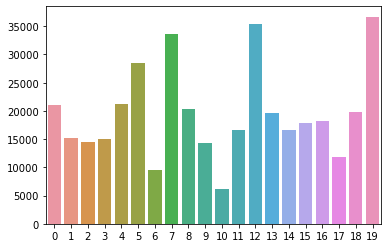

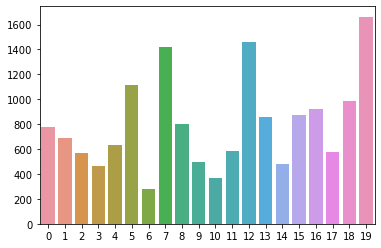

LGB0.85467.csv


In [27]:
sub = pd.read_csv(root_path+'submit_example.csv')

sub['behavior_id'] = labels

vc = data_train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
sub.to_csv('LGB%.5f.csv' % score, index=False)
print('LGB%.5f.csv' % score)